<a href="https://colab.research.google.com/github/haizznaam/Risk-Analysis-NEU/blob/main/LendingClub_WoE_PD_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Set up Colab Env
import os
os.chdir('/content/drive/MyDrive/Risk Analysis - Spring 2024_NEU')
print("We are currently in the folder of ", os.getcwd())

We are currently in the folder of  /content/drive/MyDrive/Risk Analysis - Spring 2024_NEU


# Context & Objective:

The dataset being used here has 7 years' historical loan data taken from [LendingClub](https://www.lendingclub.com/). By looking at the loan status, we can check if the loan was sanctioned to the customers or not. If the loan status is "charged off" or "default" or the issuance of loan got delayed by 31-120 days, it is a bad loan. We will analyze the characteristics of the customers whose loans belong to **"bad loan"** category and will build a **Probability of Default (PD) Model**, so that is can be used in future to predict the customer will default or not.

We have used some useful concepts:
- Binning,
- Weight of Evidence (WoE),
- Information Value (IV)

**Acknowledgements:**
- Some insightful kernels which discussed the above three topics earlier for other applications are: [Pranav Pandya's work](https://www.kaggle.com/code/pranav84/talkingdata-with-breaking-bad-feature-engg/report), [Bryan Arnold's work](https://www.kaggle.com/code/puremath86/iv-woe-starter-for-python/notebook)
- [This youtube webinar](https://www.youtube.com/watch?v=fiQhxn9RjEQ&t=2873s) on credit risk analysis is also informative

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook')
sns.set_style("whitegrid", {'axes.grid' : False})
plt.tight_layout()

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

<Figure size 640x480 with 0 Axes>

In [3]:
data = pd.read_csv("LendingClub Dataset/loan_data_2007_2014.csv", low_memory=False)
data.drop(columns= ["Unnamed: 0"], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13 

Check the "instance attribute summary" section in this [webpage](https://www.rubydoc.info/gems/lending_club/0.0.2/LendingClub/Loan)

# Assigning the Target Column to Identify Bad Loans

In [4]:
# create a new column based on the loan_status column that will be our target variable
data['bad_loan'] = np.where(data.loc[:, 'loan_status'].isin(['Charged Off', 'Default', 'Late (31-120 days)',
                                        'Does not meet the credit policy. Status:Charged Off']), 0, 1)
# Drop the original 'loan_status' column
data.drop(columns = ['loan_status'], inplace = True)

In [5]:
data['bad_loan']

0         1
1         0
2         1
3         1
4         1
         ..
466280    1
466281    0
466282    1
466283    1
466284    1
Name: bad_loan, Length: 466285, dtype: int64

In [6]:
X = data.drop('bad_loan', axis = 1)
y = data['bad_loan']

In [7]:
# display some
data.head(10)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,bad_loan
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5,1075269,1311441,5000,5000,5000.0,36 months,7.90,156.46,A,A4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
6,1069639,1304742,7000,7000,7000.0,60 months,15.96,170.08,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
7,1072053,1288686,3000,3000,3000.0,36 months,18.64,109.43,E,E1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
8,1071795,1306957,5600,5600,5600.0,60 months,21.28,152.39,F,F2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
9,1071570,1306721,5375,5375,5350.0,60 months,12.69,121.45,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [8]:
#cols that contain missing values
missing_values = data.isnull().mean()
missing_values[missing_values>0].sort_values(ascending=False)

dti_joint                      1.000000
annual_inc_joint               1.000000
total_cu_tl                    1.000000
inq_fi                         1.000000
all_util                       1.000000
max_bal_bc                     1.000000
open_rv_24m                    1.000000
open_rv_12m                    1.000000
il_util                        1.000000
total_bal_il                   1.000000
mths_since_rcnt_il             1.000000
open_il_24m                    1.000000
open_il_12m                    1.000000
open_il_6m                     1.000000
open_acc_6m                    1.000000
verification_status_joint      1.000000
inq_last_12m                   1.000000
mths_since_last_record         0.865666
mths_since_last_major_derog    0.787739
desc                           0.729815
mths_since_last_delinq         0.536906
next_pymnt_d                   0.487286
total_rev_hi_lim               0.150715
tot_coll_amt                   0.150715
tot_cur_bal                    0.150715


# Data Preprocessing:

* We need to drop the columns having > 70% missing values.

* The follwing features are identifiers and can not be used in building model. id, member id, url, title, desc, zipcode and emp_title

* The sub_grade column wll also be droped as it contains the same information as the grade columns.

* Features that contain information about the future will not be included in building the model since those events are yet to occur. The features include next_pymnt_d, recoveries, collection_recovery_fee, total_rec_prncp and total_rec_late_fee

In [9]:
#dropping irrelevant cols & cols with missing values

columns_to_drop = ['id', 'member_id', 'sub_grade', 'emp_title', 'url', 'desc', 'title', 'zip_code', 'next_pymnt_d',
                  'recoveries', 'collection_recovery_fee', 'total_rec_prncp', 'total_rec_late_fee', 'desc', 'mths_since_last_record',
                  'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m',
                  'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m',
                  'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m','policy_code',]
data.drop(columns=columns_to_drop, inplace=True, axis=1)

data.dropna(inplace=True)

In [10]:
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,bad_loan
42537,12000,12000,12000.0,36 months,6.62,368.45,A,10+ years,MORTGAGE,105000.0,...,Jan-16,368.45,Jan-16,0.0,INDIVIDUAL,0.0,0.0,267646.0,61100.0,1
42538,12000,12000,12000.0,36 months,13.53,407.40,B,10+ years,RENT,40000.0,...,Sep-15,119.17,Jan-16,0.0,INDIVIDUAL,0.0,15386.0,13605.0,8100.0,1
42539,15000,15000,15000.0,36 months,8.90,476.30,A,2 years,MORTGAGE,63000.0,...,Jan-16,476.30,Jan-16,0.0,INDIVIDUAL,0.0,1514.0,272492.0,15400.0,1
42541,14000,14000,14000.0,36 months,12.85,470.71,B,4 years,RENT,88000.0,...,Jan-16,470.71,Jan-16,0.0,INDIVIDUAL,0.0,0.0,17672.0,4500.0,1
42543,10000,10000,10000.0,36 months,9.67,321.13,B,7 years,MORTGAGE,102000.0,...,Jan-16,321.13,Jan-16,0.0,INDIVIDUAL,0.0,0.0,39143.0,22300.0,1


In [11]:
data.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'pymnt_plan', 'purpose', 'addr_state',
       'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'application_type', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'bad_loan'],
      dtype='object')

# Data Type Transformation

In [12]:
#check datatypes of data again

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181686 entries, 42537 to 466284
Data columns (total 41 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   181686 non-null  int64  
 1   funded_amnt                 181686 non-null  int64  
 2   funded_amnt_inv             181686 non-null  float64
 3   term                        181686 non-null  object 
 4   int_rate                    181686 non-null  float64
 5   installment                 181686 non-null  float64
 6   grade                       181686 non-null  object 
 7   emp_length                  181686 non-null  object 
 8   home_ownership              181686 non-null  object 
 9   annual_inc                  181686 non-null  float64
 10  verification_status         181686 non-null  object 
 11  issue_d                     181686 non-null  object 
 12  pymnt_plan                  181686 non-null  object 
 13  purpose   

The following variables are not possessing appropriate data types and should be modified. Also the NaN values should be replaced with zeroes wherever applicable.

- emp_length,
- term,
- issue_d,
- last_pymnt_d,
- last_credit_pull_d
- earliest_cr_line

We will define functions to transform their data types.

In [13]:
data['emp_length'].value_counts()

10+ years    69102
2 years      15615
3 years      14172
< 1 year     12812
5 years      11434
1 year       10905
7 years      10601
4 years      10380
6 years      10121
8 years       9191
9 years       7353
Name: emp_length, dtype: int64

In [14]:
# converting emp_length to numeric and assign NaN to zero

def emp_length_convert(df, column):
    # df[column] = df[column].str.replace('\+ years', '')
    df[column] = df[column].str.replace('+', '')
    df[column] = df[column].str.replace('< 1 year', str(0))
    df[column] = df[column].str.replace(' years', '')
    df[column] = df[column].str.replace(' year', '')
    df[column] = pd.to_numeric(df[column])
    df[column].fillna(value = 0, inplace = True)


emp_length_convert(data, 'emp_length')

data['emp_length'].unique()

array([10,  2,  4,  7,  6,  5,  8,  3,  1,  0,  9])

In [15]:
data['emp_length'].dtype

dtype('int64')

**Term**

In [16]:
data['term'].value_counts()

 36 months    129478
 60 months     52208
Name: term, dtype: int64

In [17]:
# converting term to numeric

def term_numeric(df, column):
    df[column] = pd.to_numeric(df[column].str.replace(' months', ''))

term_numeric(data, 'term')

In [18]:
data['term'].dtype

dtype('int64')

In [19]:
# preprocessing date cols

def date_columns(df, column):
    # store current month
    today_date = pd.to_datetime('2020-08-01')
    # convert to datetime format
    df[column] = pd.to_datetime(df[column], format = "%b-%y")
    # calculate the difference in months and add to a new column
    df['mths_since_' + column] = round(pd.to_numeric((today_date - df[column]) / np.timedelta64(1, 'M')))
    # make any resulting -ve values to be equal to the max date
    df['mths_since_' + column] = df['mths_since_' + column].apply(lambda x: df['mths_since_' + column].max() if x < 0 else x)
    # drop the original date column
    df.drop(columns = [column], inplace = True)


date_columns(data, 'issue_d')
date_columns(data, 'last_pymnt_d')
date_columns(data, 'last_credit_pull_d')
date_columns(data, 'earliest_cr_line')

In [20]:
# checking for missing values again

missing_values = data.isnull().sum()
missing_values[missing_values>0]/len(data)

Series([], dtype: float64)

# Checking Correlation among Features

In [21]:
numeric_df = data.select_dtypes(include=[np.int64, np.float64])

<Axes: >

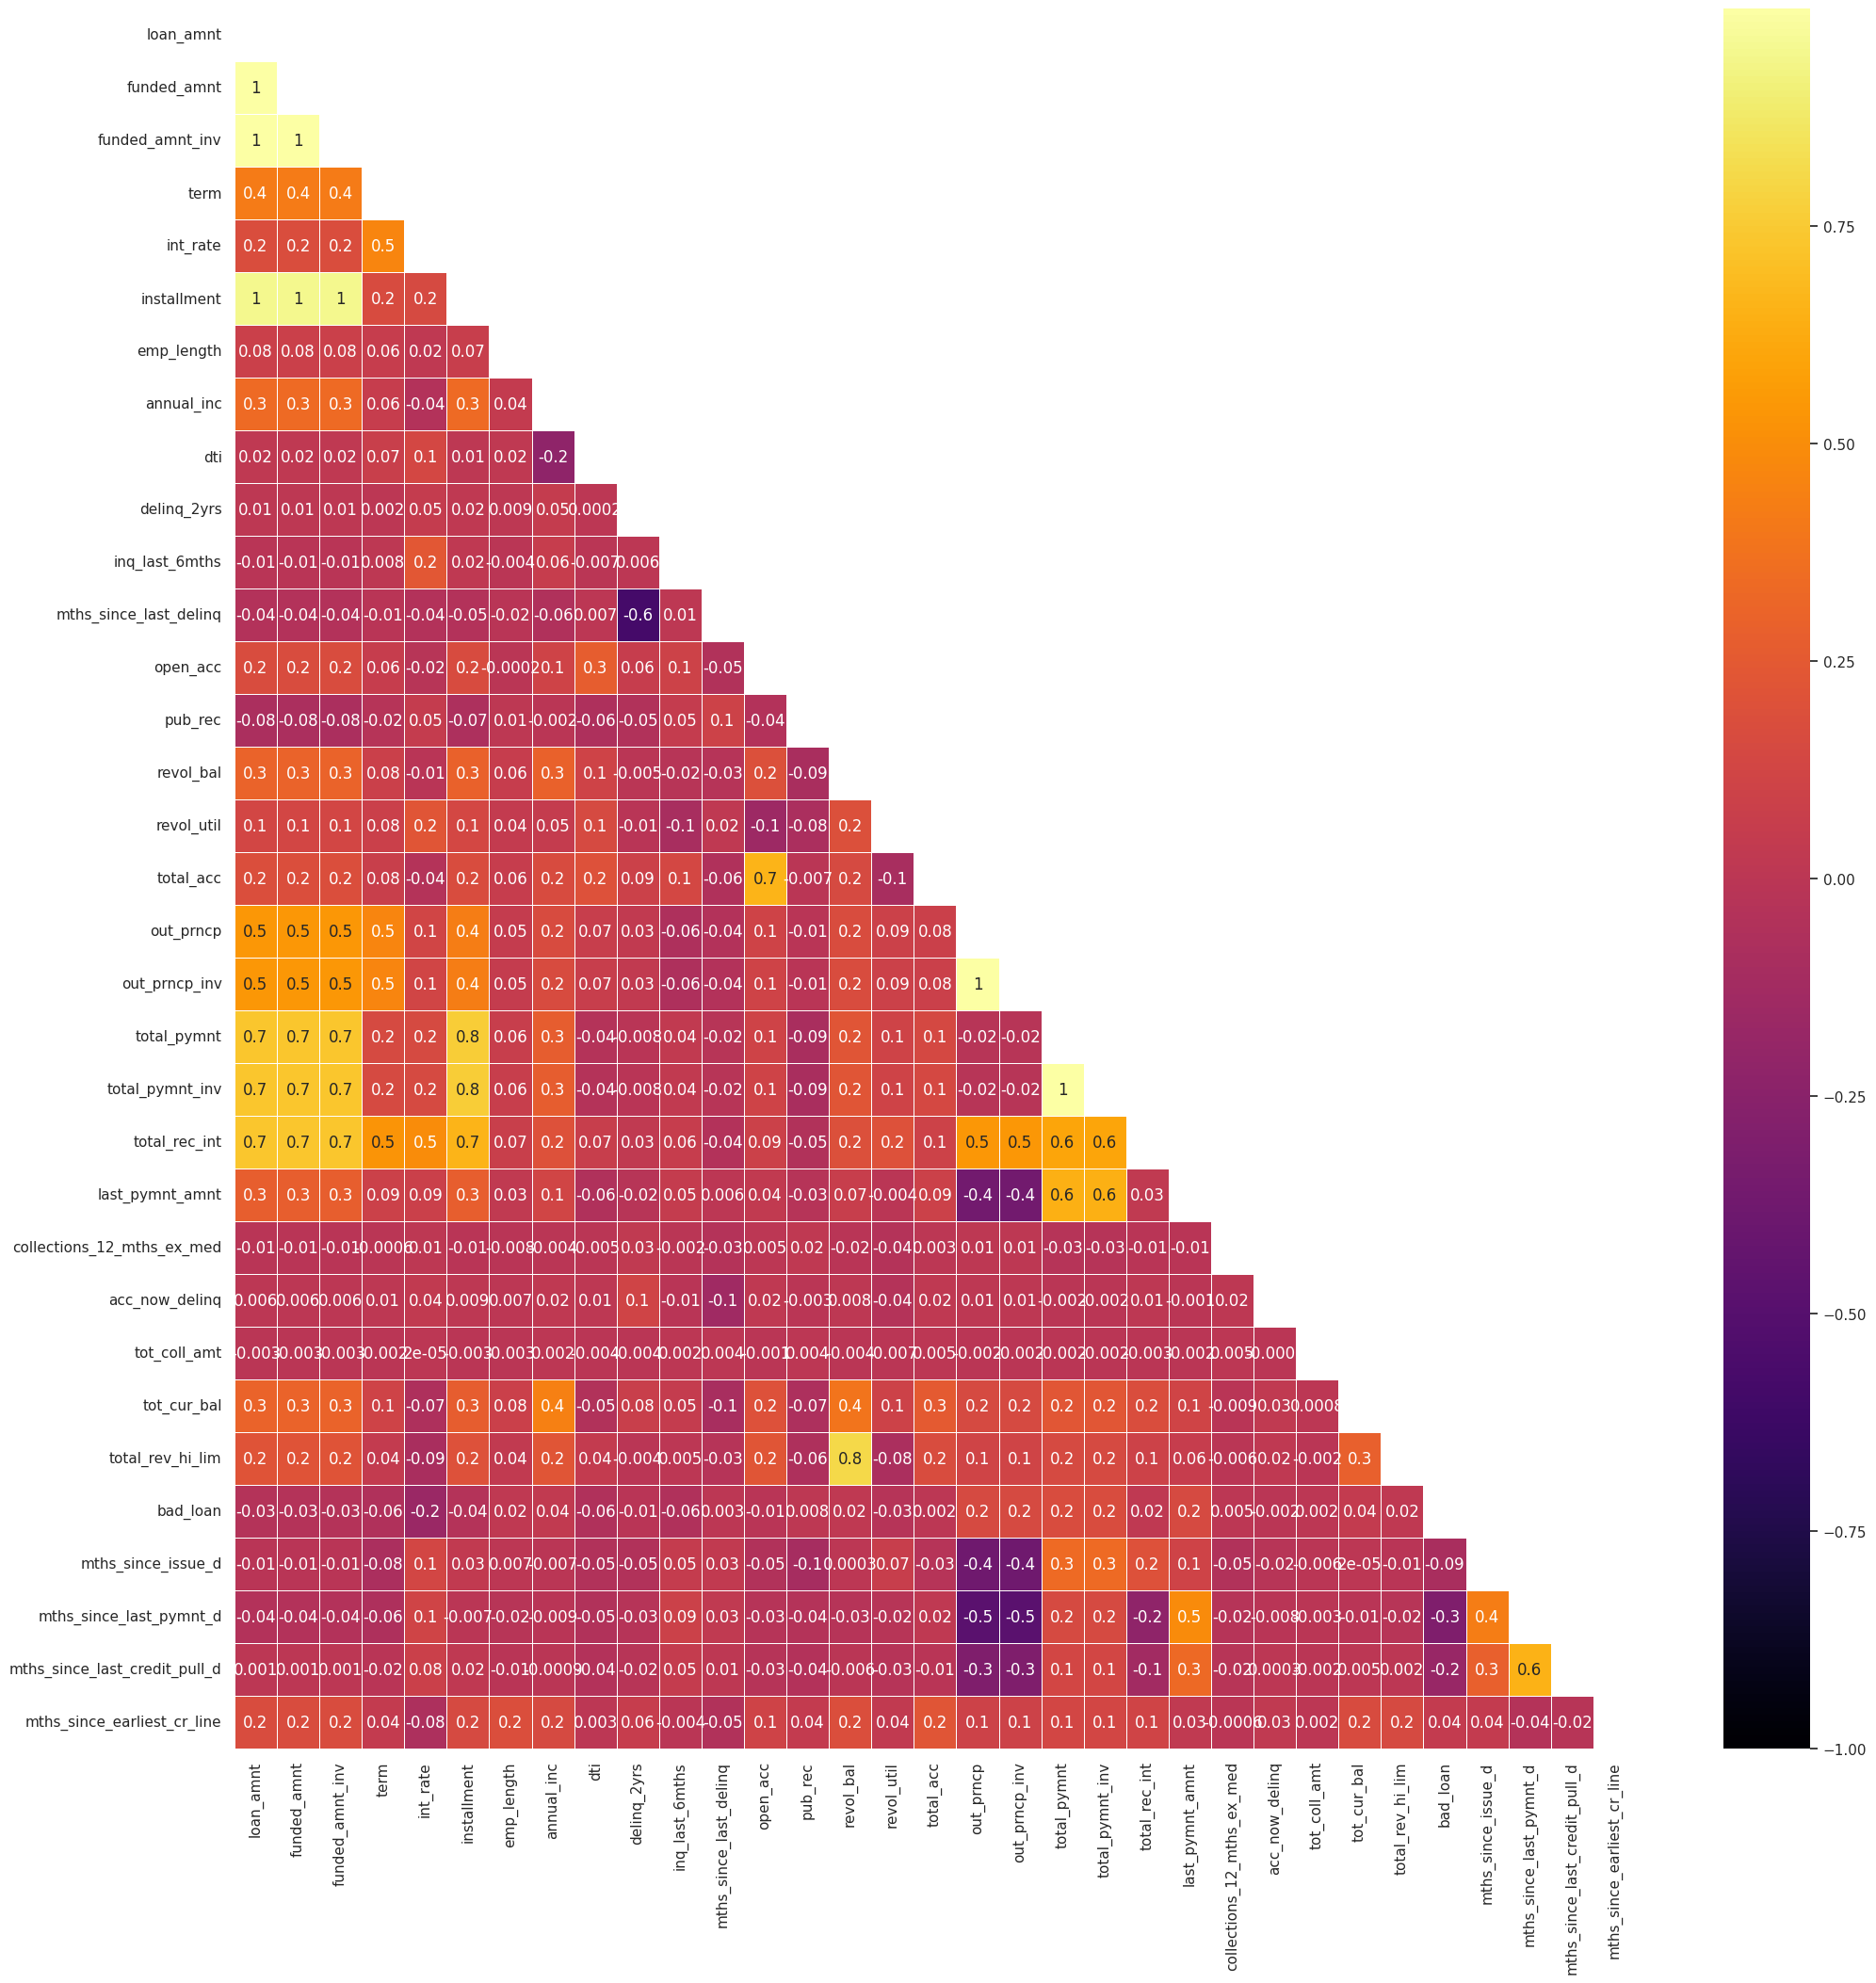

In [22]:
# correlation matrix with correlation co-effiecients
import numpy as np
mask = np.zeros_like(numeric_df.corr().fillna(0))
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(24,24))
sns.heatmap(numeric_df.corr(), mask=mask, annot=True,  cmap="inferno", vmin = -1, fmt='.1g', edgecolor='w', linewidth=0.6)

# Removing Multicollinear Features

In [23]:
 data.drop(columns=['loan_amnt', 'revol_bal', 'funded_amnt', 'funded_amnt_inv', 'installment',
                   'total_pymnt_inv',  'out_prncp_inv',  'total_acc'], inplace=True)

<Axes: >

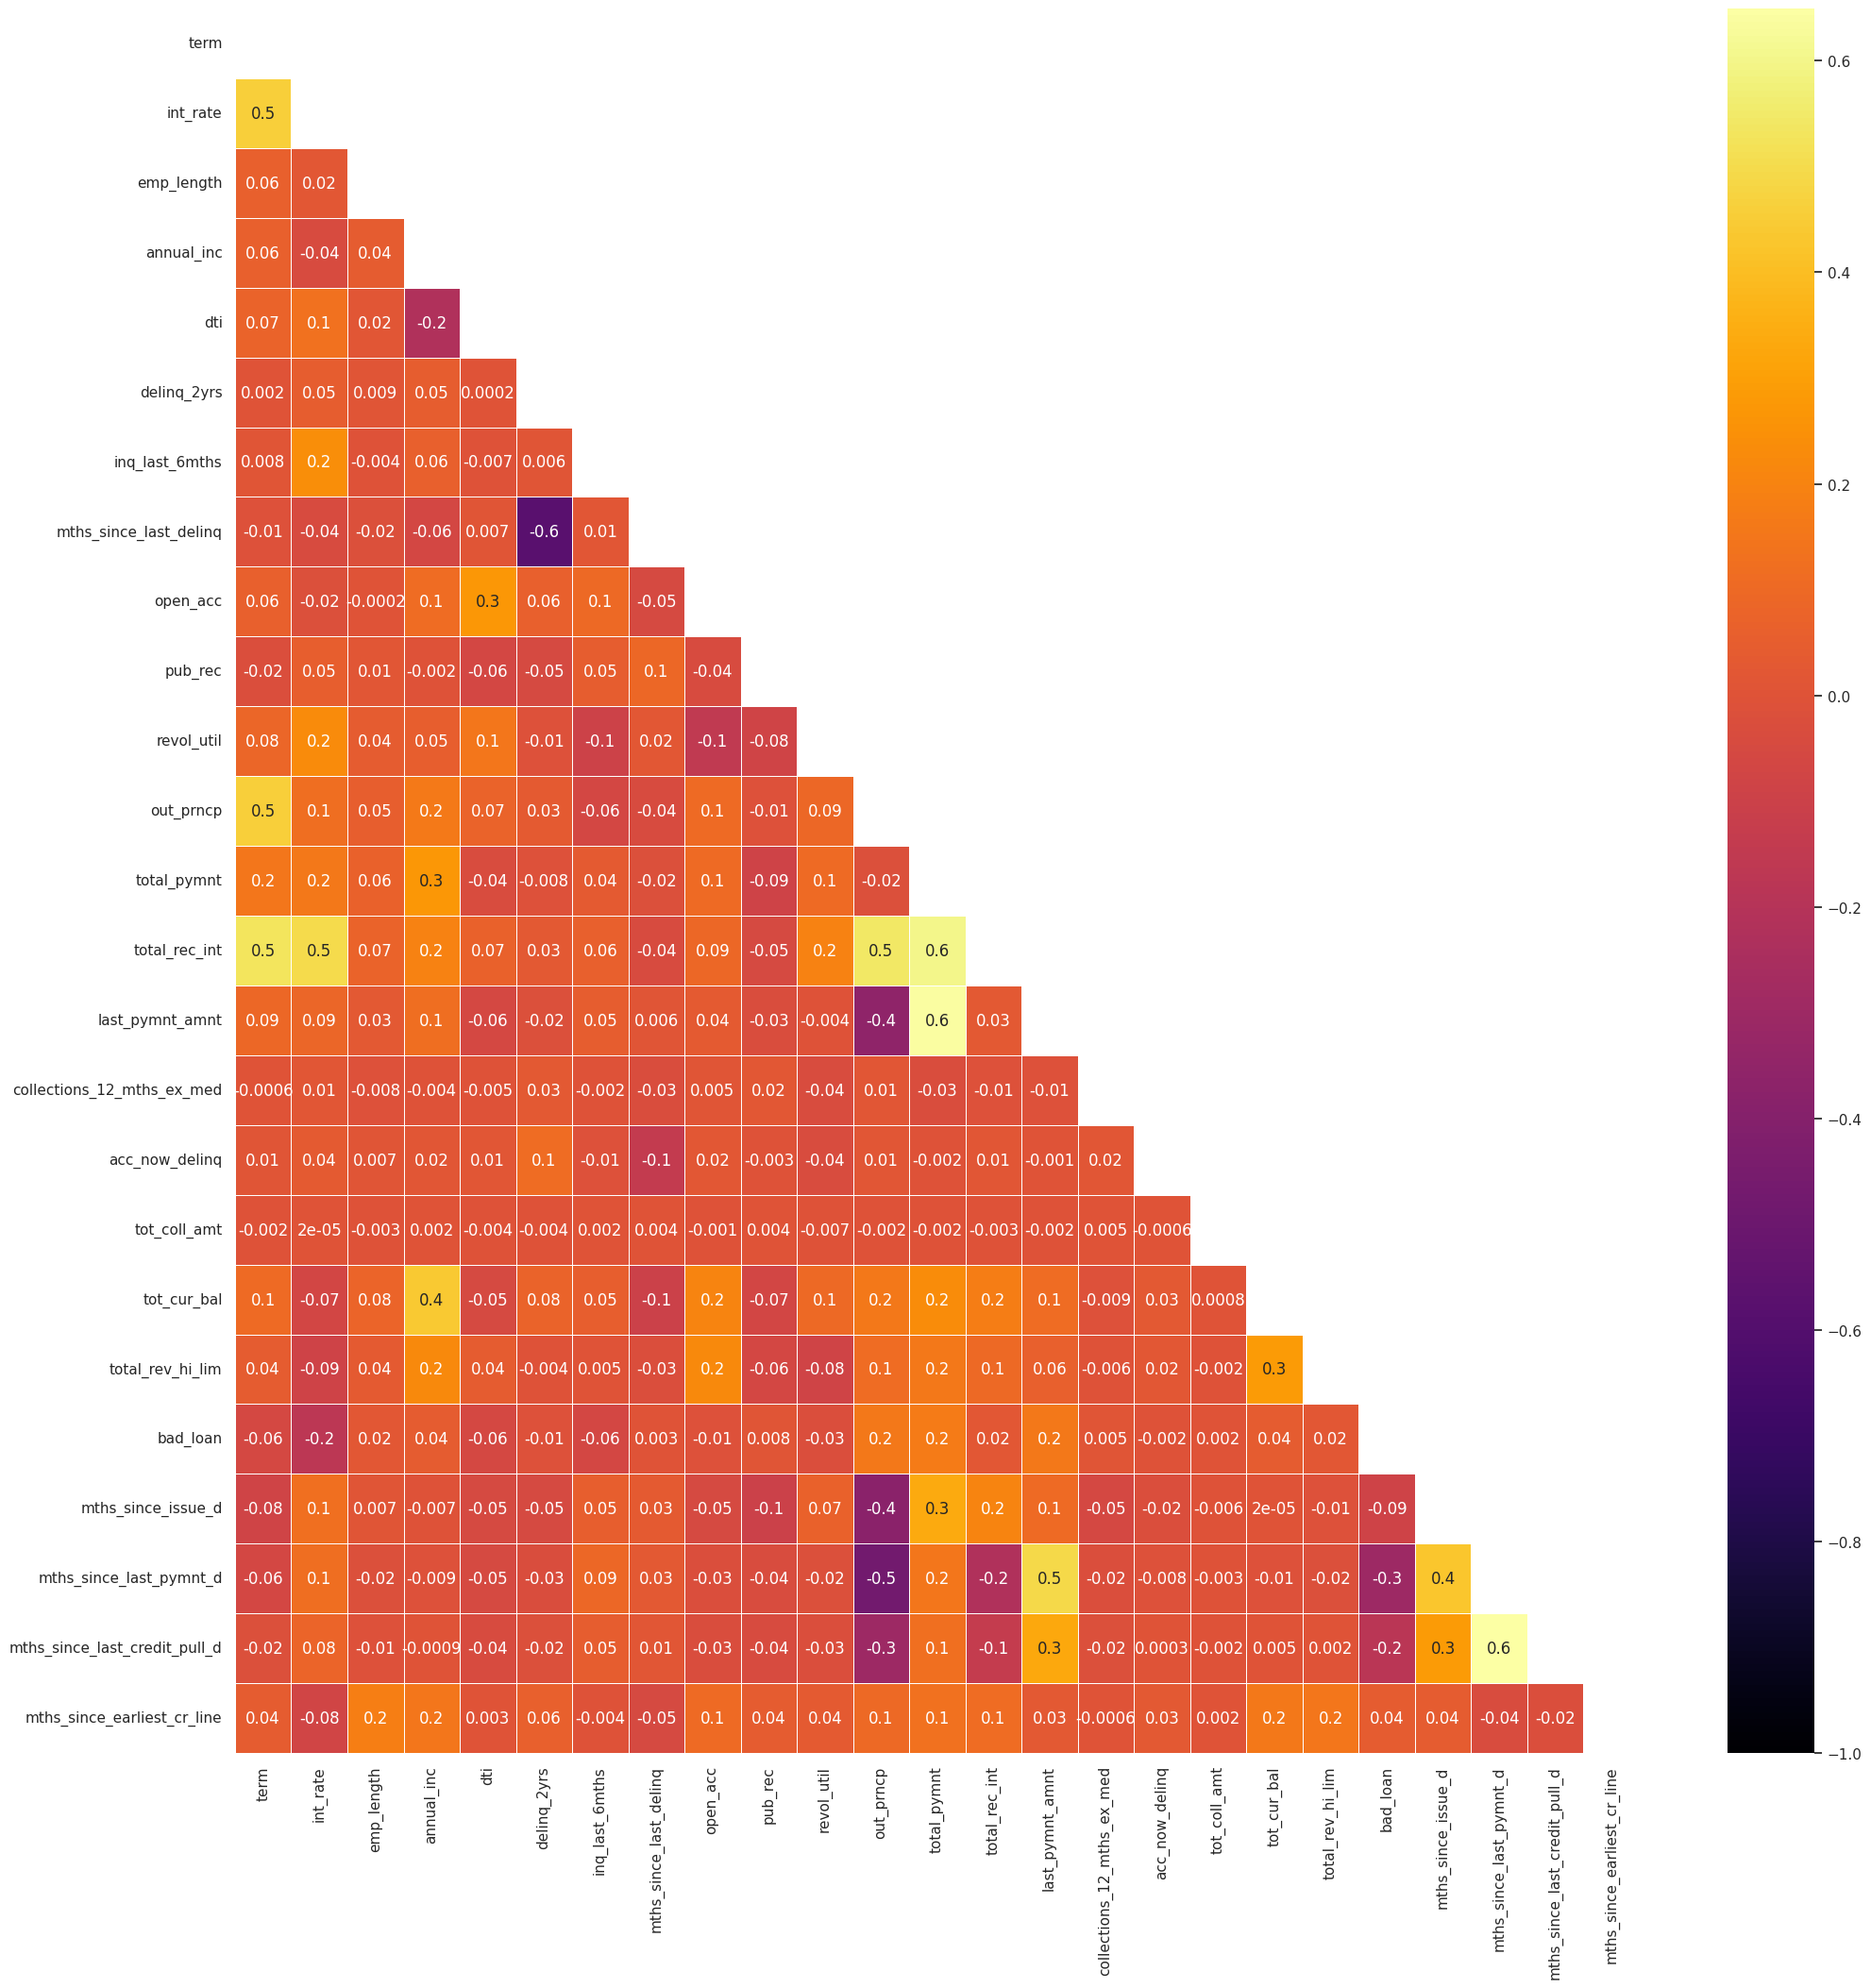

In [24]:
numeric_df = data.select_dtypes(include=[np.int64, np.float64])
mask = np.zeros_like(numeric_df.corr().fillna(0))
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(24,24))
sns.heatmap(numeric_df.corr(), mask=mask, annot=True,  cmap="inferno", vmin = -1, fmt='.1g', edgecolor='w', linewidth=0.6)

In [25]:
##descriptive statistics
data.describe()

,term,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,...,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,bad_loan,mths_since_issue_d,mths_since_last_pymnt_d,mths_since_last_credit_pull_d,mths_since_earliest_cr_line
count,181686.000000,181686.000000,181686.000000,1.816860e+05,181686.000000,181686.000000,181686.000000,181686.000000,181686.000000,181686.000000,...,181686.000000,181686.000000,1.816860e+05,1.816860e+05,1.816860e+05,181686.000000,181686.000000,181686.000000,181686.000000,181686.000000
mean,42.896470,14.449868,6.324092,7.886698e+04,17.389873,0.638040,0.822942,33.724167,11.756382,0.189244,...,0.016418,0.009808,3.263843e+02,1.505644e+05,2.735155e+04,0.901897,77.987522,59.690532,56.907192,284.550026
std,10.860692,4.252272,3.607371,6.078531e+04,7.787230,1.104461,1.059299,21.716923,4.997763,0.557625,...,0.149082,0.107319,2.157745e+04,1.595617e+05,4.243696e+04,0.297455,7.312420,7.251103,4.930061,82.832749
min,36.000000,6.000000,0.000000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000e+02,0.000000,68.000000,55.000000,55.000000,107.000000
25%,36.000000,11.670000,3.000000,5.000000e+04,11.530000,0.000000,0.000000,15.000000,8.000000,0.000000,...,0.000000,0.000000,0.000000e+00,3.245125e+04,1.230000e+04,1.000000,72.000000,55.000000,55.000000,227.000000
50%,36.000000,14.160000,7.000000,6.800000e+04,16.910000,0.000000,0.000000,30.000000,11.000000,0.000000,...,0.000000,0.000000,0.000000e+00,9.847150e+04,2.060000e+04,1.000000,77.000000,56.000000,55.000000,267.000000
75%,60.000000,17.140000,10.000000,9.402825e+04,22.900000,1.000000,1.000000,49.000000,14.000000,0.000000,...,0.000000,0.000000,0.000000e+00,2.255148e+05,3.400000e+04,1.000000,83.000000,62.000000,55.000000,326.000000
max,60.000000,26.060000,10.000000,7.500000e+06,39.990000,29.000000,7.000000,188.000000,84.000000,21.000000,...,20.000000,5.000000,9.152545e+06,8.000078e+06,9.999999e+06,1.000000,96.000000,95.000000,95.000000,619.000000


In [26]:
# Final 25 columns
data.columns

Index(['term', 'int_rate', 'grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'pymnt_plan', 'purpose',
       'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_util',
       'initial_list_status', 'out_prncp', 'total_pymnt', 'total_rec_int',
       'last_pymnt_amnt', 'collections_12_mths_ex_med', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'bad_loan', 'mths_since_issue_d', 'mths_since_last_pymnt_d',
       'mths_since_last_credit_pull_d', 'mths_since_earliest_cr_line'],
      dtype='object')

In [27]:
# data.to_csv('loan-data-25-feats.csv', index=False)

# Seprating categorical features from numerical

In [28]:
# seperating categorical features from numerical
categorical_features = data.select_dtypes(exclude='number')
numerical_features = data.select_dtypes(exclude='object')

In [29]:
# converting to dataframe
filled_data = data

In [30]:
preprocess_data = data

#checking for any missing values
missing = preprocess_data.isnull().sum()
missing[missing>0]

Series([], dtype: int64)

Finally no missing values

# Binning, Weight of Evidence (WoE), Information Value (IV)

- **Binning** create buckets of independent variables based on ranking  methods. Binning helps us converting continuous variables into categorical ones. This process allows us to understand feature performance better. The  insights from this part of the analysis can be useful in devising portfolio risk strategies. One simple binning example using "age" is given below for illustration.

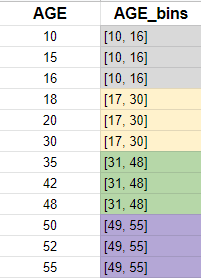

- **Weight of Evidence (WoE)** will help us to determine which categories should be binned together. WOE measures the strength of a bin in differentiating the Good and Bad accounts. WOE < 0 indicates that the variable bin is captures higher proportion of bad accounts.


- **Information Value (IV)** will help in determining which variables are useful for prediction in the logistic regression model. IV is the measure of overall predictive power of the variables and is very useful for feature selection.


**The formular of WoE and IV are as follows:**

$$\text{WoE} = [ln (\frac{\text{Relative frequency of Goods}}{\text{Relative frequency of Bads}})] \times 100$$

$$IV = \sum (\text{Distribution Good}_i - \text{Distribution Bad}_i) \times \text{WoE}_i$$



In [31]:
#function to calculate Weight of Evidence (WoE) and Information Value (IV)

def iv_woe(data, target, bins=10, show_woe=False):

    new_df,woe_df = pd.DataFrame(), pd.DataFrame()
    cols = data.columns

    #Run WoE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        new_df=pd.concat([new_df,temp], axis=0)
        woe_df=pd.concat([woe_df,d], axis=0)

        if show_woe == True:
            print(d)

    return new_df, woe_df

iv, woe = iv_woe(preprocess_data, target='bad_loan', bins=20)

Information value of term is 0.035478
Information value of int_rate is 0.347724
Information value of grade is 0.281145
Information value of emp_length is 0.007174
Information value of home_ownership is 0.017952
Information value of annual_inc is 0.037998
Information value of verification_status is 0.033377
Information value of pymnt_plan is 0.000309
Information value of purpose is 0.028333
Information value of addr_state is 0.010291
Information value of dti is 0.041026
Information value of delinq_2yrs is 0.001039
Information value of inq_last_6mths is 0.040454
Information value of mths_since_last_delinq is 0.002487
Information value of open_acc is 0.004499
Information value of pub_rec is 0.000504
Information value of revol_util is 0.008858
Information value of initial_list_status is 0.011513
Information value of out_prncp is 0.703375
Information value of total_pymnt is 0.515794
Information value of total_rec_int is 0.011108
Information value of last_pymnt_amnt is 1.491828
Information v

In [32]:
woe

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,term,36,129478,118188,0.721265,11290,0.633416,0.129880,0.011410
1,term,60,52208,45674,0.278735,6534,0.366584,-0.273969,0.024068
0,int_rate,"(5.999, 7.69]",10195,9973,0.060862,222,0.012455,1.586481,0.076797
1,int_rate,"(7.69, 8.9]",10280,9878,0.060282,402,0.022554,0.983135,0.037092
2,int_rate,"(8.9, 9.99]",7066,6767,0.041297,299,0.016775,0.900891,0.022091
...,...,...,...,...,...,...,...,...,...
15,mths_since_earliest_cr_line,"(326.0, 348.0]",9323,8524,0.052019,799,0.044827,0.148801,0.001070
16,mths_since_earliest_cr_line,"(348.0, 371.0]",8945,8178,0.049908,767,0.043032,0.148237,0.001019
17,mths_since_earliest_cr_line,"(371.0, 399.0]",8889,8188,0.049969,701,0.039329,0.239438,0.002548
18,mths_since_earliest_cr_line,"(399.0, 444.0]",9192,8472,0.051702,720,0.040395,0.246792,0.002790


In [33]:
iv

,Variable,IV
0,term,0.035478
0,int_rate,0.347724
0,grade,0.281145
0,emp_length,0.007174
0,home_ownership,0.017952
0,annual_inc,0.037998
0,verification_status,0.033377
0,pymnt_plan,0.000309
0,purpose,0.028333
0,addr_state,0.010291


The rule of thumb says that all variables with IV < 0.02 are not useful for prediction and IV > 0.5 have a suspicious predictive power. Therefore, the follwing variables will not be included out_prncp, last_pymnt_amnt, delinq_2yrs, mths_since_last_delinq, open_acc, pub_rec, total_acc, collections_12_mths_ex_med, acc_now_delinq, tot_coll_amt and mths_since_last_pymnt_d

In [34]:
#drop columns with low IV
preprocess_data.drop(columns=[ 'pymnt_plan', 'last_pymnt_amnt', 'revol_util', 'delinq_2yrs', 'mths_since_last_delinq',
                              'open_acc', 'pub_rec',  'collections_12_mths_ex_med', 'acc_now_delinq',
                              'tot_coll_amt', 'mths_since_last_pymnt_d', 'emp_length', 'application_type'], axis=1, inplace=True)

In [35]:
print(f'Remainning columns : {len(preprocess_data.columns)}')
preprocess_data.columns

Remainning columns : 20


Index(['term', 'int_rate', 'grade', 'home_ownership', 'annual_inc',
       'verification_status', 'purpose', 'addr_state', 'dti', 'inq_last_6mths',
       'initial_list_status', 'out_prncp', 'total_pymnt', 'total_rec_int',
       'tot_cur_bal', 'total_rev_hi_lim', 'bad_loan', 'mths_since_issue_d',
       'mths_since_last_credit_pull_d', 'mths_since_earliest_cr_line'],
      dtype='object')

# Dummy Variables for Categorical Columns

In [36]:
# dummy variables for cat cols
data_dummies1 = [pd.get_dummies(preprocess_data['grade'], prefix='grade', prefix_sep=':'),
                 pd.get_dummies(preprocess_data['home_ownership'], prefix='home_ownership', prefix_sep=':'),
                 pd.get_dummies(preprocess_data['verification_status'], prefix='verification_status', prefix_sep=':'),
                 pd.get_dummies(preprocess_data['purpose'], prefix='purpose', prefix_sep=':'),
                 pd.get_dummies(preprocess_data['addr_state'], prefix='addr_state', prefix_sep=':'),
                 pd.get_dummies(preprocess_data['initial_list_status'], prefix='initial_list_status', prefix_sep=':')
                ]

In [37]:
# turn  data_dummies into dataframe

categorical_dummies = pd.concat(data_dummies1, axis=1)
categorical_dummies.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,...,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w
42537,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
42538,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
42539,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
42541,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
42543,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [38]:
# concatinating preprocess_data with categorical_dummies

preprocess_data = pd.concat([preprocess_data, categorical_dummies], axis=1)

In [39]:
# function to calculate WoE of cat features

def woe_categorical(df, cat_feature, good_bad_df):
    df = pd.concat([df[cat_feature], good_bad_df], axis=1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)

    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()

    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()

    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [40]:
# function to plot WoE
import numpy as np

def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18, 12))
    plt.plot(x, y, marker = 'o', color = 'hotpink', linestyle = 'dashed', linewidth = 3, markersize = 18, markeredgecolor = 'cyan', markerfacecolor = 'black')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]), size = 20)
    plt.xticks(rotation = rotation_of_x_axis_labels)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

In [41]:
#seperating data into target and features
X= preprocess_data.drop(columns='bad_loan', axis=1)
y=preprocess_data['bad_loan']

# Analyzing Categorical Variables by Plotting WoE

**1. Analyzing Grade variable**

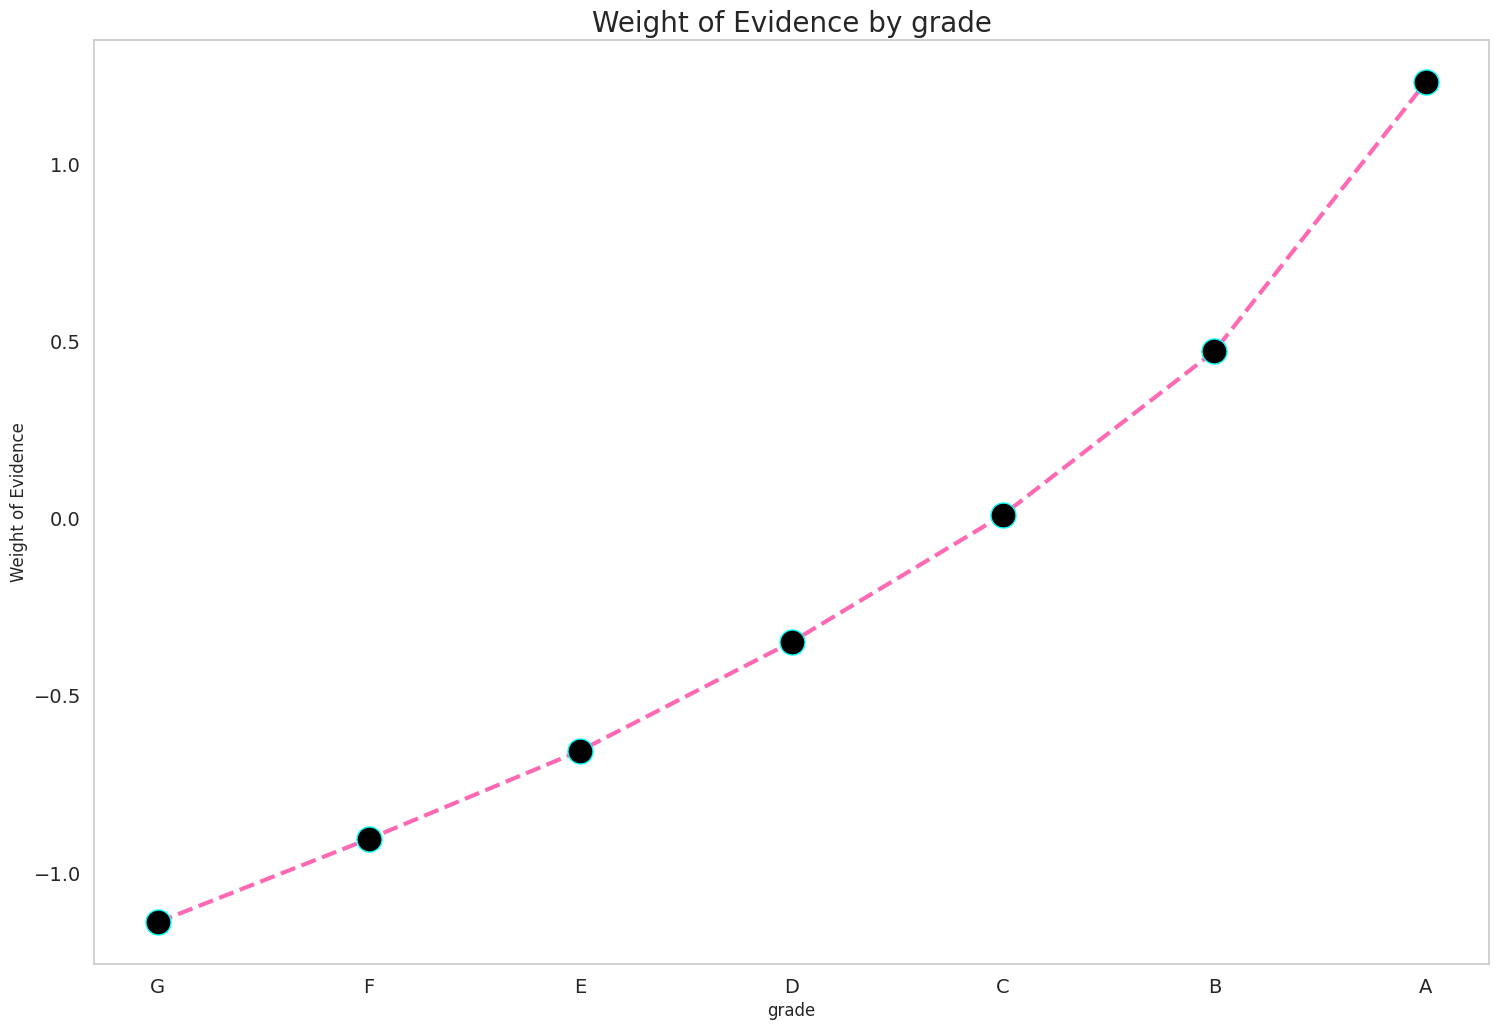

In [42]:
df_grade = woe_categorical(X, 'grade', y)
plot_by_woe(df_grade)

We can see from the above graph that the grades have significantly different woe as we grade changes. We will therefore keep each grade as a feature.

**2. Analyzing Home Ownership variable**

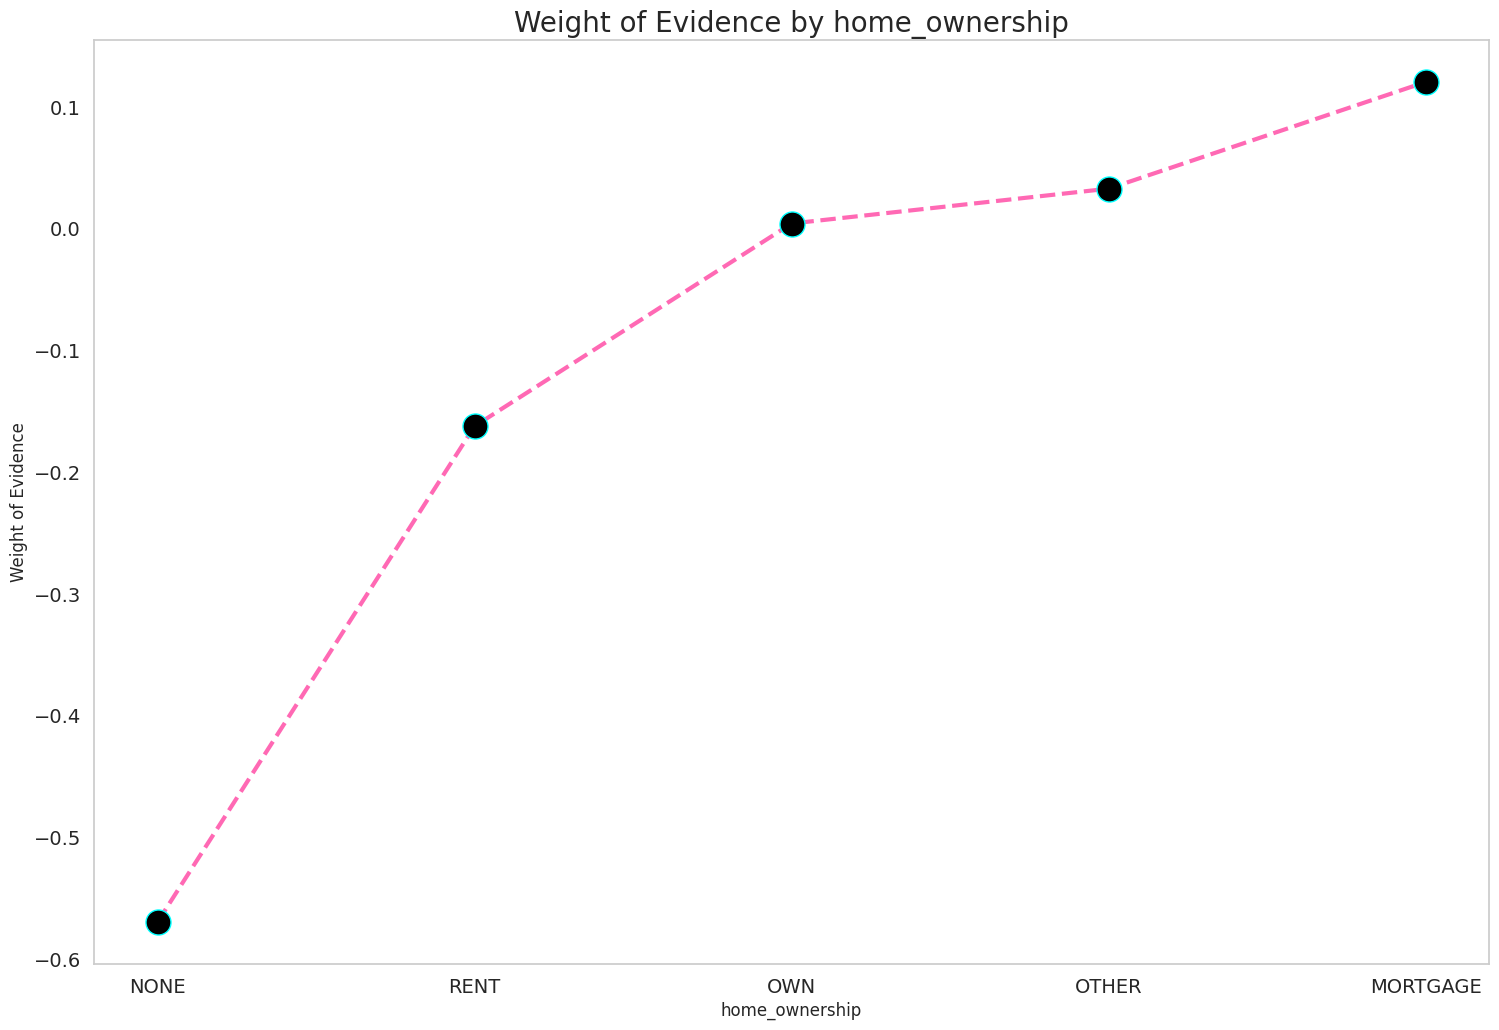

In [43]:
df_home = woe_categorical(X, 'home_ownership', y)
plot_by_woe(df_home)

OTHER, NONE and ANY have very few observations and should be combined with the category with high risk of default that is RENT

**3. Analyzing Verification status variable**

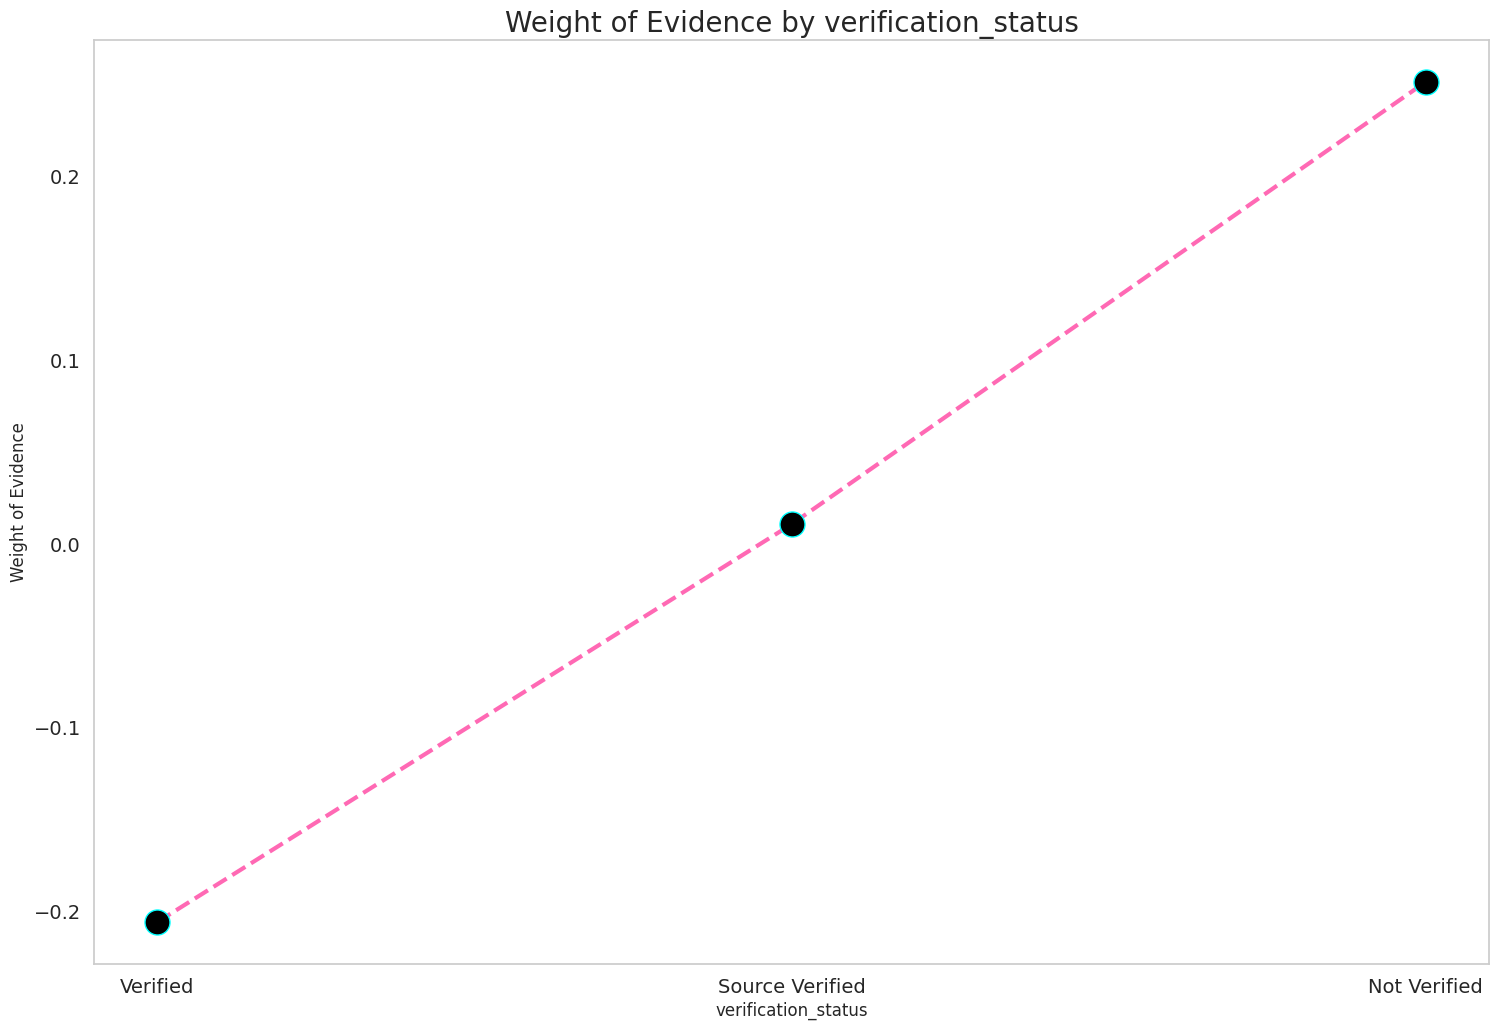

In [44]:
veri_df = woe_categorical(X, 'verification_status', y)
plot_by_woe(veri_df)

This variable has different WoE values and can be used as seperate variables

**4. Analyzing Purpose variable**

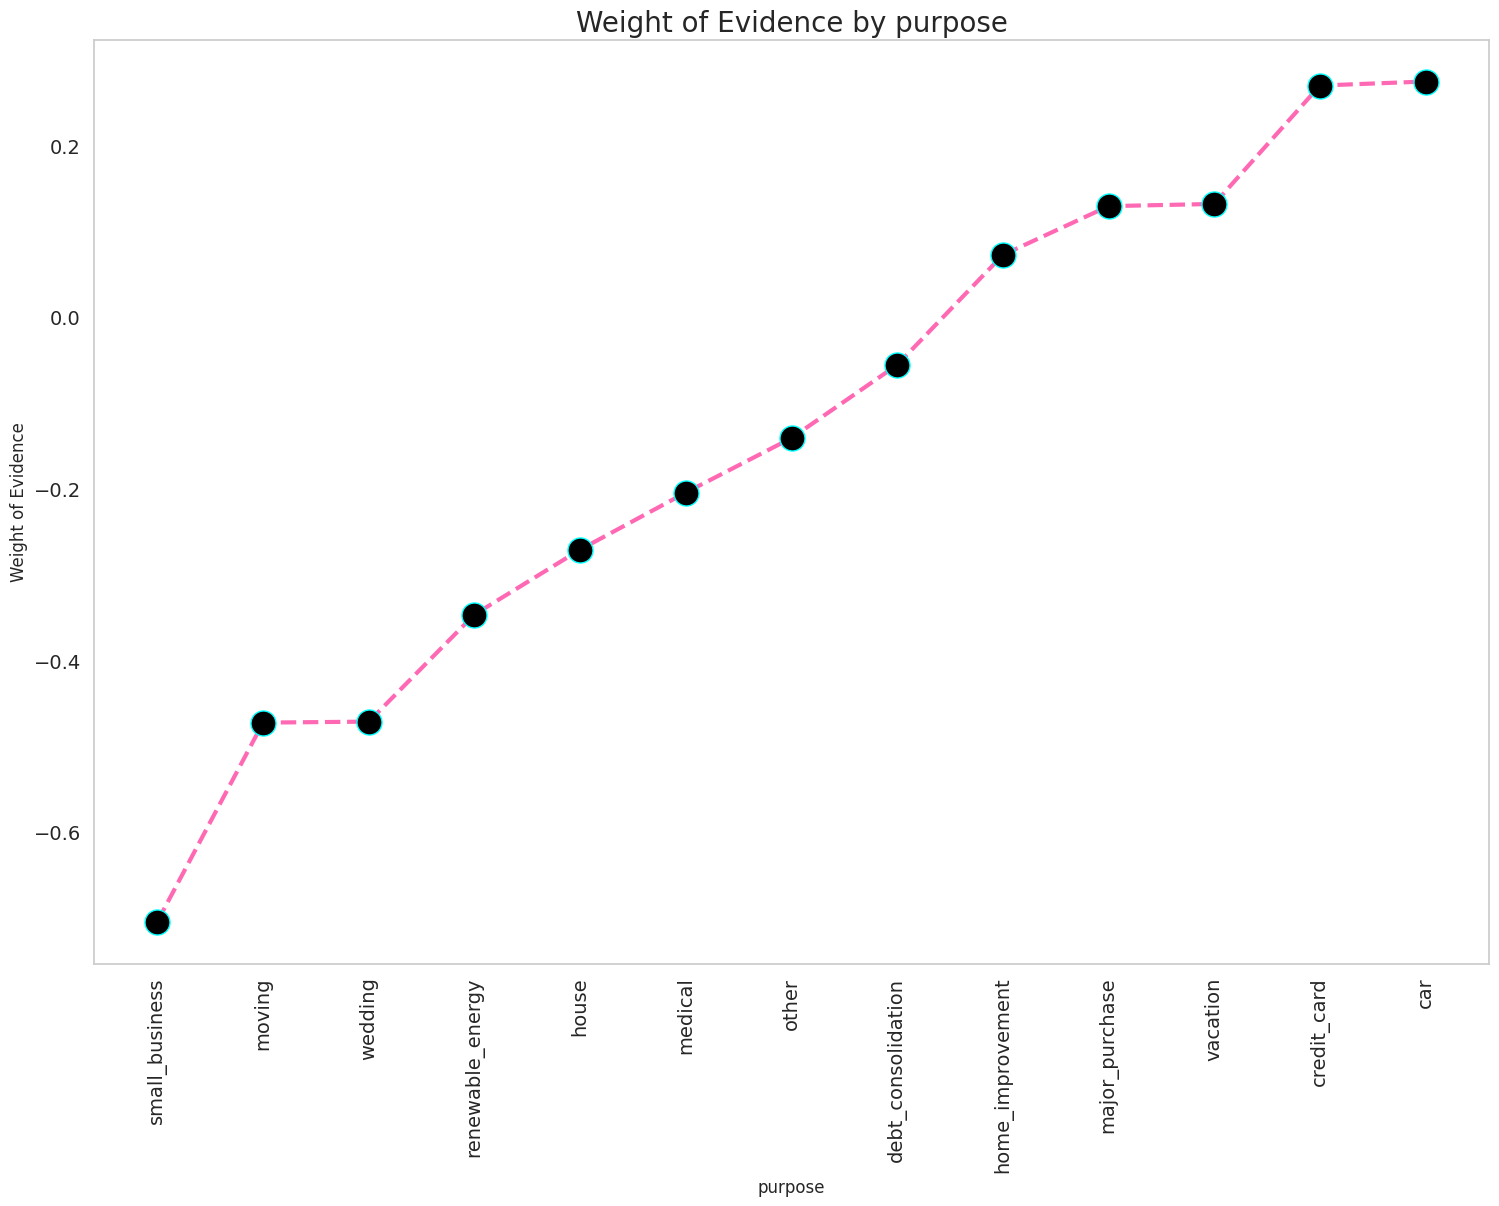

In [45]:
pur_df = woe_categorical(X, 'purpose', y)
plot_by_woe(pur_df, 90)

The following categories wil be combined together:

educational, renewable_energy, moving
other,house, medical
weeding, vacation
debt_consolidation
home_improvement, major purchase
car, credit_card

**5. Analyzing address-state variable**

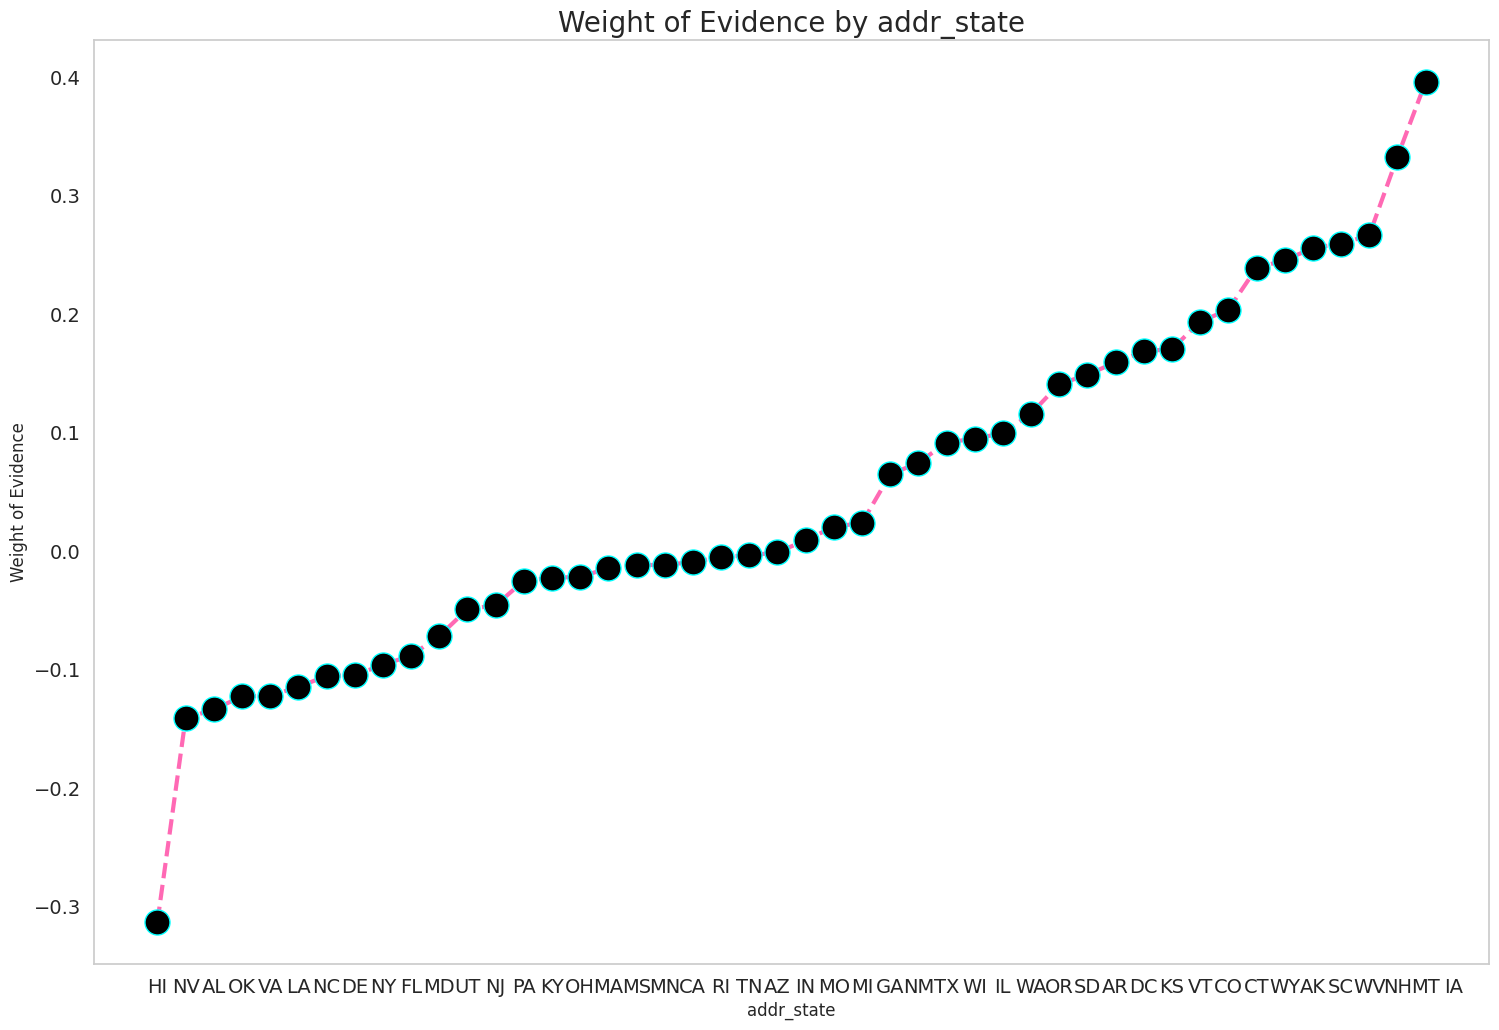

In [46]:
addr_df = woe_categorical(X, 'addr_state', y)
plot_by_woe(addr_df)

The states NE, IA, ME and ID have low observations and this may be the reason for their extreme woe. We will plot the graph again excluding these categories and see if there is any change.

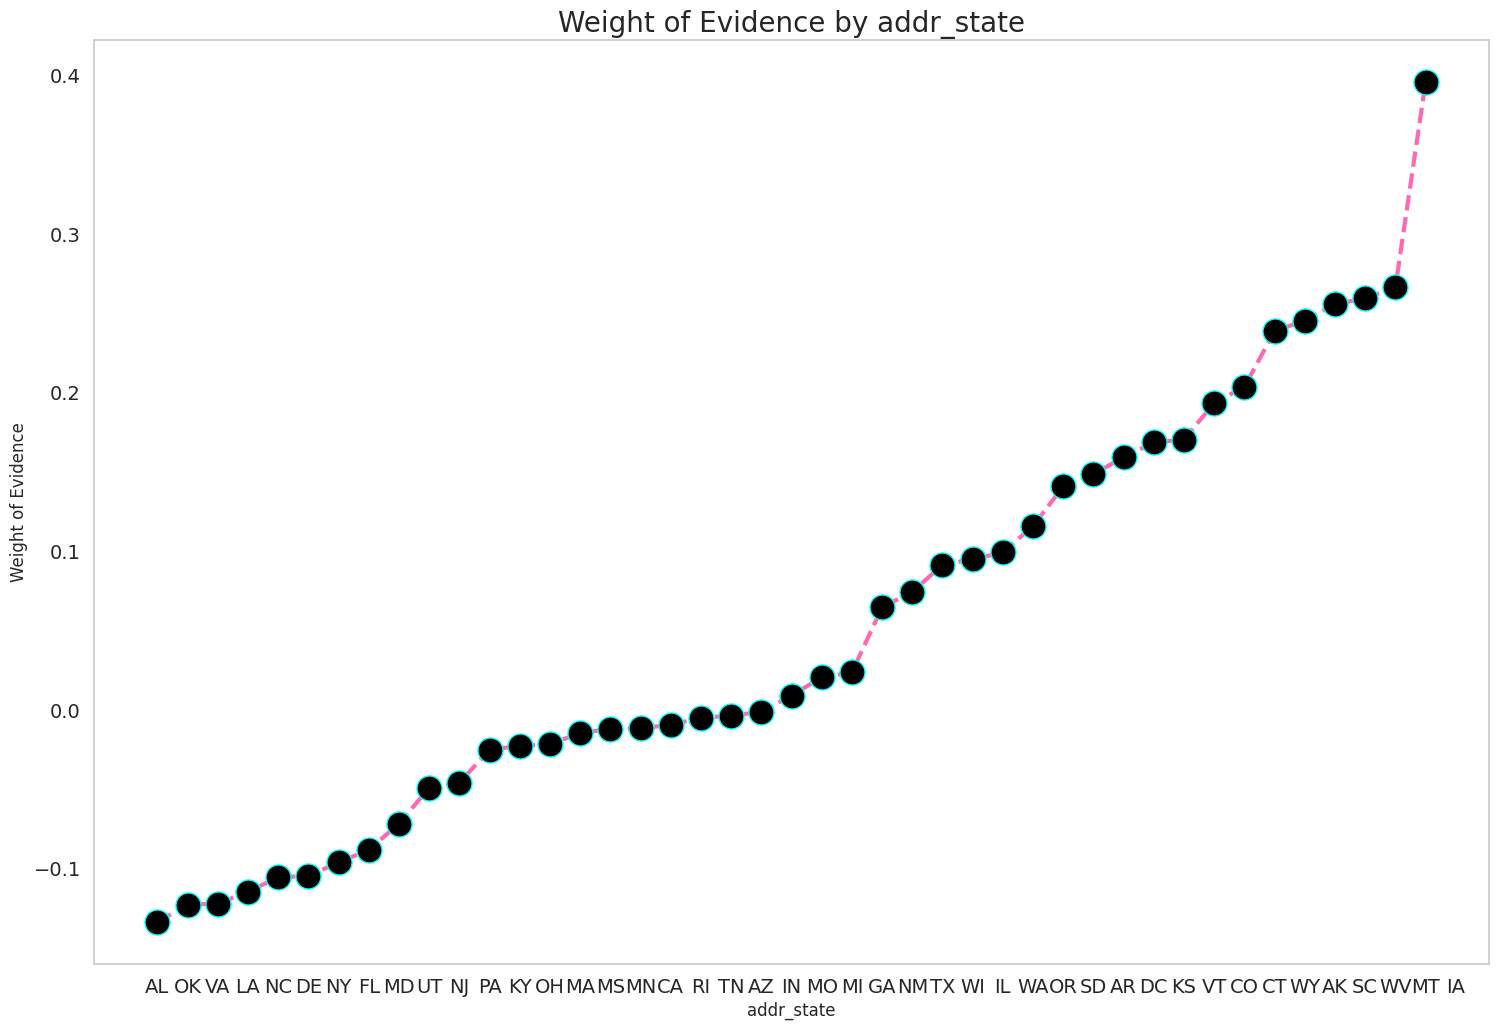

In [47]:
data1 =addr_df.iloc[2:44, :]
data2 =addr_df.iloc[45:49, :]
low_data_woe = pd.concat([data1, data2], axis=0)
plot_by_woe(low_data_woe)

In deciding which categories to combine we use both WOE and the number of observations in our analysis. Categories with similar WoE but significantly different observations will not be combined together, because the number of observations can influence the WoE values. Also, categories with both similar WoE and observations greater than 5% can be combined together to form a new category. This process will be used for the rest of analysis.The categories to be combined as follows:

- NE, IA, NV, HI, FL, AL
- NY
- LA, NM, OK, NC, MO, MD, NJ, VA
- CA
- AZ, MI, UT, TN, AR, PA
- RI, OH, KY, DE, MN, SD, MA, IN
- GA, WA
- WI, OR
- TX
- IL, CT,MT
- CO, SC
- KS, VT, AK, MS
- NH, WV, WY, DC

In total we will have to create 13 categories for the addr_variable. We will create these variables later. Let us move on to analyze the rest of the features.

**6. Analyzing initial list status variable**

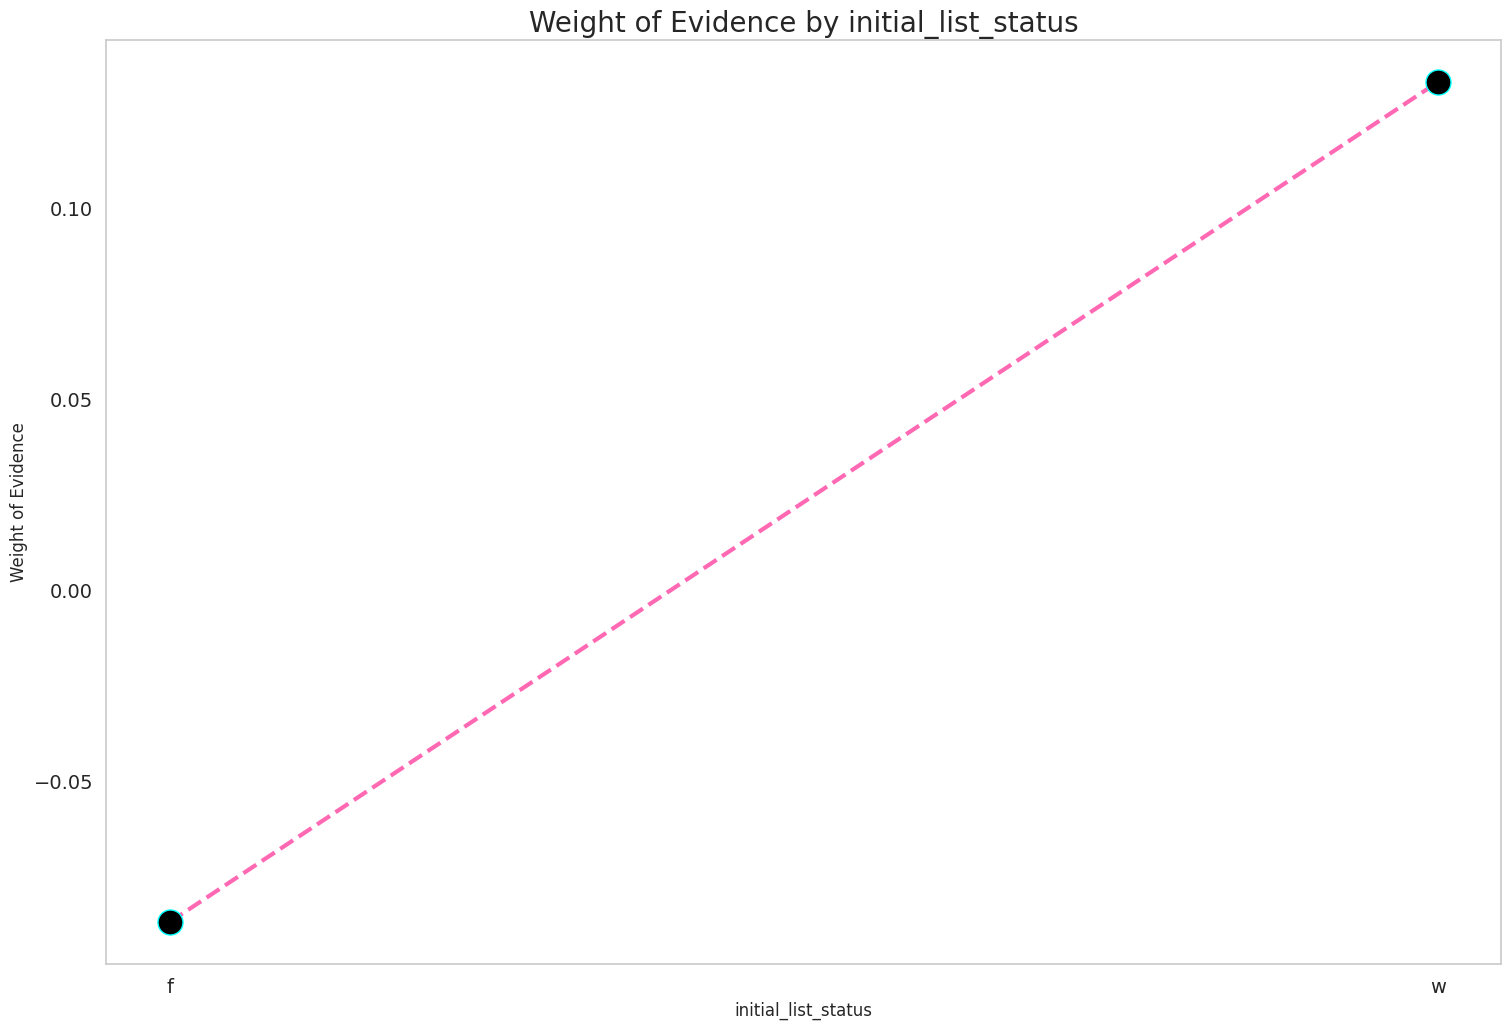

In [48]:
init_list_df = woe_categorical( X, 'initial_list_status', y)
plot_by_woe(init_list_df)

This variable has significantly different WoE values and categories should be kept as seperate variables

# Analyzing Continous Variables by Plotting WoE

In [49]:
# function to calculate WoE for continous variables
def woe_continous(df, cat_feature, good_bad_df):
    df = pd.concat([df[cat_feature], good_bad_df], axis=1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

**1. Analyzing term variable**

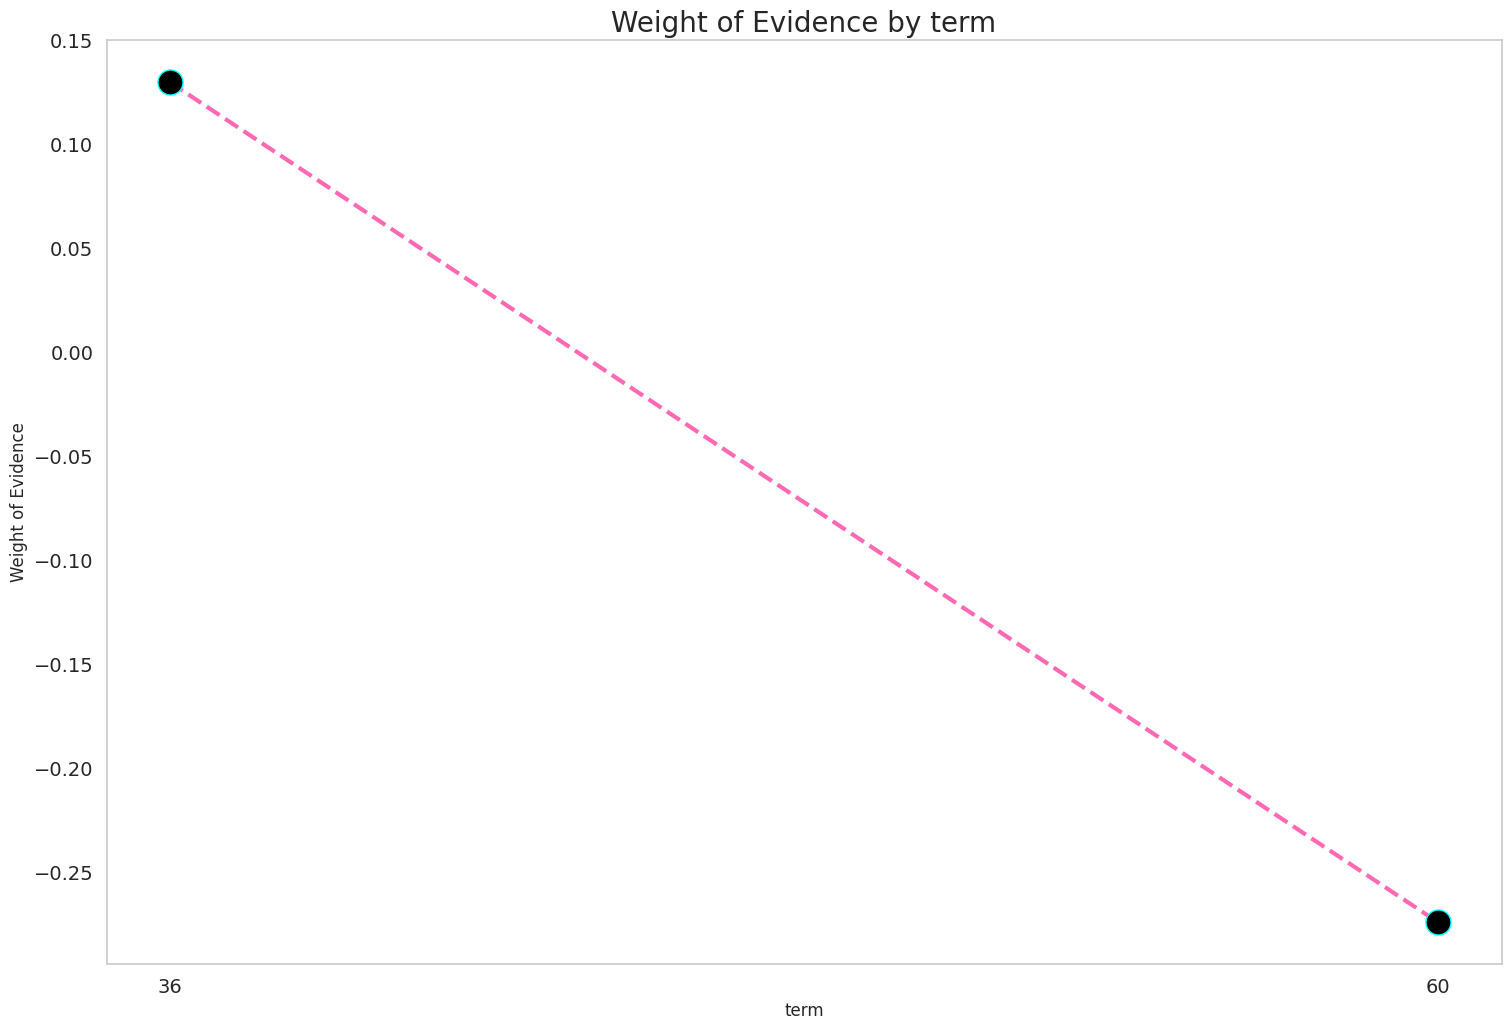

In [50]:
plot_by_woe(woe_continous(X,'term', y ))

**2. Analyzing months since issued variable**

In [51]:
X['mths_since_issue_d'].unique()

array([80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90., 91., 92.,
       93., 94., 95., 96., 68., 69., 70., 71., 72., 73., 74., 75., 76.,
       77., 78., 79.])

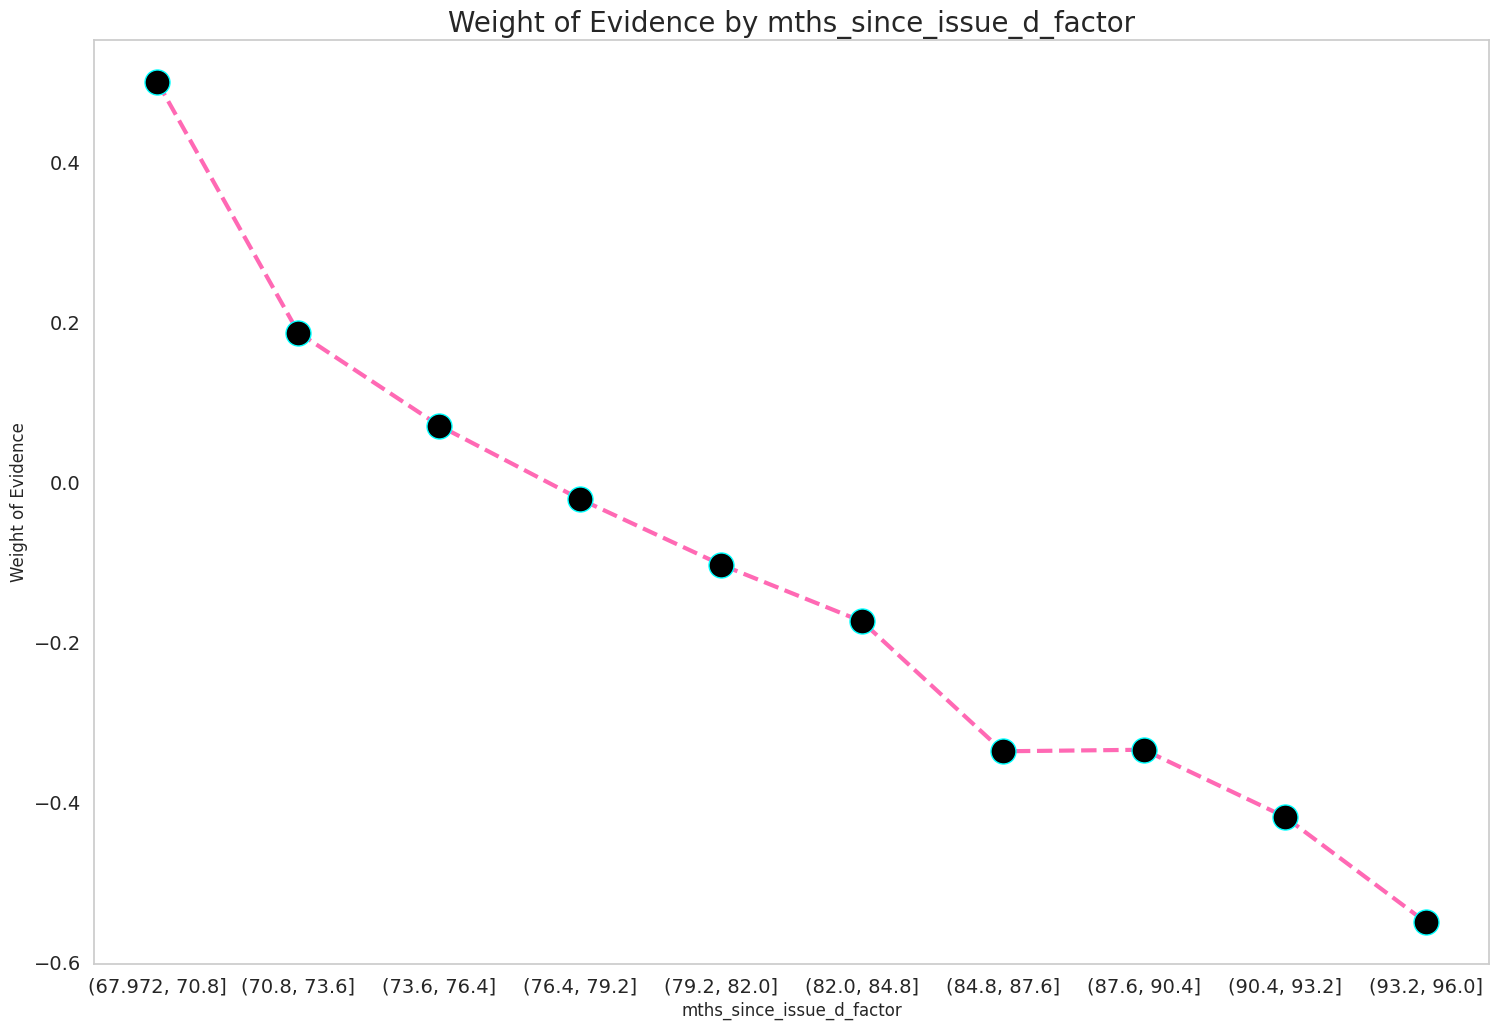

In [52]:
# fine class by creating  a new var

X['mths_since_issue_d_factor'] = pd.cut(X['mths_since_issue_d'], 10)
mths_since_iss_df = woe_continous(X, 'mths_since_issue_d_factor', y)
plot_by_woe(mths_since_iss_df)

The follwing categories will be created based on their WoE and number of observations

- (67.97, 70.8)
- (70.8, 73.6)
- (73.6- 76.4)
- (76.4.- 79.2)
- (79.2-82)
- (82-84)
- (84-90.4)
- (90.4-96)

**3. Analyzing interest rate variable**

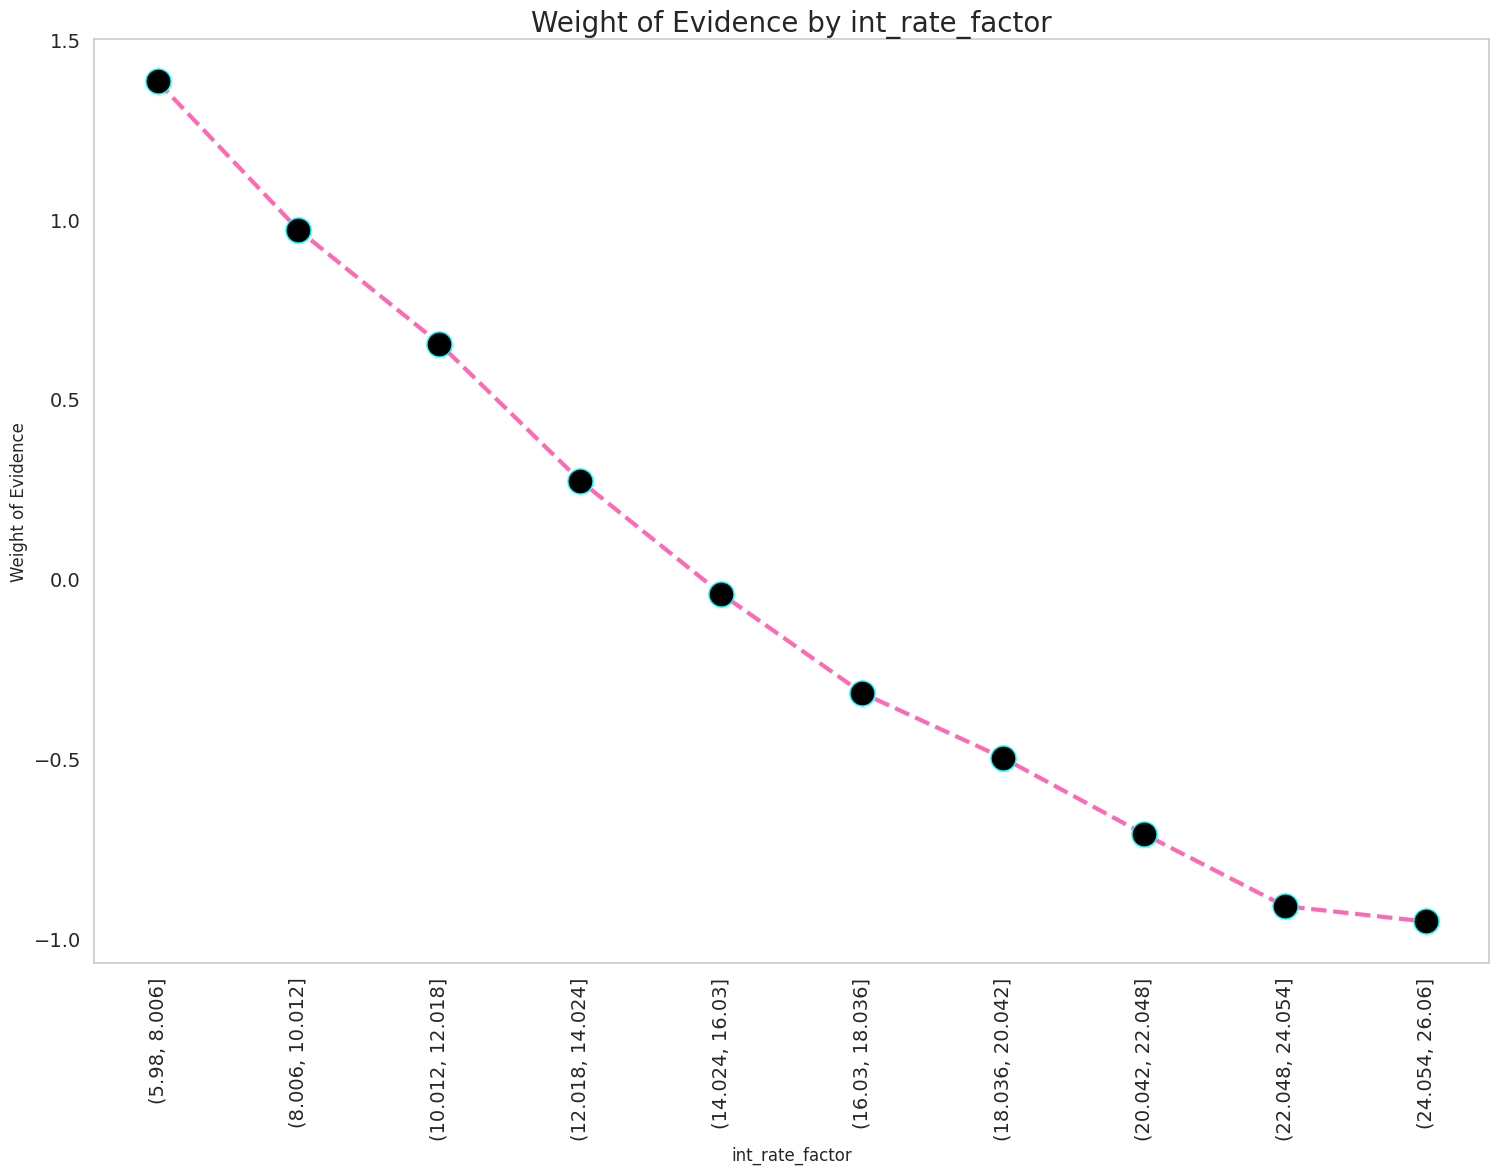

In [53]:
X['int_rate_factor'] = pd.cut(X['int_rate'], 10)
int_rate_df = woe_continous(X, 'int_rate_factor',y)
plot_by_woe(int_rate_df,90)

From the graph above only the last two categories will be combined.

(22.048, 26)

**4. Analyzing total_rec_int variable**

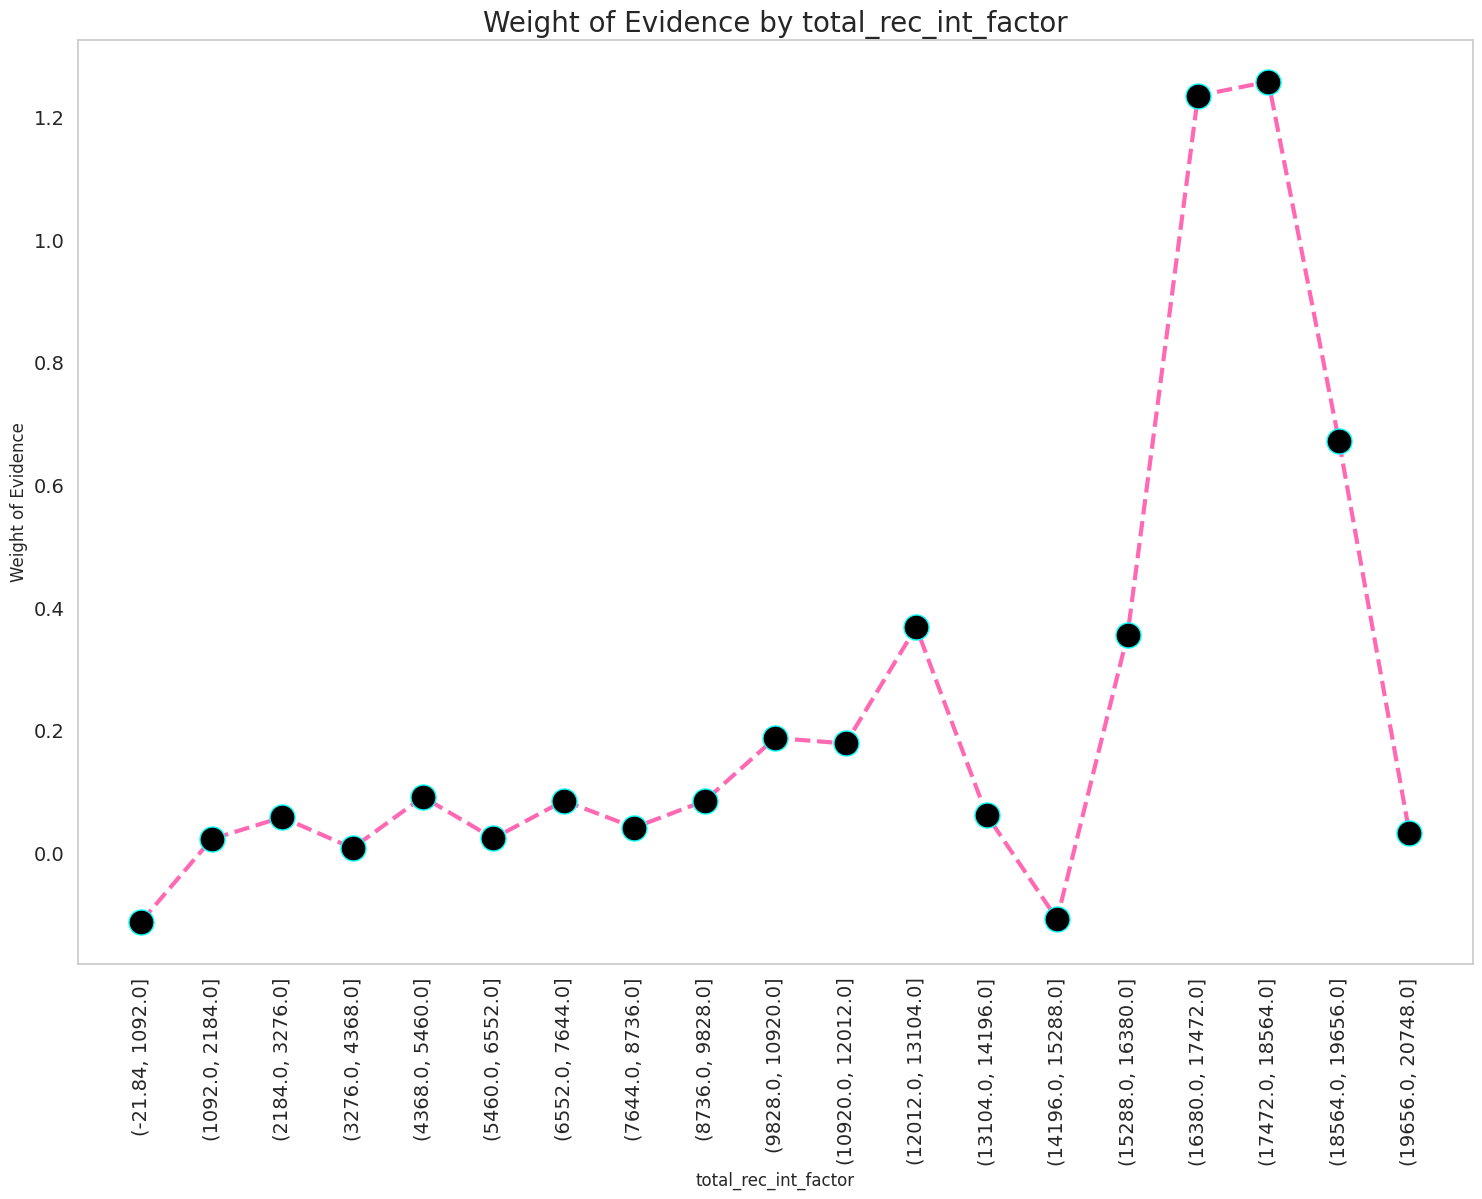

In [54]:
X['total_rec_int_factor'] = pd.cut(X['total_rec_int'], 20)
rec_int_df = woe_continous(X, 'total_rec_int_factor', y)
plot_by_woe(rec_int_df, 90)

**5. Analyzing toal revolving_high_limit variable**

In [55]:
X['total_rev_hi_lim_factor'] = pd.cut(X['total_rev_hi_lim'], 100)
revol_hi_df = woe_continous(X, 'total_rev_hi_lim_factor', y)
# plot_by_woe(revol_hi_df, 90)

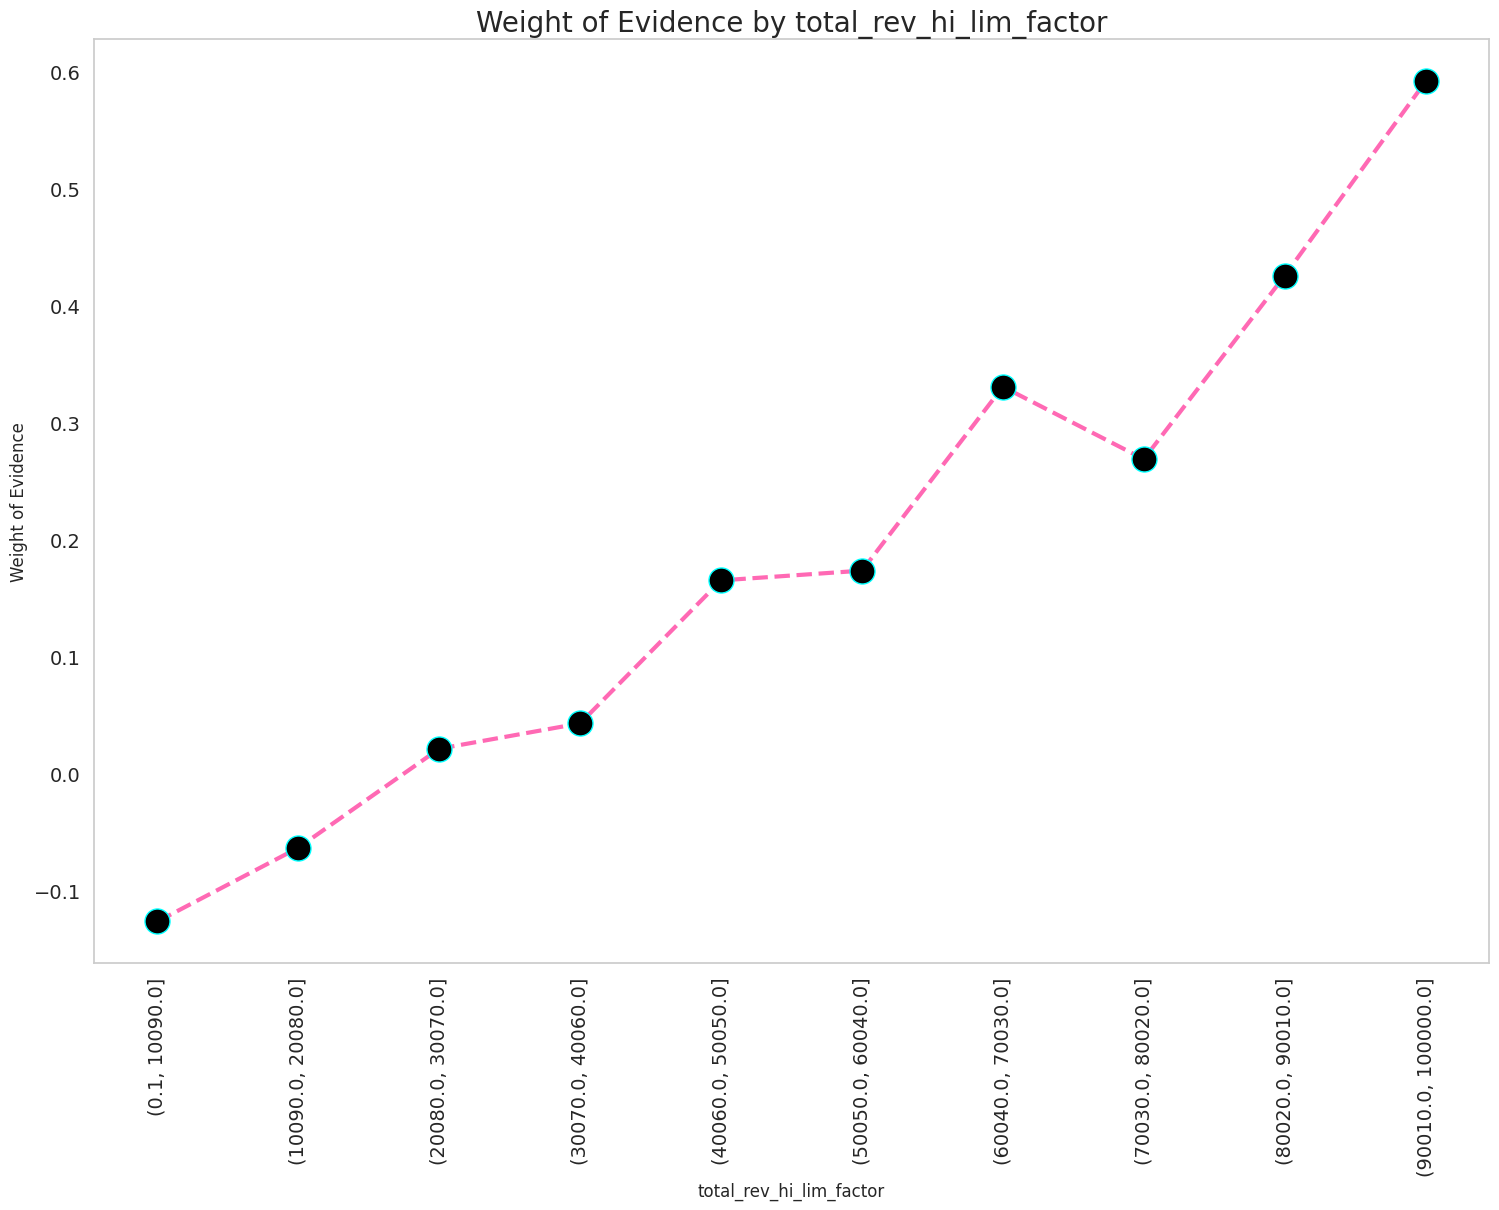

In [56]:
#analyzing below 100000
X_train_prepr_temp = X[X['total_rev_hi_lim'] <= 100000].copy()
# fine-classing
X_train_prepr_temp['total_rev_hi_lim_factor'] = pd.cut(X_train_prepr_temp['total_rev_hi_lim'],10)
# select only the relevant index in the target col
df_temp = woe_continous(X_train_prepr_temp, 'total_rev_hi_lim_factor', y[X_train_prepr_temp.index])
plot_by_woe(df_temp, 90)

**6. Analyzing total_payment variable**

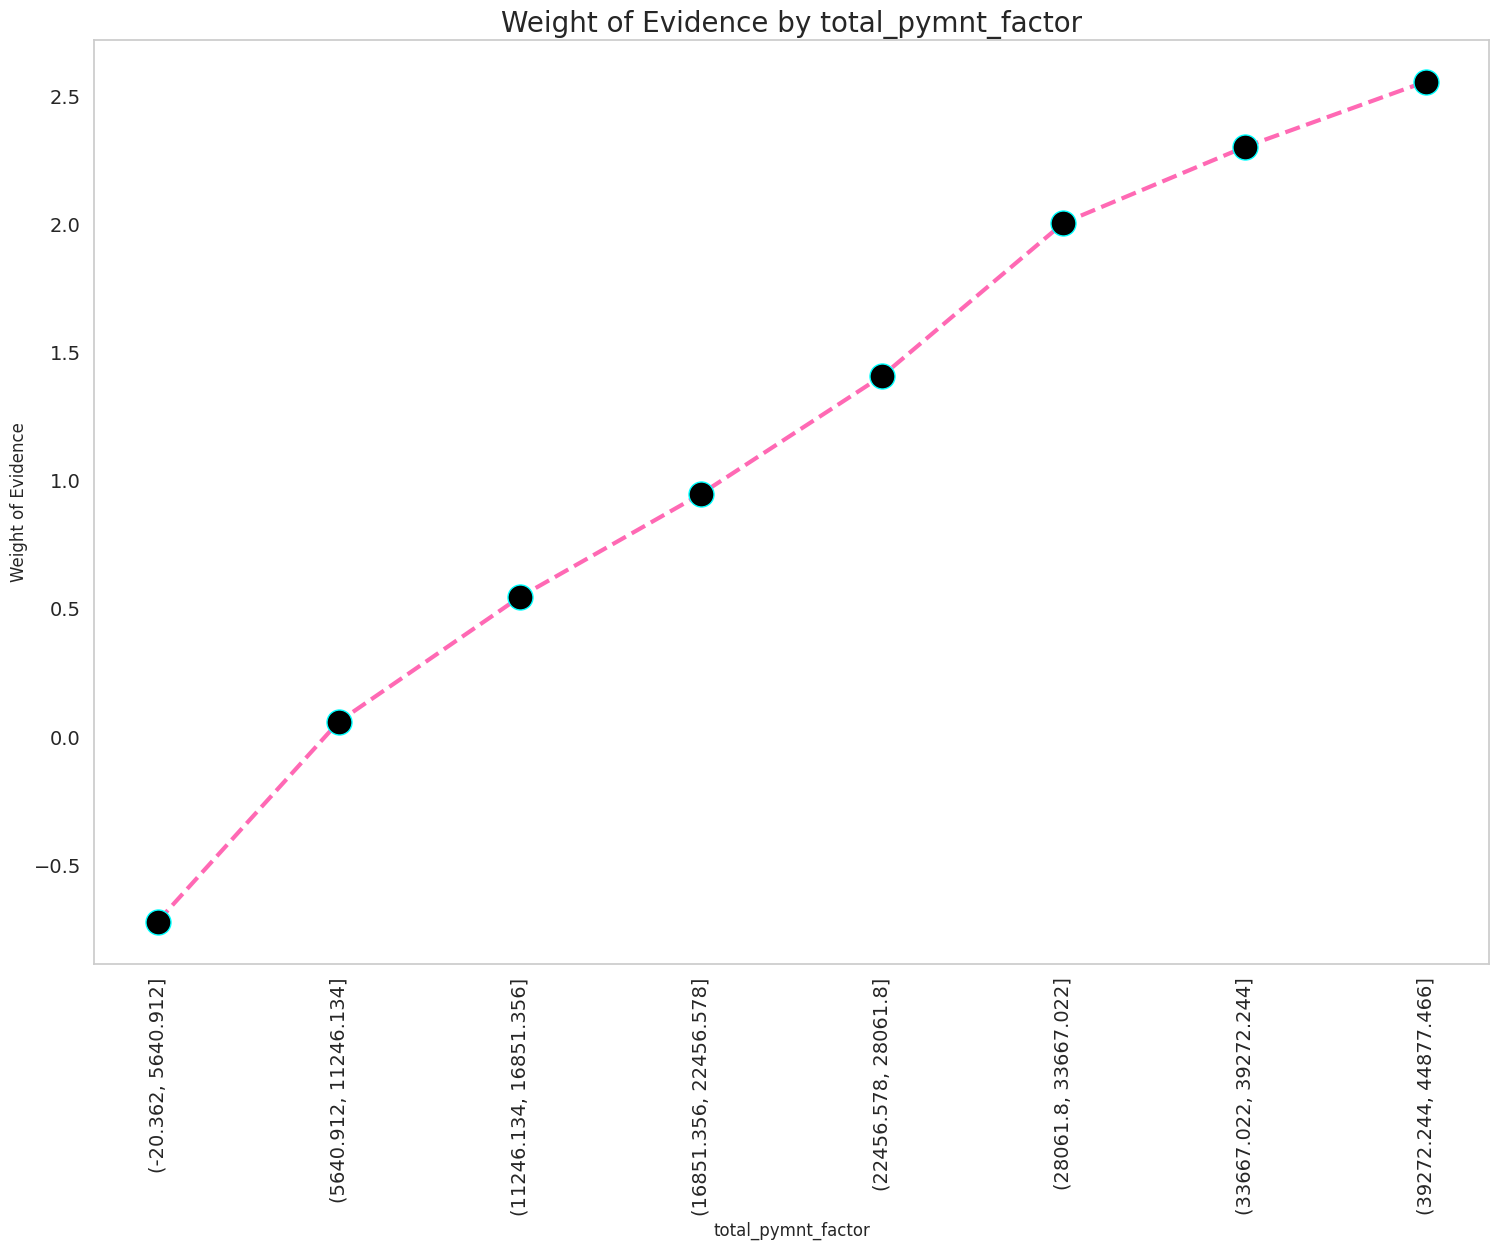

In [57]:
X['total_pymnt_factor'] = pd.cut(X['total_pymnt'], 10)
total_pym_df = woe_continous(X, 'total_pymnt_factor', y)
plot_by_woe(total_pym_df,90)

**7. Analyzing dti variable**

"dti" is a ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

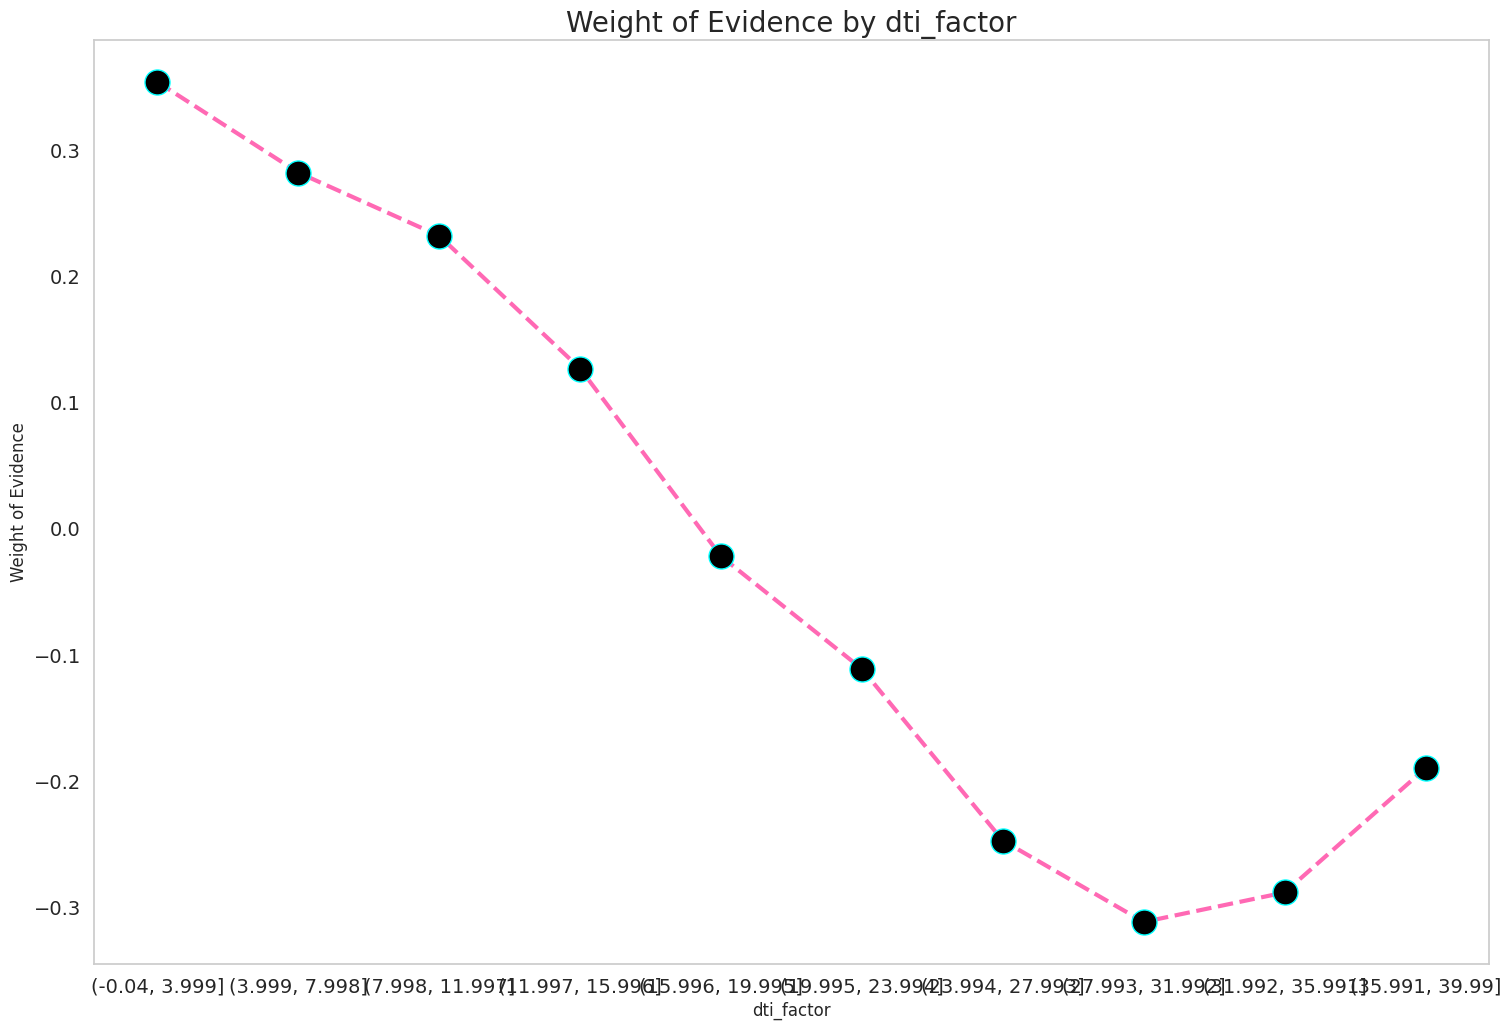

In [58]:
X['dti_factor'] = pd.cut(X['dti'], 10)
dti_df = woe_continous(X, 'dti_factor', y)
plot_by_woe(dti_df)

The following categories will be combined:

(27.993, 31.992), (31.992, 35.991), (35.991, 39.99)

**8. Analyzing annual_income variable**

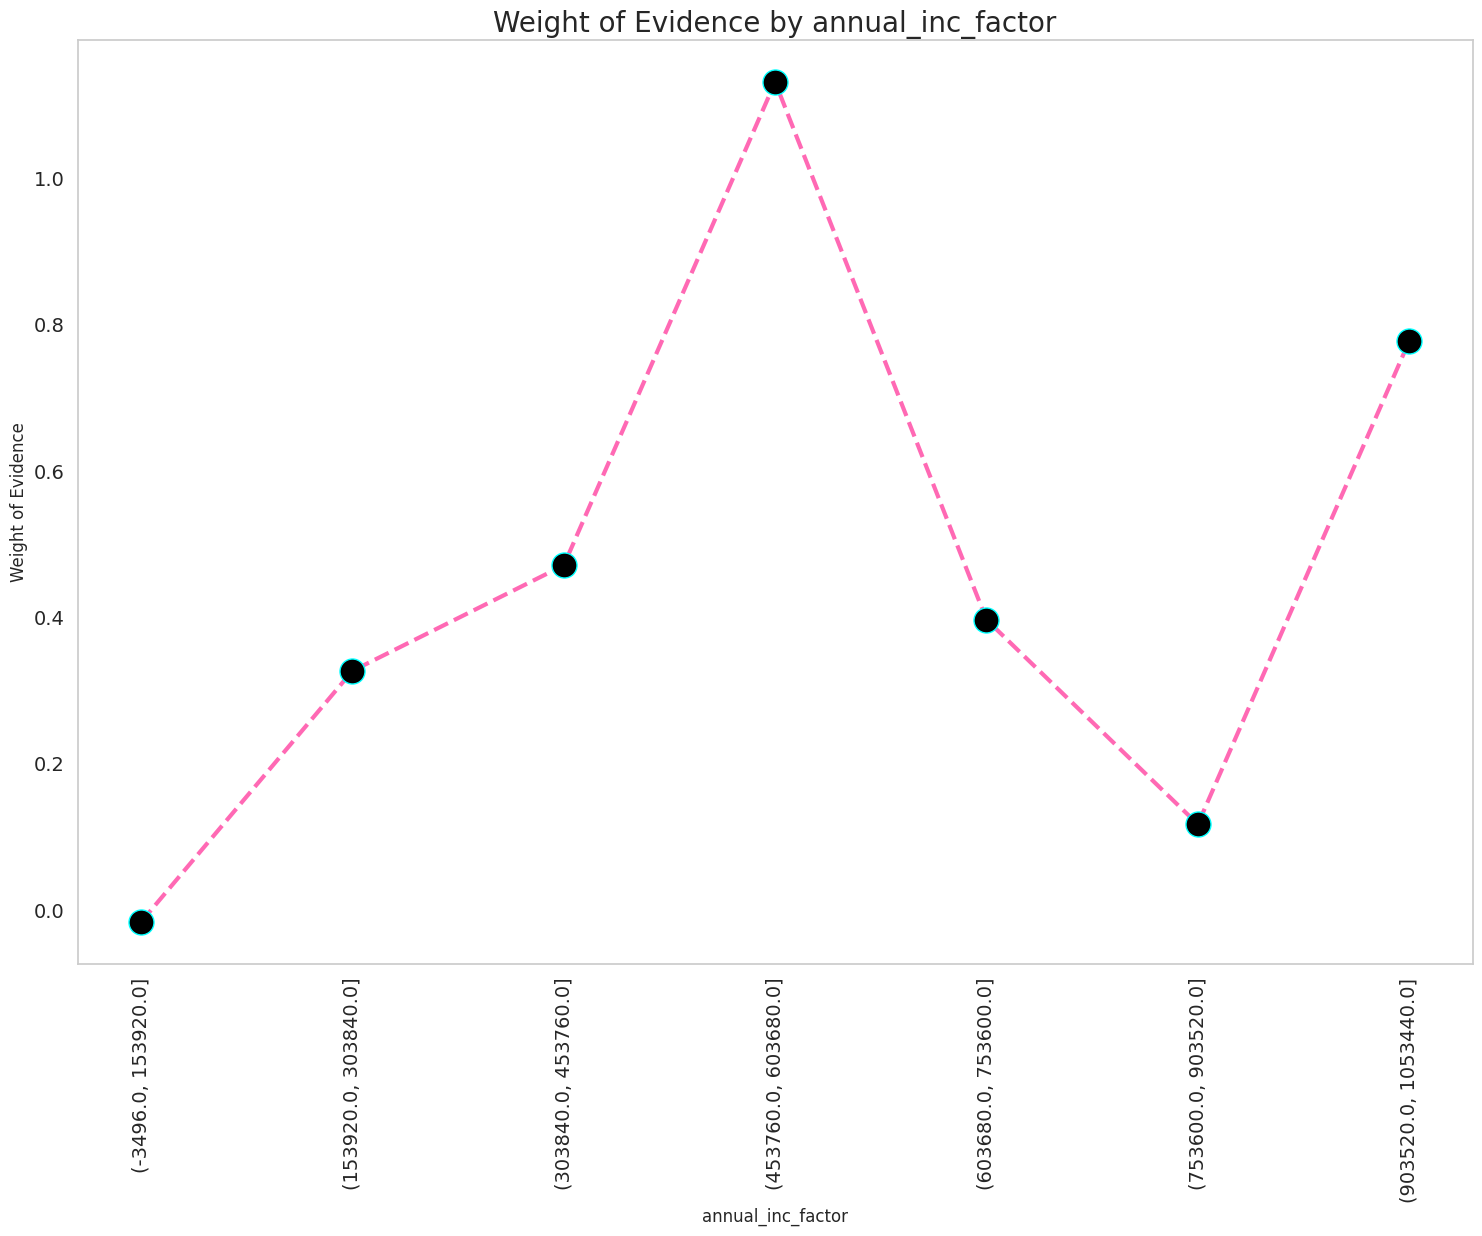

In [59]:
X['annual_inc_factor'] = pd.cut(X['annual_inc'], 50)
ann_inc_df = woe_continous(X, 'annual_inc_factor', y)
plot_by_woe(ann_inc_df, 90)

We will seperate this variable into people with higher and lower incomes. From the WoE table, we observe, when annual income increases, the the number of observations decreases. This is because only a few people earn high income. We will use a new variable for people with income above 150000 dollars. And also, analyze individuals with income below 150000 dollars.

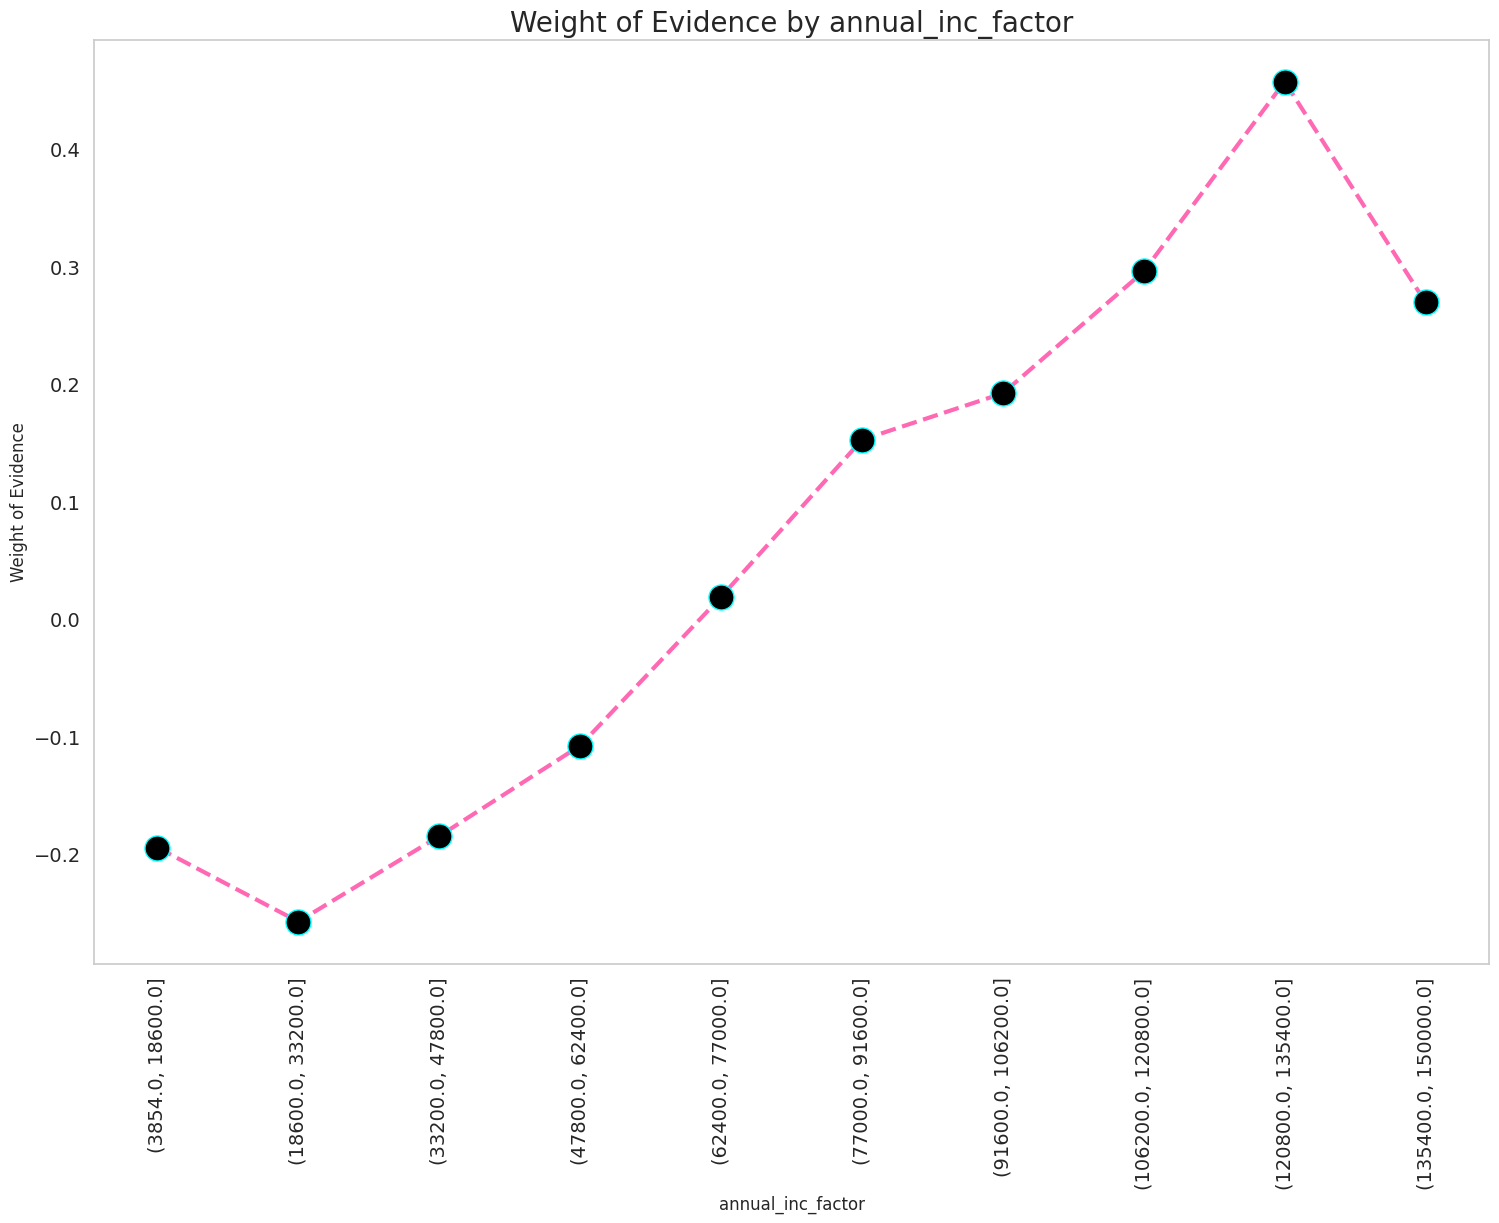

In [60]:
#Analyzing income  below 150000
X_train_prepr_temp = X[X['annual_inc'] <= 150000].copy()
# fine-classing
X_train_prepr_temp['annual_inc_factor'] = pd.cut(X_train_prepr_temp['annual_inc'], 10)
# select only the relevant index in the target col
df_temp = woe_continous(X_train_prepr_temp, 'annual_inc_factor', y[X_train_prepr_temp.index])
plot_by_woe(df_temp, 90)

From the graph, we will combine the follwing categories based on WoE and number of observations as follows:
- (<=32000),
- (>32000 <= 50000),
- (>50000 <= 60000),
- (>60000 <=75000),
- (>75000 <=90000),
- (>90000 <=120000),
- (>120000 <=135000),
- (>135000 <=150000),
- (>150000)

**9. Analyzing inq_last_6mths variable**

inq_last_6mths denote the number of inquiries in last 6 months

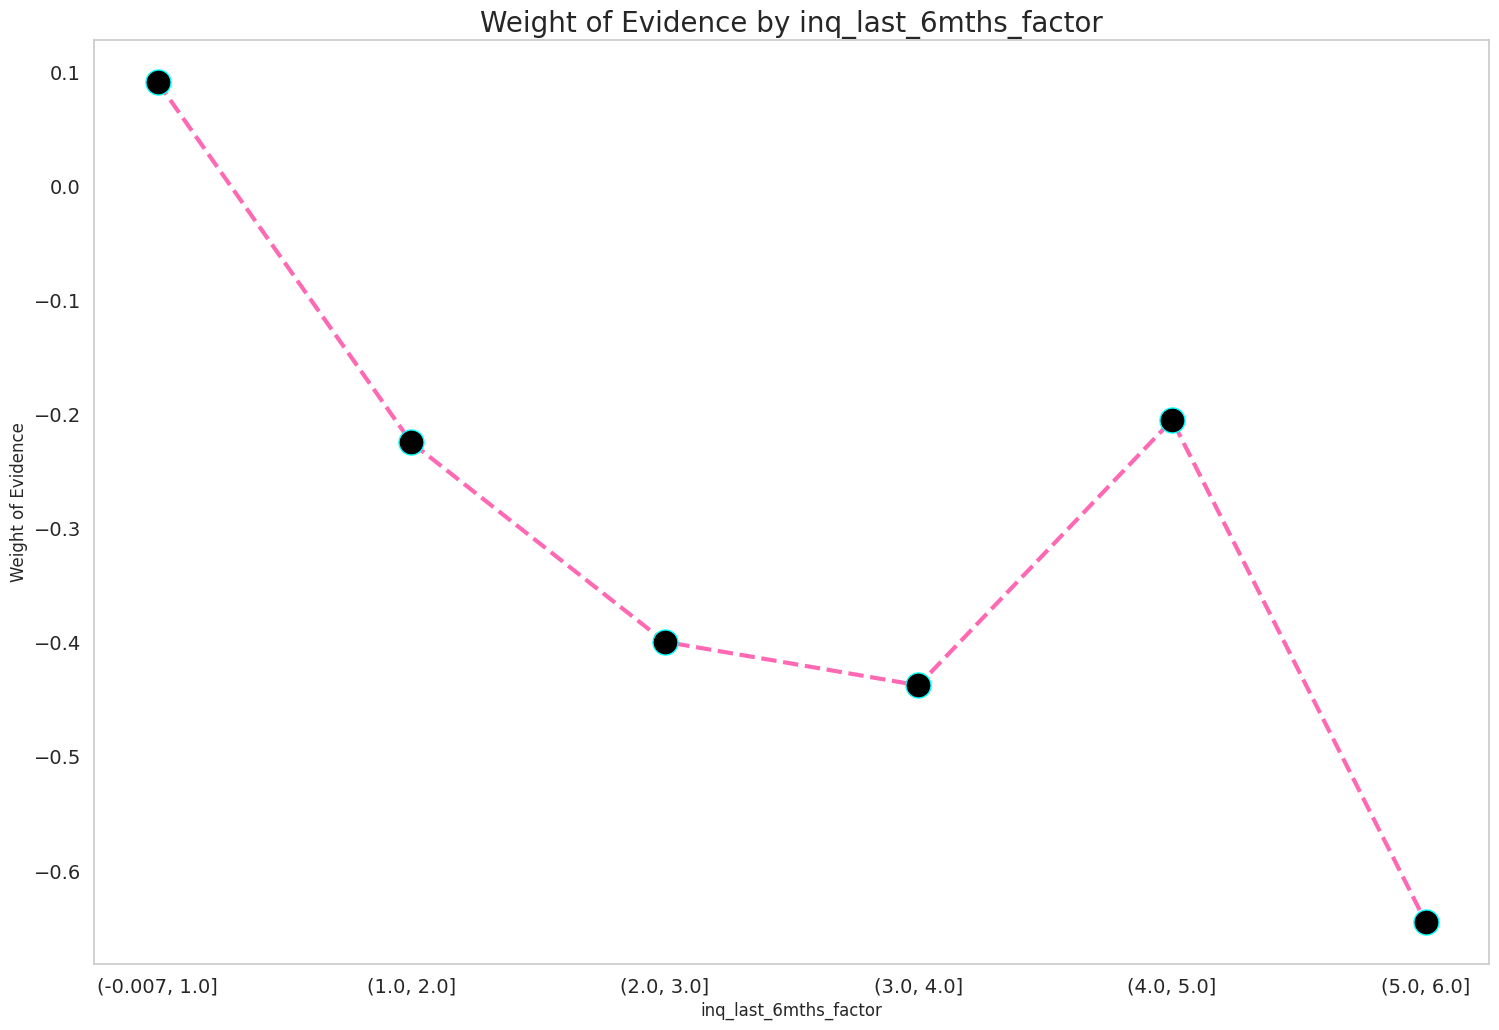

In [61]:
X['inq_last_6mths_factor'] = pd.cut(X['inq_last_6mths'], 7)
inq_fact_df = woe_continous(X, 'inq_last_6mths_factor', y)
plot_by_woe(inq_fact_df)

The follwing categories will be created

- <1 months,
- 1-2,
- 2-4,
- 4-7

**10. Analyzing total current balance variable**

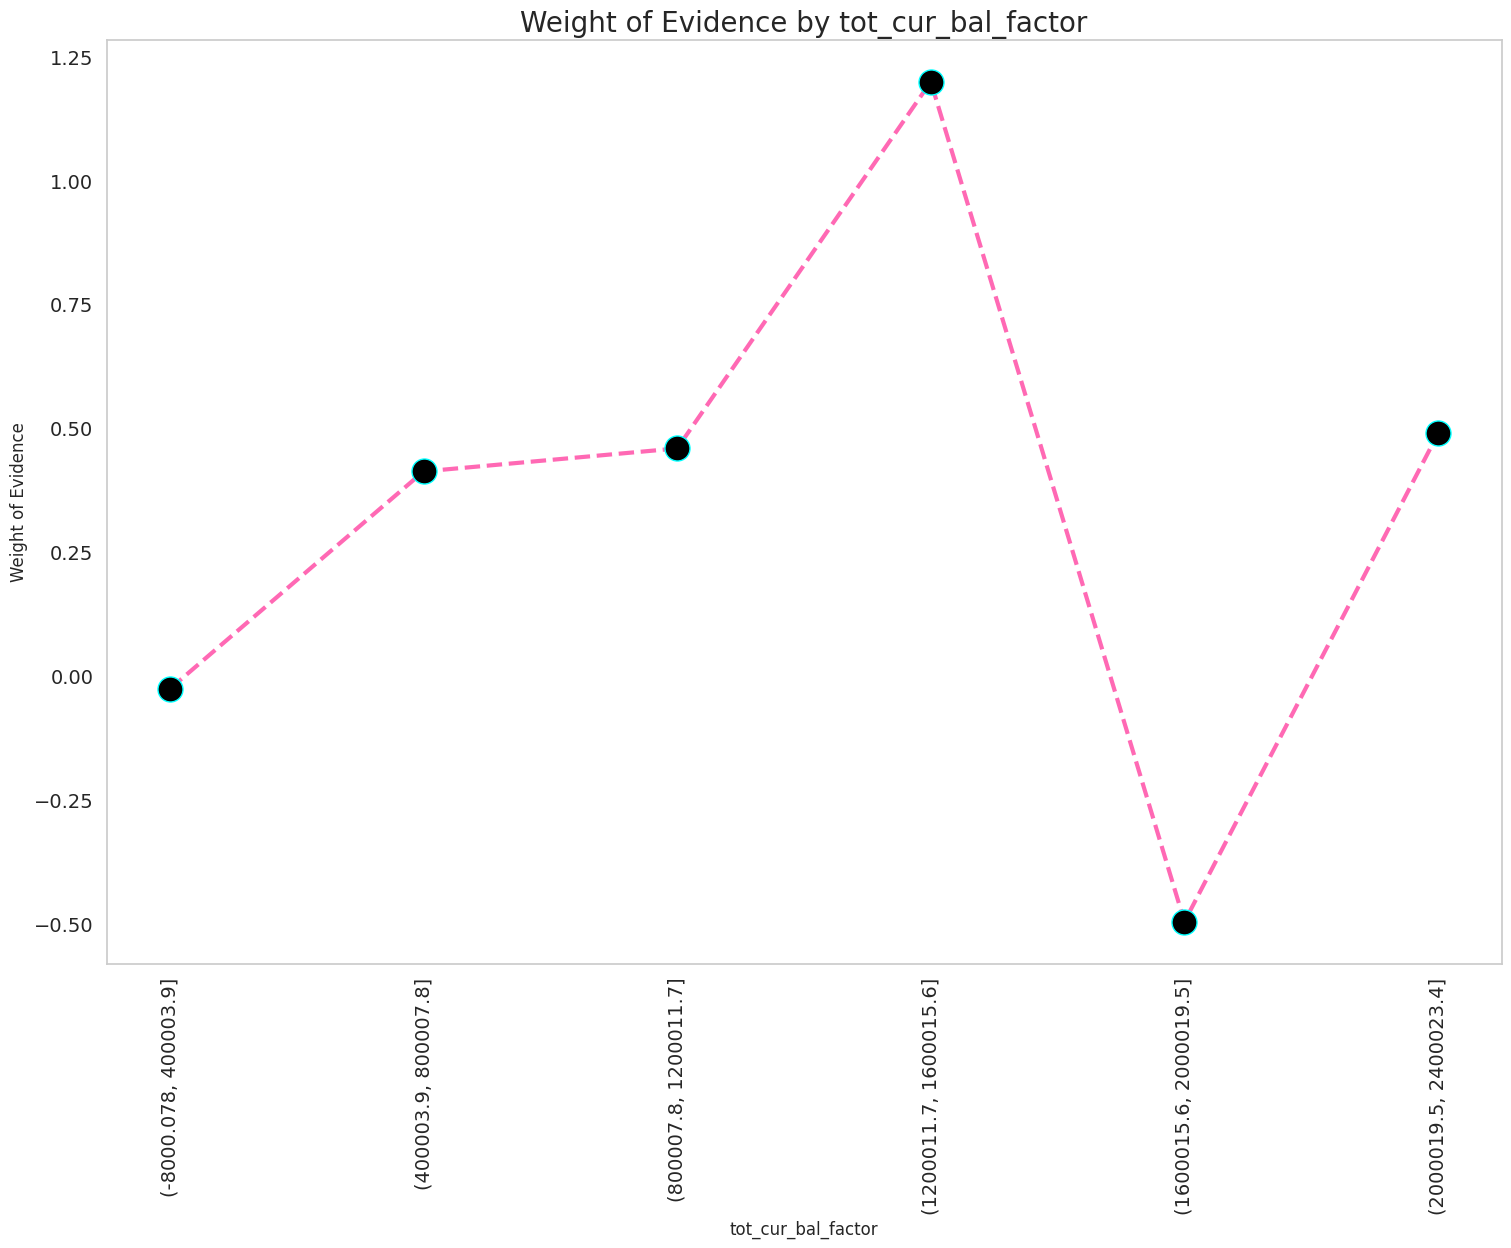

In [62]:
X['tot_cur_bal_factor'] = pd.cut(X['tot_cur_bal'], 20)
curr_bal_df = woe_continous(X, 'tot_cur_bal_factor', y)
plot_by_woe(curr_bal_df, 90)

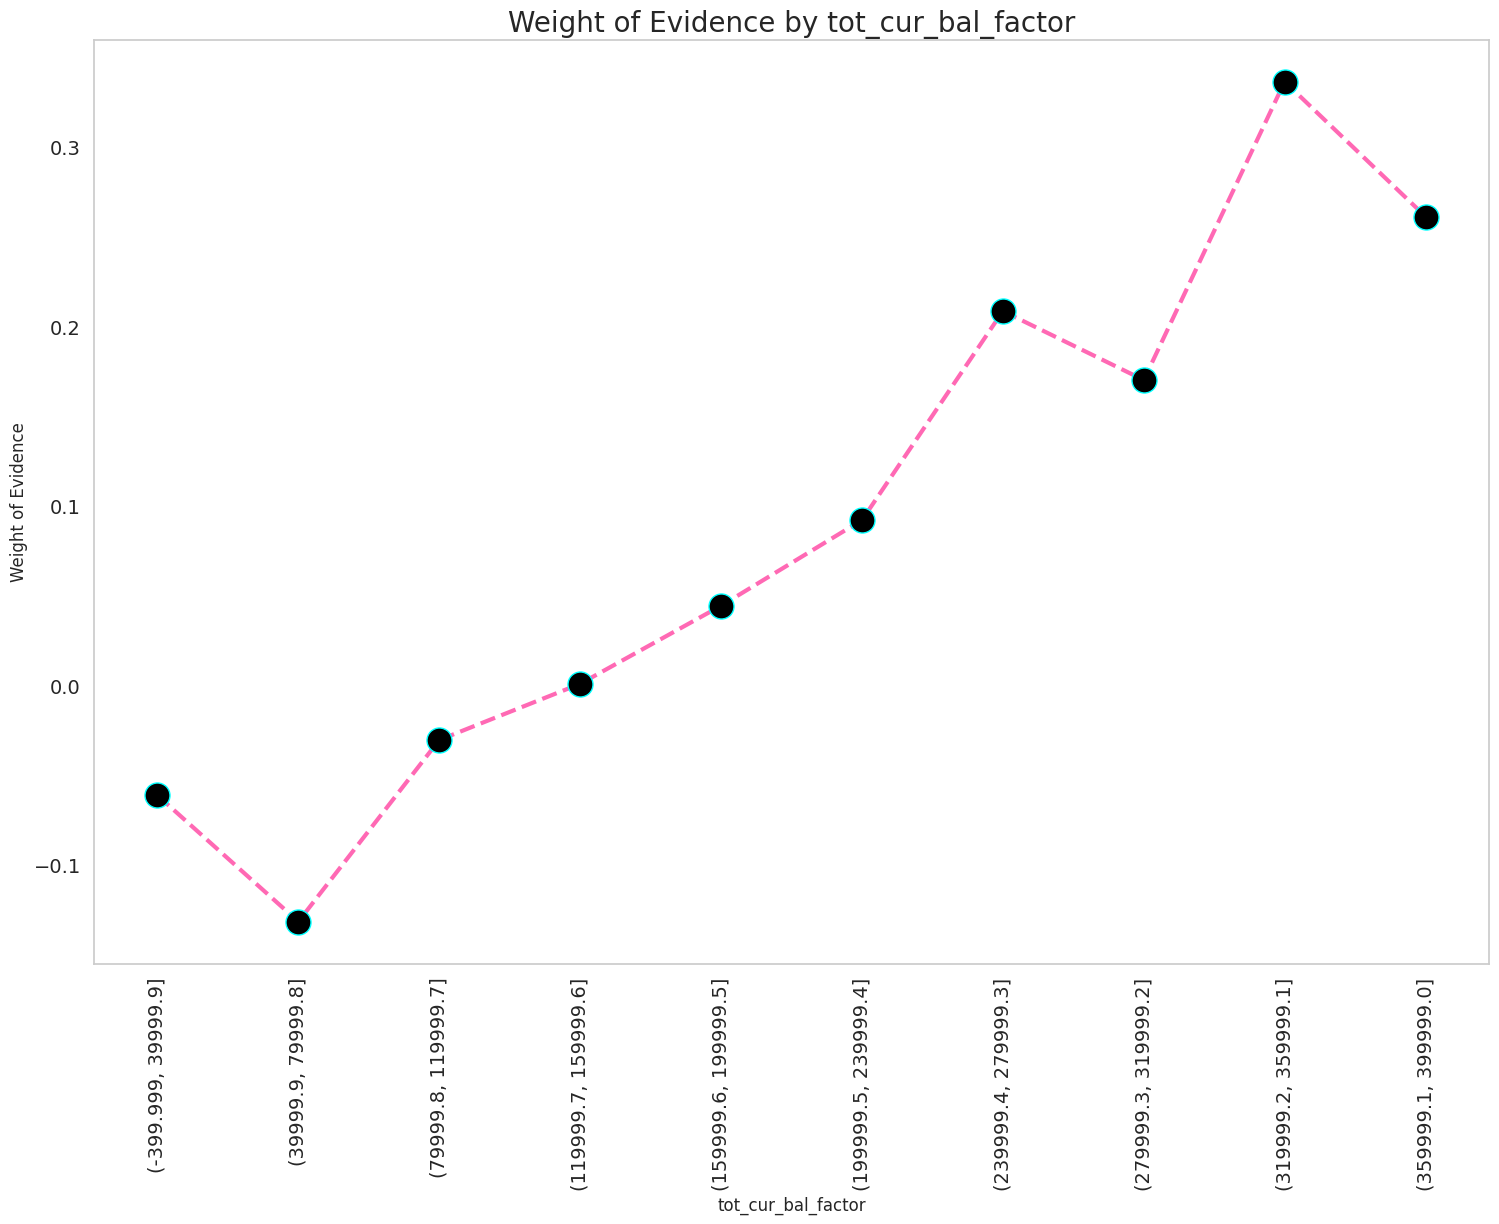

In [63]:
#Analyzing current balance  below 400000
X_train_prepr_temp = X[X['tot_cur_bal'] <= 400000].copy()
# fine-classing
X_train_prepr_temp['tot_cur_bal_factor'] = pd.cut(X_train_prepr_temp['tot_cur_bal'], 10)
# select only the relevant index in the target column
df_temp = woe_continous(X_train_prepr_temp, 'tot_cur_bal_factor', y[X_train_prepr_temp.index])
plot_by_woe(df_temp, 90)

the following variables will be created:
- <40000,
- 40000-80000,
- 80000-120000,
- 120000-160000,
- 160000-200000,
- 200000-240000,
- 240000-320000,
- 320000-400000

**11. Analyzing months since credit pulled variable**

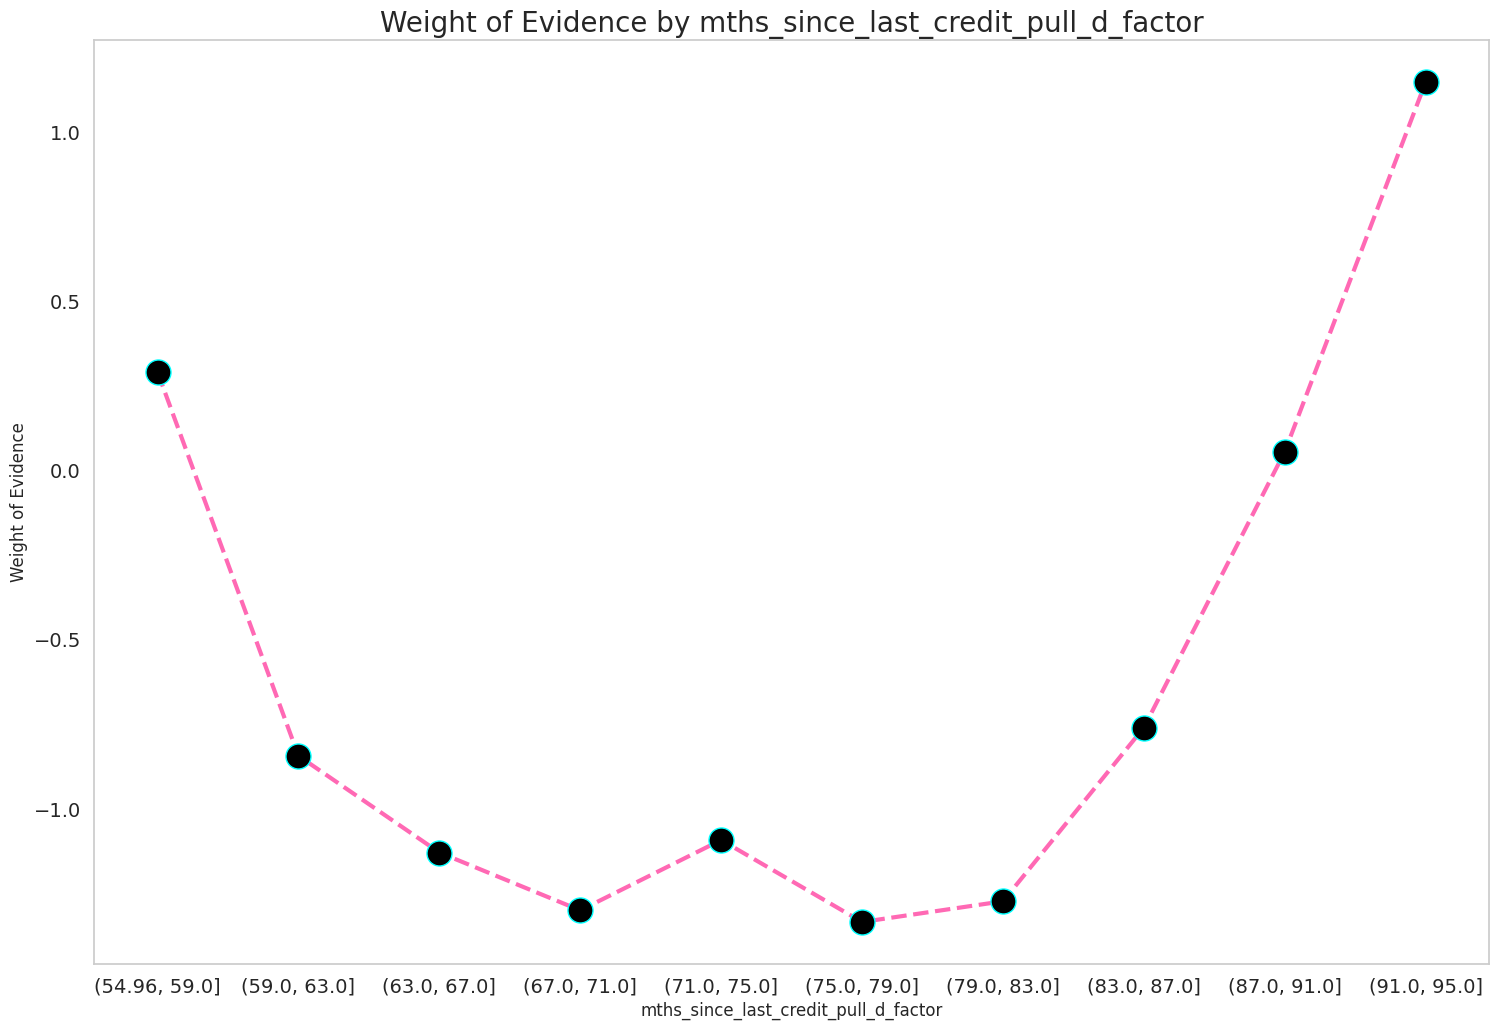

In [64]:
X['mths_since_last_credit_pull_d_factor'] = pd.cut(X['mths_since_last_credit_pull_d'], 10)
mths_cr_pull_df = woe_continous(X, 'mths_since_last_credit_pull_d_factor', y)
plot_by_woe(mths_cr_pull_df)

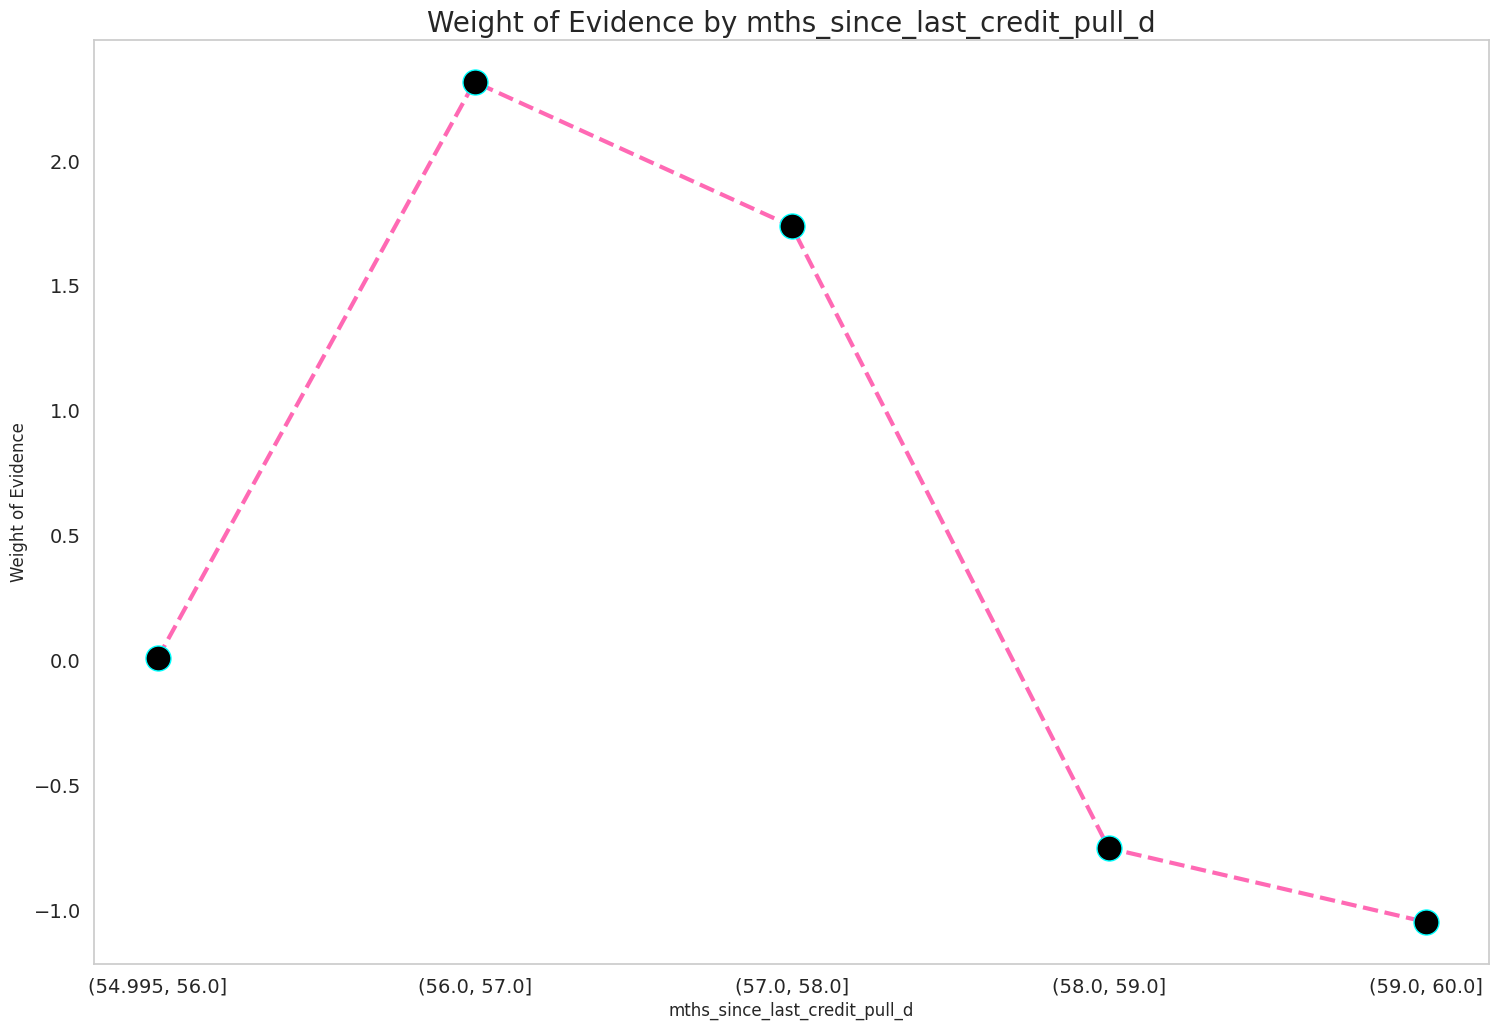

In [65]:
#Analyzing mths_since_credit_pull  below 60
X_train_prepr_temp = X[X['mths_since_last_credit_pull_d'] <= 60].copy()
# fine-classing
X_train_prepr_temp['mths_since_last_credit_pull_d'] = pd.cut(X_train_prepr_temp['mths_since_last_credit_pull_d'], 5)
# select only the relevant index in the target column
df_temp = woe_continous(X_train_prepr_temp, 'mths_since_last_credit_pull_d', y[X_train_prepr_temp.index])
plot_by_woe(df_temp)

The following categories will be grouped together:
- 54-65,
- 65-76,
- greater than 76

**12. Analyzing out_prncp_factor variable**

"out_prncp_factor" denotes remaining outstanding principal for total amount funded

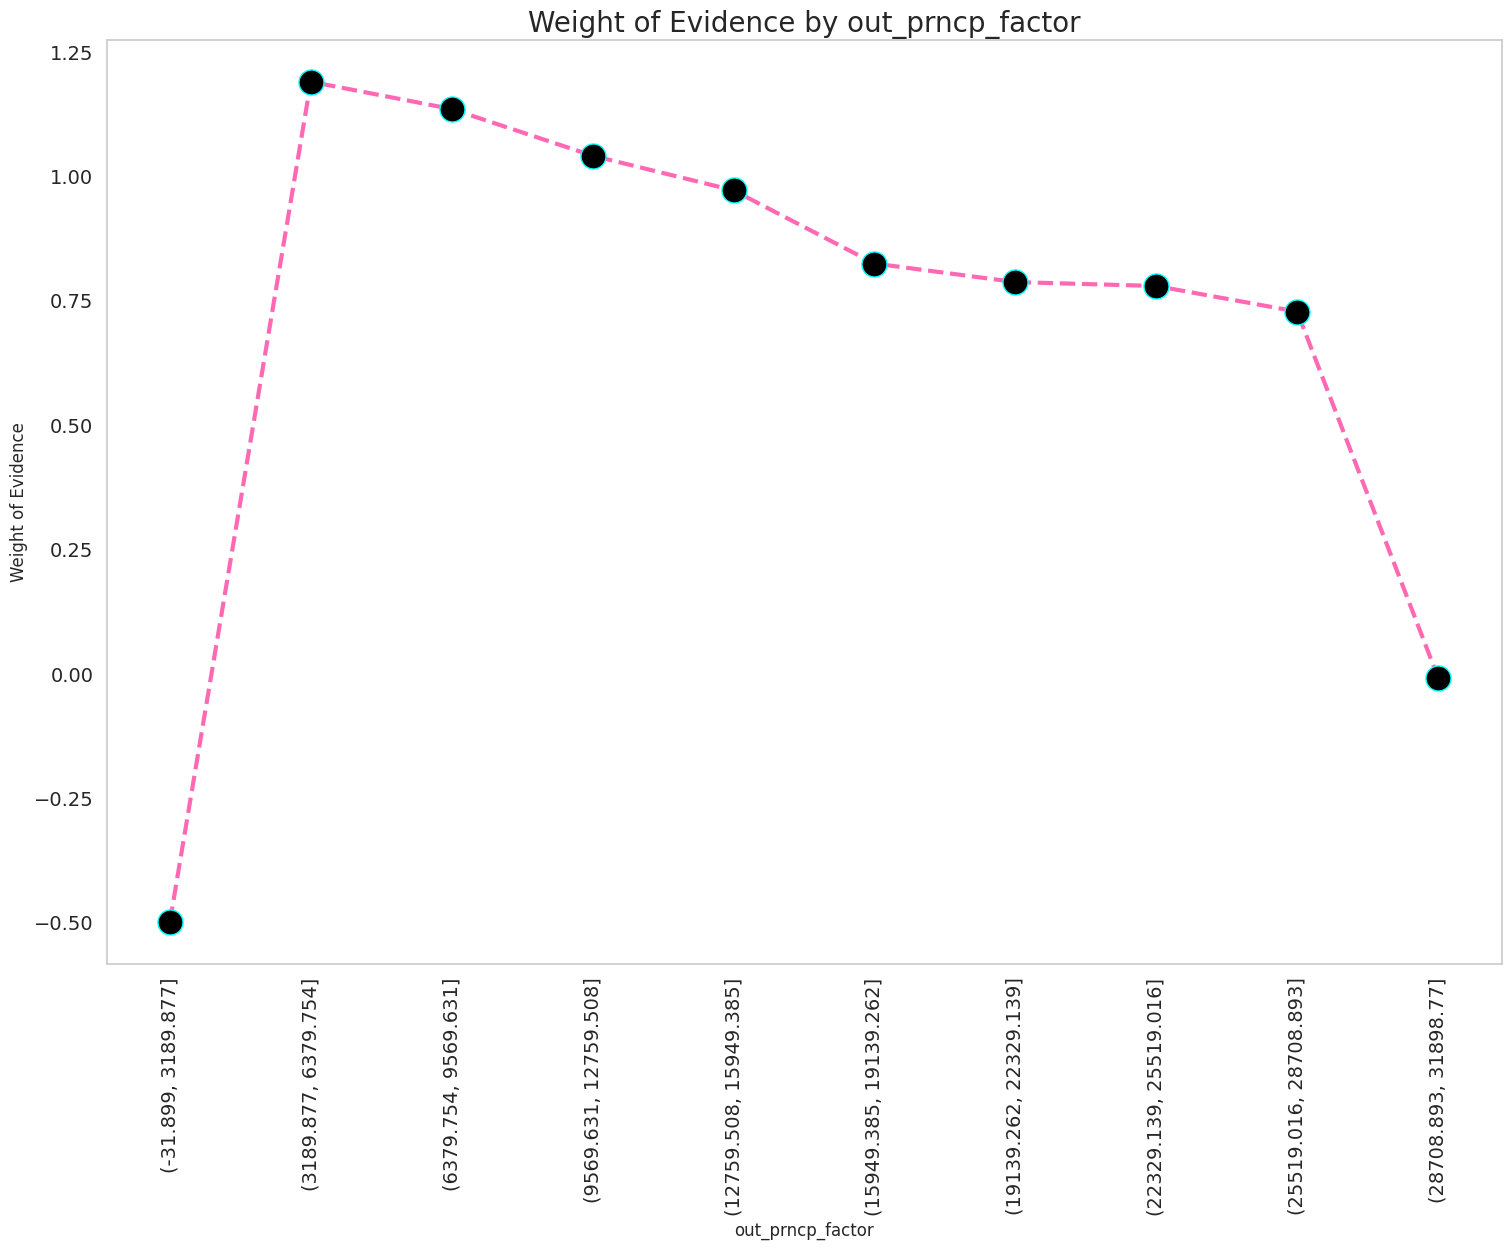

In [66]:
X['out_prncp_factor'] = pd.cut(X['out_prncp'], 10)
out_df = woe_continous(X, 'out_prncp_factor', y)
plot_by_woe(out_df, 90)

**13. Analyzing months_since_issue_date variable**

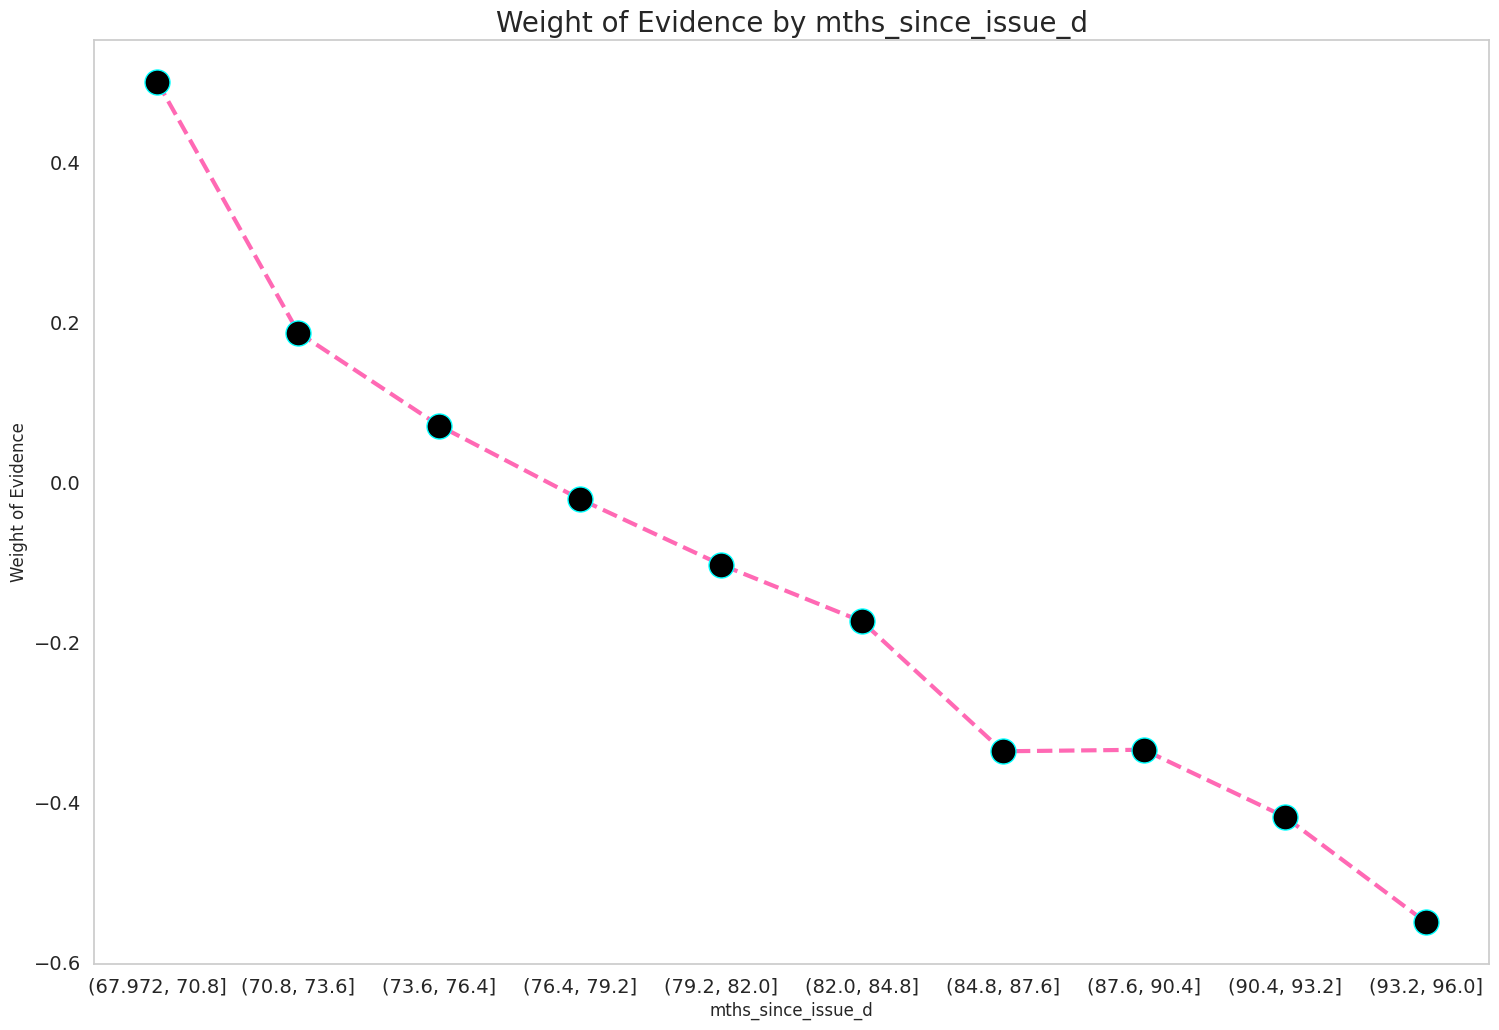

In [67]:
X['mths_since_issue_d'] = pd.cut(X['mths_since_issue_d'], 10)
iss_df = woe_continous(X, 'mths_since_issue_d', y)
plot_by_woe(iss_df)

# Creating New Features Based on WoE

In [68]:
# grade

new_df = preprocess_data.loc[:, 'grade:A':'grade:G']

# home_ownership

new_df['home_ownership:OWN'] = preprocess_data.loc[:, 'home_ownership:OWN']
new_df['home_ownership:OTHER_NONE_RENT_ANY'] = sum([preprocess_data['home_ownership:OTHER'],
                                                    preprocess_data['home_ownership:NONE'],
                                                    preprocess_data['home_ownership:RENT'],
                                                    preprocess_data['home_ownership:ANY']])
new_df['home_ownership:MORTGAGE'] = preprocess_data.loc[:, 'home_ownership:MORTGAGE']

#verification status
new_df['verification_status:NOT_VERIFIED'] = preprocess_data.loc[:, 'verification_status:Not Verified']
new_df['verification_status:SOURCE_VERIFIED'] = preprocess_data.loc[:, 'verification_status:Source Verified']
new_df['verification_status:VERIFIED'] = preprocess_data.loc[:, 'verification_status:Verified']

# purpose of loan
new_df['purpose:SMALL_BUSINESS_EDUCATIONAL_RENEWABLE_ENERGY_MOVING'] = sum([preprocess_data['purpose:small_business'],  preprocess_data['purpose:renewable_energy'], preprocess_data['purpose:moving']])
new_df['purpose:OTHER_HOUSE_MEDICAL'] =sum([preprocess_data['purpose:other'], preprocess_data['purpose:house'], preprocess_data['purpose:medical']])
new_df ['purpose:WEDDING_VACATION'] = sum([preprocess_data['purpose:wedding'], preprocess_data['purpose:vacation']])
new_df ['purpose:HOME_IMPROVEMENT_MAJOR_PURCHASE'] = sum([preprocess_data['purpose:home_improvement'], preprocess_data['purpose:major_purchase']])
new_df ['purpose:CAR_CREDIT_CARD'] = sum([preprocess_data['purpose:car'], preprocess_data['purpose:credit_card']])


# addr state
new_df['addr_state:NE_IA_NV_HI_FL_AL'] =sum([preprocess_data['addr_state:IA'],preprocess_data['addr_state:NV'],
                                             preprocess_data['addr_state:HI'],preprocess_data['addr_state:FL'],
                                             preprocess_data['addr_state:AL']])
new_df['addr_state:NY'] = preprocess_data.loc[:, 'addr_state:NY']
new_df['addr_state:LA_NM_OK_NC_MO_MD_NJ_VA'] = sum([preprocess_data['addr_state:LA'],preprocess_data['addr_state:NM'],preprocess_data['addr_state:OK'],
                                                    preprocess_data['addr_state:NC'],preprocess_data['addr_state:MO'],preprocess_data['addr_state:MD'], preprocess_data['addr_state:NJ'],
                                                    preprocess_data['addr_state:VA']])
new_df['addr_state:CA'] = preprocess_data.loc[:,'addr_state:CA']
new_df['addr_state:AZ_MI_UT_TN_AR_PA'] =sum([preprocess_data['addr_state:AZ'],preprocess_data['addr_state:MI'],preprocess_data['addr_state:UT'],
preprocess_data['addr_state:TN'],preprocess_data['addr_state:AR'],preprocess_data['addr_state:PA']])

new_df['addr_state:RI_OH_KY_DE_MN_SD_MA_IN'] =sum([preprocess_data['addr_state:RI'],preprocess_data['addr_state:OH'],preprocess_data['addr_state:KY'],
                                                   preprocess_data['addr_state:DE'],preprocess_data['addr_state:MN'],preprocess_data['addr_state:SD'],preprocess_data['addr_state:MA'],
                                                   preprocess_data['addr_state:IN']])

new_df['addr_state:GA_WA'] = sum([preprocess_data['addr_state:GA'], preprocess_data['addr_state:WA']])
new_df['addr_state:WI_OR'] = sum([preprocess_data['addr_state:WI'], preprocess_data['addr_state:OR']])
new_df['addr_state:TX'] = preprocess_data.loc[:,'addr_state:TX']
new_df['addr_state:IL_CT_MT'] =sum([preprocess_data['addr_state:IL'],preprocess_data['addr_state:CT'],preprocess_data['addr_state:MT']])
new_df['addr_state:CO_SC'] = sum([preprocess_data['addr_state:CO'], preprocess_data['addr_state:SC']])
new_df['addr_state:KS_VT_AK_NS'] =sum([preprocess_data['addr_state:KS'],preprocess_data['addr_state:VT'],preprocess_data['addr_state:AK'],
                                           preprocess_data['addr_state:MS']])
new_df['addr_state:NH_WV_WY_DC'] =sum([preprocess_data['addr_state:NH'],preprocess_data['addr_state:WV'],preprocess_data['addr_state:WY'],
                                           preprocess_data['addr_state:DC']])
#initial_list_status
new_df['initial_list_status:F'] = preprocess_data.loc[:, 'initial_list_status:f']
new_df['initial_list_status:W'] = preprocess_data.loc[:, 'initial_list_status:w']

# term
new_df['term:36'] = np.where((preprocess_data['term'] == 36), 1, 0)
new_df['term:60'] = np.where((preprocess_data['term']==60), 1,0)

#total_rec_int
new_df['total_rec_int:<1000'] = np.where((preprocess_data['total_rec_int']<=1000), 1,0)
new_df['total_rec_int:1000-2000'] = np.where((preprocess_data['total_rec_int']>1000) &(preprocess_data['total_rec_int']<=2000), 1,0)
new_df['total_rec_int:2000-9000'] = np.where((preprocess_data['total_rec_int']>2000) &(preprocess_data['total_rec_int']<=9000), 1,0)
new_df['total_rec_int:>9000'] = np.where((preprocess_data['total_rec_int']>9000), 1,0)


#total_revol_hi_lim
new_df['total_rev_hi_lim:<10000'] =np.where((preprocess_data['total_rev_hi_lim']<=10000),1,0)
new_df['total_rev_hi_lim:10000-20000'] =np.where((preprocess_data['total_rev_hi_lim']>10000)&(preprocess_data['total_rev_hi_lim']<=20000),1,0)
new_df['total_rev_hi_lim:20000-40000'] =np.where((preprocess_data['total_rev_hi_lim']>20000)&(preprocess_data['total_rev_hi_lim']<=40000),1,0)
new_df['total_rev_hi_lim:40000-60000'] =np.where((preprocess_data['total_rev_hi_lim']>40000)&(preprocess_data['total_rev_hi_lim']<=60000),1,0)
new_df['total_rev_hi_lim:60000-80000'] =np.where((preprocess_data['total_rev_hi_lim']>60000)&(preprocess_data['total_rev_hi_lim']<=80000),1,0)
new_df['total_rev_hi_lim:80000-100000'] =np.where((preprocess_data['total_rev_hi_lim']>80000)&(preprocess_data['total_rev_hi_lim']<=100000),1,0)
new_df['total_rev_hi_lim:<100000'] =np.where((preprocess_data['total_rev_hi_lim']>100000),1,0)


#total_pymnt
new_df['total_pymnt:<5000'] = np.where((preprocess_data['total_pymnt']<=5000), 1,0)
new_df['total_pymnt:5000-11000'] = np.where((preprocess_data['total_pymnt']>5000)&(preprocess_data['total_pymnt']<=11000),1,0)
new_df['total_pymnt:11000-16000'] = np.where((preprocess_data['total_pymnt']>11000)&(preprocess_data['total_pymnt']<=16000),1,0)
new_df['total_pymnt:16000-22000'] = np.where((preprocess_data['total_pymnt']>16000)&(preprocess_data['total_pymnt']<=22000),1,0)
new_df['total_pymnt:>22000'] = np.where((preprocess_data['total_pymnt']<=5000), 1,0)
#int_Rate

new_df['int_rate:<7.484'] = np.where((preprocess_data['int_rate'] <= 7.484), 1, 0)
new_df['int_rate:7.484-9.548'] = np.where((preprocess_data['int_rate'] > 7.484) & (preprocess_data['int_rate'] <= 9.548), 1, 0)
new_df['int_rate:9.548-11.612'] = np.where((preprocess_data['int_rate'] > 9.548) & (preprocess_data['int_rate'] <= 11.612), 1, 0)
new_df['int_rate:11.612-13.676'] = np.where((preprocess_data['int_rate'] > 11.612) & (preprocess_data['int_rate'] <= 13.676), 1, 0)
new_df['int_rate:13.676-15.74'] = np.where((preprocess_data['int_rate'] > 13.676) & (preprocess_data['int_rate'] <= 15.74), 1, 0)
new_df['int_rate:15.74-17.804'] = np.where((preprocess_data['int_rate'] > 15.74) & (preprocess_data['int_rate'] <= 17.804), 1, 0)
new_df['int_rate:17.804-19.868'] = np.where((preprocess_data['int_rate'] > 17.804) & (preprocess_data['int_rate'] <= 19.868), 1, 0)
new_df['int_rate:7.19.868-21.932'] = np.where((preprocess_data['int_rate'] > 19.868) & (preprocess_data['int_rate'] <= 21.932), 1, 0)
new_df['int_rate:21.932-26.06'] = np.where((preprocess_data['int_rate'] > 21.932) & (preprocess_data['int_rate'] <= 26.06), 1, 0)


#dti
new_df['dti:<4'] = np.where((preprocess_data['dti'] <=4), 1, 0)
new_df['dti:4-8'] = np.where((preprocess_data['dti'] > 4) & (preprocess_data['dti'] <= 8), 1, 0)
new_df['dti:8-12'] = np.where((preprocess_data['dti'] > 8) & (preprocess_data['dti'] <= 12), 1, 0)
new_df['dti:12-16'] = np.where((preprocess_data['dti'] > 12) & (preprocess_data['dti'] <= 16), 1, 0)
new_df['dti:16-20'] = np.where((preprocess_data['dti'] > 16) & (preprocess_data['dti'] <= 20), 1, 0)
new_df['dti:20-23'] = np.where((preprocess_data['dti'] > 20) & (preprocess_data['dti'] <= 23), 1, 0)
new_df['dti:23-27'] = np.where((preprocess_data['dti'] > 23) & (preprocess_data['dti'] <= 27), 1, 0)
new_df['dti:27-40'] = np.where((preprocess_data['dti'] > 27) & (preprocess_data['dti'] <= 40), 1, 0)

#annual income
new_df['annual_inc:<32000'] = np.where((preprocess_data['annual_inc'] <= 32000), 1, 0)
new_df['annual_inc:32000-50000'] = np.where((preprocess_data['annual_inc'] > 32000) & (preprocess_data['annual_inc'] <= 50000),1, 0)
new_df['annual_inc:32000-50000'] = np.where((preprocess_data['annual_inc'] > 32000) & (preprocess_data['annual_inc'] <= 50000), 1, 0)
new_df['annual_inc:50000-60000'] = np.where((preprocess_data['annual_inc'] > 50000) & (preprocess_data['annual_inc'] <= 60000), 1, 0)
new_df['annual_inc:60000-75000'] = np.where((preprocess_data['annual_inc'] > 60000) & (preprocess_data['annual_inc'] <= 75000), 1, 0)
new_df['annual_inc:75000-90000'] = np.where((preprocess_data['annual_inc'] > 75000) & (preprocess_data['annual_inc'] <= 90000), 1, 0)
new_df['annual_inc:90000-120000'] = np.where((preprocess_data['annual_inc'] > 90000) & (preprocess_data['annual_inc'] <= 120000), 1, 0)
new_df['annual_inc:120000-135000'] = np.where((preprocess_data['annual_inc'] > 120000) & (preprocess_data['annual_inc'] <= 135000), 1, 0)
new_df['annual_inc:135000-150000'] = np.where((preprocess_data['annual_inc'] > 135000) & (preprocess_data['annual_inc'] <= 150000), 1, 0)
new_df['annual_inc:>150000'] = np.where((preprocess_data['annual_inc'] > 150000), 1, 0)

#inq_last_6mths
new_df['inq_last_6mths:<1'] = np.where((preprocess_data['inq_last_6mths'] <=1), 1, 0)
new_df['inq_last_6mths:1-2'] = np.where((preprocess_data['inq_last_6mths'] >1)& (preprocess_data['inq_last_6mths']<=2),  1, 0)
new_df['inq_last_6mths:2-4'] = np.where((preprocess_data['inq_last_6mths'] >2)& (preprocess_data['inq_last_6mths']<=4),  1, 0)
new_df['inq_last_6mths:4-7'] = np.where((preprocess_data['inq_last_6mths'] >4)& (preprocess_data['inq_last_6mths']<=7),  1, 0)

#tot_cur_balance
new_df['tot_cur_bal:<40000'] = np.where((preprocess_data['tot_cur_bal'] <= 40000), 1, 0)
new_df['tot_cur_bal:40000-80000'] = np.where((preprocess_data['tot_cur_bal'] > 40000) & (preprocess_data['tot_cur_bal'] <= 80000), 1, 0)
new_df['tot_cur_bal:80000-120000'] = np.where((preprocess_data['tot_cur_bal'] > 120000) & (preprocess_data['tot_cur_bal'] <= 160000), 1, 0)
new_df['tot_cur_bal:120000-160000'] = np.where((preprocess_data['tot_cur_bal'] > 120000) & (preprocess_data['tot_cur_bal'] <= 160000), 1, 0)
new_df['tot_cur_bal:160000-200000'] = np.where((preprocess_data['tot_cur_bal'] > 160000) & (preprocess_data['tot_cur_bal'] <= 200000), 1, 0)
new_df['tot_cur_bal:200000-240000'] = np.where((preprocess_data['tot_cur_bal'] > 200000) & (preprocess_data['tot_cur_bal'] <= 240000), 1, 0)
new_df['tot_cur_bal:240000-320000'] = np.where((preprocess_data['tot_cur_bal'] > 240000) & (preprocess_data['tot_cur_bal'] <= 320000), 1, 0)
new_df['tot_cur_bal:320000-400000'] = np.where((preprocess_data['tot_cur_bal'] > 320000) & (preprocess_data['tot_cur_bal'] <= 400000), 1, 0)
new_df['tot_cur_bal:>400000'] = np.where((preprocess_data['tot_cur_bal'] > 400000), 1, 0)

#mths_since_last_credit_pull_d
new_df['mths_since_last_credit_pull_d:<65'] = np.where((preprocess_data['mths_since_last_credit_pull_d']<=65), 1,0)
new_df['mths_since_last_credit_pull_d:65-76'] = np.where((preprocess_data['mths_since_last_credit_pull_d']>65)&(preprocess_data['mths_since_last_credit_pull_d']<=76),1,0)
new_df['mths_since_last_credit_pull_d:>76'] = np.where((preprocess_data['mths_since_last_credit_pull_d']>76), 1,0)

#mths_since_issue_d_factor
new_df['mths_since_issue_d_:<70.8'] = np.where((preprocess_data['mths_since_issue_d']<=70.8), 1,0)
new_df['mths_since_issue_d_:>70.8-73.6'] = np.where((preprocess_data['mths_since_issue_d'] >70.8) & (preprocess_data['mths_since_issue_d']<=73.6), 1,0)
new_df['mths_since_issue_d_:73.6-76.4'] = np.where((preprocess_data['mths_since_issue_d']>70.8) & (preprocess_data['mths_since_issue_d']<=76.4), 1,0)
new_df['mths_since_issue_d_:>76.4-79.2'] = np.where((preprocess_data['mths_since_issue_d'] >76.4) & (preprocess_data['mths_since_issue_d']<=79.2), 1,0)
new_df['mths_since_issue_d_:>79.2-82'] = np.where((preprocess_data['mths_since_issue_d'] >79.2) & (preprocess_data['mths_since_issue_d']<=82), 1,0)
new_df['mths_since_issue_d_>82-84'] = np.where((preprocess_data['mths_since_issue_d'] >82) & (preprocess_data['mths_since_issue_d']<=84), 1,0)
new_df['mths_since_issue_d_:>84-90.4'] = np.where((preprocess_data['mths_since_issue_d'] >84) & (preprocess_data['mths_since_issue_d']<=90.4), 1,0)
new_df['mths_since_issue_d_:>90.4-96'] = np.where((preprocess_data['mths_since_issue_d'] >90.4) & (preprocess_data['mths_since_issue_d']<=96), 1,0)

new_df['out_prncp:<3000'] = np.where((preprocess_data['out_prncp']<=3000), 1,0)
new_df['out_prncp:3000-6000'] = np.where((preprocess_data['out_prncp']>3000)&(preprocess_data['out_prncp']<=6000), 1,0)
new_df['out_prncp:6000-10000'] = np.where((preprocess_data['out_prncp']>6000)&(preprocess_data['out_prncp']<=10000), 1,0)
new_df['out_prncp:10000-12000'] = np.where((preprocess_data['out_prncp']>10000)&(preprocess_data['out_prncp']<=12000), 1,0)
new_df['out_prncp:>12000'] = np.where((preprocess_data['out_prncp']>12000), 1,0)

new_df['bad_loan'] = preprocess_data.loc[:, 'bad_loan']

In [69]:
#Displaying first 10 rows of new_df
pd.options.display.max_columns = None
new_df.head(10)

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:OWN,home_ownership:OTHER_NONE_RENT_ANY,home_ownership:MORTGAGE,verification_status:NOT_VERIFIED,verification_status:SOURCE_VERIFIED,verification_status:VERIFIED,purpose:SMALL_BUSINESS_EDUCATIONAL_RENEWABLE_ENERGY_MOVING,purpose:OTHER_HOUSE_MEDICAL,purpose:WEDDING_VACATION,purpose:HOME_IMPROVEMENT_MAJOR_PURCHASE,purpose:CAR_CREDIT_CARD,addr_state:NE_IA_NV_HI_FL_AL,addr_state:NY,addr_state:LA_NM_OK_NC_MO_MD_NJ_VA,addr_state:CA,addr_state:AZ_MI_UT_TN_AR_PA,addr_state:RI_OH_KY_DE_MN_SD_MA_IN,addr_state:GA_WA,addr_state:WI_OR,addr_state:TX,addr_state:IL_CT_MT,addr_state:CO_SC,addr_state:KS_VT_AK_NS,addr_state:NH_WV_WY_DC,initial_list_status:F,initial_list_status:W,term:36,term:60,total_rec_int:<1000,total_rec_int:1000-2000,total_rec_int:2000-9000,total_rec_int:>9000,total_rev_hi_lim:<10000,total_rev_hi_lim:10000-20000,total_rev_hi_lim:20000-40000,total_rev_hi_lim:40000-60000,total_rev_hi_lim:60000-80000,total_rev_hi_lim:80000-100000,total_rev_hi_lim:<100000,total_pymnt:<5000,total_pymnt:5000-11000,total_pymnt:11000-16000,total_pymnt:16000-22000,total_pymnt:>22000,int_rate:<7.484,int_rate:7.484-9.548,int_rate:9.548-11.612,int_rate:11.612-13.676,int_rate:13.676-15.74,int_rate:15.74-17.804,int_rate:17.804-19.868,int_rate:7.19.868-21.932,int_rate:21.932-26.06,dti:<4,dti:4-8,dti:8-12,dti:12-16,dti:16-20,dti:20-23,dti:23-27,dti:27-40,annual_inc:<32000,annual_inc:32000-50000,annual_inc:50000-60000,annual_inc:60000-75000,annual_inc:75000-90000,annual_inc:90000-120000,annual_inc:120000-135000,annual_inc:135000-150000,annual_inc:>150000,inq_last_6mths:<1,inq_last_6mths:1-2,inq_last_6mths:2-4,inq_last_6mths:4-7,tot_cur_bal:<40000,tot_cur_bal:40000-80000,tot_cur_bal:80000-120000,tot_cur_bal:120000-160000,tot_cur_bal:160000-200000,tot_cur_bal:200000-240000,tot_cur_bal:240000-320000,tot_cur_bal:320000-400000,tot_cur_bal:>400000,mths_since_last_credit_pull_d:<65,mths_since_last_credit_pull_d:65-76,mths_since_last_credit_pull_d:>76,mths_since_issue_d_:<70.8,mths_since_issue_d_:>70.8-73.6,mths_since_issue_d_:73.6-76.4,mths_since_issue_d_:>76.4-79.2,mths_since_issue_d_:>79.2-82,mths_since_issue_d_>82-84,mths_since_issue_d_:>84-90.4,mths_since_issue_d_:>90.4-96,out_prncp:<3000,out_prncp:3000-6000,out_prncp:6000-10000,out_prncp:10000-12000,out_prncp:>12000,bad_loan
42537,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
42538,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
42539,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
42541,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
42543,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
42544,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
42547,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
42548,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0

In [70]:
new_df1 = new_df

Now we must remove 1 dummy variable for each original variable, otherwise we will get into the [dummy variable trap](https://www.geeksforgeeks.org/ml-dummy-variable-trap-in-regression-models/). The dummy variables to be removed are those with the lowest WoE.

In [71]:
#dummy categories to drop
ref_categories = ['home_ownership:OTHER_NONE_RENT_ANY', 'total_rec_int:<1000', 'total_pymnt:<5000','total_rev_hi_lim:<10000', 'grade:G', 'verification_status:VERIFIED', 'purpose:SMALL_BUSINESS_EDUCATIONAL_RENEWABLE_ENERGY_MOVING',
                 'addr_state:NE_IA_NV_HI_FL_AL', 'initial_list_status:F', 'term:60', 'mths_since_issue_d_:>90.4-96','int_rate:21.932-26.06', 'dti:27-40',
                 'annual_inc:<32000', 'inq_last_6mths:4-7', 'tot_cur_bal:<40000', 'mths_since_last_credit_pull_d:>76', 'out_prncp:>12000']
#col dropped
new_df.drop(columns=ref_categories, inplace=True, axis=1)

# Checking for Class Imbalance in the Fully Preprocessed Dataset

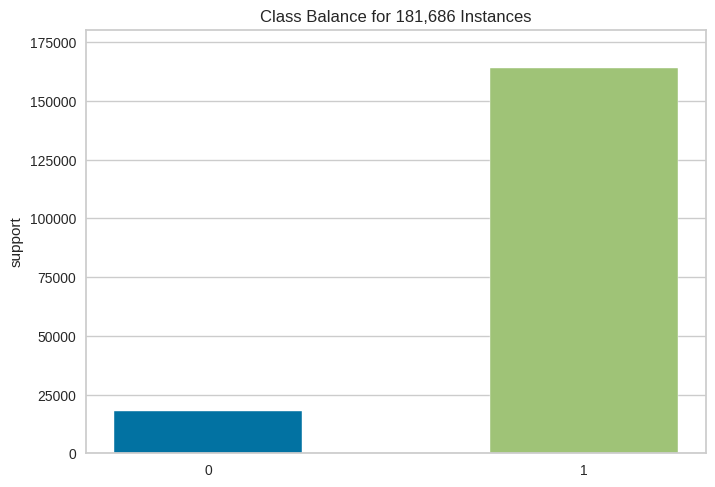

<Axes: title={'center': 'Class Balance for 181,686 Instances'}, ylabel='support'>

In [72]:
#check if class labels are balanced

from yellowbrick.target import ClassBalance
X= new_df.drop(columns='bad_loan', axis=1)
y = new_df['bad_loan']
visualizer = ClassBalance()
visualizer.fit(y)
visualizer.show()

From the chart above, we see the individuals classified as bad borrowers have very few observations. This class imbalance can affect our model while training. To solve this problem, we will oversample the minority class.

# Splitting into Train and Test

In [73]:
#spliting data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [74]:
#checking  imbalance for training dataset
y_train.value_counts()

1    131094
0     14254
Name: bad_loan, dtype: int64

In [75]:
#checking  imbalance for training dataset
y_train.value_counts() / len(y_train) * 100

1    90.193192
0     9.806808
Name: bad_loan, dtype: float64

In [76]:
# # Save data for train test split
# import pickle
# file = open('feature storage/X_train', 'wb')
# pickle.dump(X_train, file)
# file.close()

# file = open('feature storage/y_train', 'wb')
# pickle.dump(y_train, file)
# file.close()

# file = open('feature storage/X_test', 'wb')
# pickle.dump(X_test, file)
# file.close()

# file = open('feature storage/y_test', 'wb')
# pickle.dump(y_test, file)
# file.close()

# print("Saving done !!!")

In [77]:
X_train.head(10)

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,verification_status:NOT_VERIFIED,verification_status:SOURCE_VERIFIED,purpose:OTHER_HOUSE_MEDICAL,purpose:WEDDING_VACATION,purpose:HOME_IMPROVEMENT_MAJOR_PURCHASE,purpose:CAR_CREDIT_CARD,addr_state:NY,addr_state:LA_NM_OK_NC_MO_MD_NJ_VA,addr_state:CA,addr_state:AZ_MI_UT_TN_AR_PA,addr_state:RI_OH_KY_DE_MN_SD_MA_IN,addr_state:GA_WA,addr_state:WI_OR,addr_state:TX,addr_state:IL_CT_MT,addr_state:CO_SC,addr_state:KS_VT_AK_NS,addr_state:NH_WV_WY_DC,initial_list_status:W,term:36,total_rec_int:1000-2000,total_rec_int:2000-9000,total_rec_int:>9000,total_rev_hi_lim:10000-20000,total_rev_hi_lim:20000-40000,total_rev_hi_lim:40000-60000,total_rev_hi_lim:60000-80000,total_rev_hi_lim:80000-100000,total_rev_hi_lim:<100000,total_pymnt:5000-11000,total_pymnt:11000-16000,total_pymnt:16000-22000,total_pymnt:>22000,int_rate:<7.484,int_rate:7.484-9.548,int_rate:9.548-11.612,int_rate:11.612-13.676,int_rate:13.676-15.74,int_rate:15.74-17.804,int_rate:17.804-19.868,int_rate:7.19.868-21.932,dti:<4,dti:4-8,dti:8-12,dti:12-16,dti:16-20,dti:20-23,dti:23-27,annual_inc:32000-50000,annual_inc:50000-60000,annual_inc:60000-75000,annual_inc:75000-90000,annual_inc:90000-120000,annual_inc:120000-135000,annual_inc:135000-150000,annual_inc:>150000,inq_last_6mths:<1,inq_last_6mths:1-2,inq_last_6mths:2-4,tot_cur_bal:40000-80000,tot_cur_bal:80000-120000,tot_cur_bal:120000-160000,tot_cur_bal:160000-200000,tot_cur_bal:200000-240000,tot_cur_bal:240000-320000,tot_cur_bal:320000-400000,tot_cur_bal:>400000,mths_since_last_credit_pull_d:<65,mths_since_last_credit_pull_d:65-76,mths_since_issue_d_:<70.8,mths_since_issue_d_:>70.8-73.6,mths_since_issue_d_:73.6-76.4,mths_since_issue_d_:>76.4-79.2,mths_since_issue_d_:>79.2-82,mths_since_issue_d_>82-84,mths_since_issue_d_:>84-90.4,out_prncp:<3000,out_prncp:3000-6000,out_prncp:6000-10000,out_prncp:10000-12000
331449,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0
288712,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
70746,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
464189,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
339285,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0
388830,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0
61713,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
72275,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
366565,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
253866,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0


# Oversampling Minority Class to Resolve Class Imbalance

In [78]:
#import libraries for model training
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek

In [79]:
#dealing with imbalanced data
os = RandomOverSampler()
X_train_o, y_train_o = os.fit_resample(X_train, y_train)
y_train_series = pd.Series(y_train_o)
#check value counts after oversampling
y_train_series.value_counts()

1    131094
0    131094
Name: bad_loan, dtype: int64

In [80]:
# # Save data for oversampling
# import pickle
# file = open('feature storage/X_train_o', 'wb')
# pickle.dump(X_train_o, file)
# file.close()

# file = open('feature storage/y_train_o', 'wb')
# pickle.dump(y_train_o, file)
# file.close()

# Building PD Model (White-Box)

In [81]:
#building logistic regression model
model = LogisticRegression()
model.fit(X_train_o, y_train_o)

LogisticRegression()

In [82]:
#predicting
y_preds = model.predict(X_test)
#classification report
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.28      0.79      0.42      3570
           1       0.97      0.78      0.87     32768

    accuracy                           0.78     36338
   macro avg       0.63      0.79      0.64     36338
weighted avg       0.90      0.78      0.82     36338



In [83]:
y_hat_test_proba = model.predict_proba(X_test)
y_hat_test_proba = y_hat_test_proba[:][: , 1]
y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba), pd.DataFrame(y_preds)], axis = 1)
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba', 'y_hat_test']
y_test_proba.index = X_test.index
y_test_proba.head(-10)

,y_test_class_actual,y_hat_test_proba,y_hat_test
63645,1,0.865680,1
393671,1,0.869561,1
136741,0,0.105385,0
459873,1,0.608379,1
321075,1,0.901739,1
...,...,...,...
60541,1,0.477015,0
66798,1,0.624969,1
156013,1,0.439475,0
444099,1,0.780939,1


# Assessing Discriminatory Power of the PD Model

**1 A. ROC Curve**

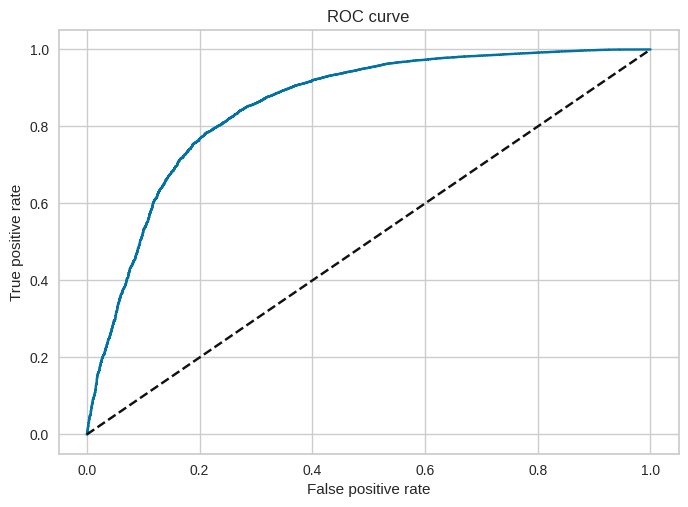

In [84]:
# get the values required to plot a ROC curve
fpr, tpr, thresholds = roc_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot the ROC curve
plt.plot(fpr, tpr)
# plot a secondary diagonal line, to plot randomness of model
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

**1 B. Area under ROC Curve**

In [85]:
#Area under receiver operating charateristic cure
AUROC = roc_auc_score(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
AUROC

0.853875993146282

**2. Gini Index**

In [86]:
Gini = AUROC * 2 - 1
Gini

0.7077519862925641

In [87]:
y_train_pred = model.predict(X_train_o)
print(classification_report(y_train_o, y_train_pred))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78    131094
           1       0.78      0.78      0.78    131094

    accuracy                           0.78    262188
   macro avg       0.78      0.78      0.78    262188
weighted avg       0.78      0.78      0.78    262188



In [88]:
y_train_pred = model.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.28      0.78      0.42     14254
           1       0.97      0.78      0.87    131094

    accuracy                           0.78    145348
   macro avg       0.63      0.78      0.64    145348
weighted avg       0.90      0.78      0.82    145348



# Logistic Regression - Report

In [89]:
train_model_scores = {}
train_o_model_scores = {}
test_model_scores = {}

In [90]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [91]:
model = LogisticRegression()
model.fit(X_train_o, y_train_o)

y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_train_o_pred = model.predict(X_train_o)

model_name = 'Logistic Regression'
# result on test
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')
AUROC = roc_auc_score(y_test, y_test_pred)

test_model_scores[model_name] = [accuracy,precision, recall, f1,AUROC]

# result on train
accuracy = accuracy_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred, average='macro')
recall = recall_score(y_train, y_train_pred, average='macro')
f1 = f1_score(y_train, y_train_pred, average='macro')
AUROC = roc_auc_score(y_train, y_train_pred)

train_model_scores[model_name] = [accuracy, precision, recall, f1, AUROC]

# result on train_o
accuracy = accuracy_score(y_train_o, y_train_o_pred)
precision = precision_score(y_train_o, y_train_o_pred, average='macro')
recall = recall_score(y_train_o, y_train_o_pred, average='macro')
f1 = f1_score(y_train_o, y_train_o_pred, average='macro')
AUROC = roc_auc_score(y_train_o, y_train_o_pred)

train_o_model_scores[model_name] = [accuracy, precision, recall, f1, AUROC]

# Decision Tree

In [92]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train_o, y_train_o)

y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_train_o_pred = model.predict(X_train_o)

model_name = 'Decision Tree'
# result on test
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')
AUROC = roc_auc_score(y_test, y_test_pred)

test_model_scores[model_name] = [accuracy,precision, recall, f1,AUROC]

# result on train
accuracy = accuracy_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred, average='macro')
recall = recall_score(y_train, y_train_pred, average='macro')
f1 = f1_score(y_train, y_train_pred, average='macro')
AUROC = roc_auc_score(y_train, y_train_pred)

train_model_scores[model_name] = [accuracy, precision, recall, f1, AUROC]

# result on train_o
accuracy = accuracy_score(y_train_o, y_train_o_pred)
precision = precision_score(y_train_o, y_train_o_pred, average='macro')
recall = recall_score(y_train_o, y_train_o_pred, average='macro')
f1 = f1_score(y_train_o, y_train_o_pred, average='macro')
AUROC = roc_auc_score(y_train_o, y_train_o_pred)

train_o_model_scores[model_name] = [accuracy, precision, recall, f1, AUROC]

# Random Forest

In [93]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train_o, y_train_o)

y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_train_o_pred = model.predict(X_train_o)

model_name = 'Random Forest'
# result on test
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')
AUROC = roc_auc_score(y_test, y_test_pred)

test_model_scores[model_name] = [accuracy,precision, recall, f1,AUROC]

# result on train
accuracy = accuracy_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred, average='macro')
recall = recall_score(y_train, y_train_pred, average='macro')
f1 = f1_score(y_train, y_train_pred, average='macro')
AUROC = roc_auc_score(y_train, y_train_pred)

train_model_scores[model_name] = [accuracy, precision, recall, f1, AUROC]

# result on train_o
accuracy = accuracy_score(y_train_o, y_train_o_pred)
precision = precision_score(y_train_o, y_train_o_pred, average='macro')
recall = recall_score(y_train_o, y_train_o_pred, average='macro')
f1 = f1_score(y_train_o, y_train_o_pred, average='macro')
AUROC = roc_auc_score(y_train_o, y_train_o_pred)

train_o_model_scores[model_name] = [accuracy, precision, recall, f1, AUROC]

# K-Nearest Neighbors

In [94]:
# from sklearn.neighbors import KNeighborsClassifier
# model = KNeighborsClassifier()
# model.fit(X_train_o, y_train_o)

# y_test_pred = model.predict(X_test)
# y_train_pred = model.predict(X_train)
# y_train_o_pred = model.predict(X_train_o)

# model_name = 'KNN'
# # result on test
# accuracy = accuracy_score(y_test, y_test_pred)
# precision = precision_score(y_test, y_test_pred, average='macro')
# recall = recall_score(y_test, y_test_pred, average='macro')
# f1 = f1_score(y_test, y_test_pred, average='macro')
# AUROC = roc_auc_score(y_test, y_test_pred)

# test_model_scores[model_name] = [accuracy,precision, recall, f1,AUROC]

# # result on train
# accuracy = accuracy_score(y_train, y_train_pred)
# precision = precision_score(y_train, y_train_pred, average='macro')
# recall = recall_score(y_train, y_train_pred, average='macro')
# f1 = f1_score(y_train, y_train_pred, average='macro')
# AUROC = roc_auc_score(y_train, y_train_pred)

# train_model_scores[model_name] = [accuracy, precision, recall, f1, AUROC]

# # result on train_o
# accuracy = accuracy_score(y_train_o, y_train_o_pred)
# precision = precision_score(y_train_o, y_train_o_pred, average='macro')
# recall = recall_score(y_train_o, y_train_o_pred, average='macro')
# f1 = f1_score(y_train_o, y_train_o_pred, average='macro')
# AUROC = roc_auc_score(y_train_o, y_train_o_pred)

# train_o_model_scores[model_name] = [accuracy, precision, recall, f1, AUROC]

# Support Vector Machine

In [95]:
# from sklearn.svm import SVC

# model = SVC(kernel='linear')
# model.fit(X_train_o, y_train_o)

# y_test_pred = model.predict(X_test)
# y_train_pred = model.predict(X_train)
# y_train_o_pred = model.predict(X_train_o)

# model_name = 'Support Vector Machine'
# # result on test
# accuracy = accuracy_score(y_test, y_test_pred)
# precision = precision_score(y_test, y_test_pred, average='macro')
# recall = recall_score(y_test, y_test_pred, average='macro')
# f1 = f1_score(y_test, y_test_pred, average='macro')
# AUROC = roc_auc_score(y_test, y_test_pred)

# test_model_scores[model_name] = [accuracy,precision, recall, f1,AUROC]

# # result on train
# accuracy = accuracy_score(y_train, y_train_pred)
# precision = precision_score(y_train, y_train_pred, average='macro')
# recall = recall_score(y_train, y_train_pred, average='macro')
# f1 = f1_score(y_train, y_train_pred, average='macro')
# AUROC = roc_auc_score(y_train, y_train_pred)

# train_model_scores[model_name] = [accuracy, precision, recall, f1, AUROC]

# # result on train_o
# accuracy = accuracy_score(y_train_o, y_train_o_pred)
# precision = precision_score(y_train_o, y_train_o_pred, average='macro')
# recall = recall_score(y_train_o, y_train_o_pred, average='macro')
# f1 = f1_score(y_train_o, y_train_o_pred, average='macro')
# AUROC = roc_auc_score(y_train_o, y_train_o_pred)

# train_o_model_scores[model_name] = [accuracy, precision, recall, f1, AUROC]

# XGBoost

In [96]:
pip install xgboost

In [99]:
X_train_o.columns = ['grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F',
 'home_ownership_OWN', 'home_ownership_MORTGAGE',
 'verification_status_NOT_VERIFIED', 'verification_status_SOURCE_VERIFIED',
 'purpose_OTHER_HOUSE_MEDICAL', 'purpose_WEDDING_VACATION',
 'purpose_HOME_IMPROVEMENT_MAJOR_PURCHASE', 'purpose_CAR_CREDIT_CARD',
 'addr_state_NY', 'addr_state_LA_NM_OK_NC_MO_MD_NJ_VA', 'addr_state_CA',
 'addr_state_AZ_MI_UT_TN_AR_PA', 'addr_state_RI_OH_KY_DE_MN_SD_MA_IN',
 'addr_state_GA_WA', 'addr_state_WI_OR', 'addr_state_TX',
 'addr_state_IL_CT_MT', 'addr_state_CO_SC', 'addr_state_KS_VT_AK_NS',
 'addr_state_NH_WV_WY_DC', 'initial_list_status_W', 'term_36',
 'total_rec_int_1000_2000', 'total_rec_int_2000_9000', 'total_rec_int_gt_9000',
 'total_rev_hi_lim_10000_20000', 'total_rev_hi_lim_20000_40000',
 'total_rev_hi_lim_40000_60000', 'total_rev_hi_lim_60000_80000',
 'total_rev_hi_lim_80000_100000', 'total_rev_hi_lim_lt_100000',
 'total_pymnt_5000_11000', 'total_pymnt_11000_16000', 'total_pymnt_16000_22000',
 'total_pymnt_gt_22000', 'int_rate_lt_7.484', 'int_rate_7.484_9.548',
 'int_rate_9.548_11.612', 'int_rate_11.612_13.676', 'int_rate_13.676_15.74',
 'int_rate_15.74_17.804', 'int_rate_17.804_19.868', 'int_rate_gt_19.868',
 'dti_lt_4', 'dti_4_8', 'dti_8_12', 'dti_12_16', 'dti_16_20', 'dti_20_23',
 'dti_23_27', 'annual_inc_32000_50000', 'annual_inc_50000_60000',
 'annual_inc_60000_75000', 'annual_inc_75000_90000', 'annual_inc_90000_120000',
 'annual_inc_120000_135000', 'annual_inc_135000_150000', 'annual_inc_gt_150000',
 'inq_last_6mths_lt_1', 'inq_last_6mths_1_2', 'inq_last_6mths_2_4',
 'tot_cur_bal_40000_80000','tot_cur_bal_80000_120000', 'tot_cur_bal_120000_160000', 'tot_cur_bal_160000_200000',
 'tot_cur_bal_200000_240000', 'tot_cur_bal_240000_320000', 'tot_cur_bal_320000_400000',
 'tot_cur_bal_gt_400000', 'mths_since_last_credit_pull_d_lt_65',
 'mths_since_last_credit_pull_d_65_76', 'mths_since_issue_d_lt_70.8',
 'mths_since_issue_d_gt_70.8_73.6', 'mths_since_issue_d_73.6_76.4',
 'mths_since_issue_d_gt_76.4_79.2', 'mths_since_issue_d_gt_79.2_82',
 'mths_since_issue_d_gt_82_84', 'mths_since_issue_d_gt_84_90.4',
 'out_prncp_lt_3000', 'out_prncp_3000_6000', 'out_prncp_6000_10000',
 'out_prncp_10000_12000']

In [101]:
X_test.columns = ['grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F',
 'home_ownership_OWN', 'home_ownership_MORTGAGE',
 'verification_status_NOT_VERIFIED', 'verification_status_SOURCE_VERIFIED',
 'purpose_OTHER_HOUSE_MEDICAL', 'purpose_WEDDING_VACATION',
 'purpose_HOME_IMPROVEMENT_MAJOR_PURCHASE', 'purpose_CAR_CREDIT_CARD',
 'addr_state_NY', 'addr_state_LA_NM_OK_NC_MO_MD_NJ_VA', 'addr_state_CA',
 'addr_state_AZ_MI_UT_TN_AR_PA', 'addr_state_RI_OH_KY_DE_MN_SD_MA_IN',
 'addr_state_GA_WA', 'addr_state_WI_OR', 'addr_state_TX',
 'addr_state_IL_CT_MT', 'addr_state_CO_SC', 'addr_state_KS_VT_AK_NS',
 'addr_state_NH_WV_WY_DC', 'initial_list_status_W', 'term_36',
 'total_rec_int_1000_2000', 'total_rec_int_2000_9000', 'total_rec_int_gt_9000',
 'total_rev_hi_lim_10000_20000', 'total_rev_hi_lim_20000_40000',
 'total_rev_hi_lim_40000_60000', 'total_rev_hi_lim_60000_80000',
 'total_rev_hi_lim_80000_100000', 'total_rev_hi_lim_lt_100000',
 'total_pymnt_5000_11000', 'total_pymnt_11000_16000', 'total_pymnt_16000_22000',
 'total_pymnt_gt_22000', 'int_rate_lt_7.484', 'int_rate_7.484_9.548',
 'int_rate_9.548_11.612', 'int_rate_11.612_13.676', 'int_rate_13.676_15.74',
 'int_rate_15.74_17.804', 'int_rate_17.804_19.868', 'int_rate_gt_19.868',
 'dti_lt_4', 'dti_4_8', 'dti_8_12', 'dti_12_16', 'dti_16_20', 'dti_20_23',
 'dti_23_27', 'annual_inc_32000_50000', 'annual_inc_50000_60000',
 'annual_inc_60000_75000', 'annual_inc_75000_90000', 'annual_inc_90000_120000',
 'annual_inc_120000_135000', 'annual_inc_135000_150000', 'annual_inc_gt_150000',
 'inq_last_6mths_lt_1', 'inq_last_6mths_1_2', 'inq_last_6mths_2_4',
 'tot_cur_bal_40000_80000','tot_cur_bal_80000_120000', 'tot_cur_bal_120000_160000', 'tot_cur_bal_160000_200000',
 'tot_cur_bal_200000_240000', 'tot_cur_bal_240000_320000', 'tot_cur_bal_320000_400000',
 'tot_cur_bal_gt_400000', 'mths_since_last_credit_pull_d_lt_65',
 'mths_since_last_credit_pull_d_65_76', 'mths_since_issue_d_lt_70.8',
 'mths_since_issue_d_gt_70.8_73.6', 'mths_since_issue_d_73.6_76.4',
 'mths_since_issue_d_gt_76.4_79.2', 'mths_since_issue_d_gt_79.2_82',
 'mths_since_issue_d_gt_82_84', 'mths_since_issue_d_gt_84_90.4',
 'out_prncp_lt_3000', 'out_prncp_3000_6000', 'out_prncp_6000_10000',
 'out_prncp_10000_12000']

In [102]:
X_train.columns = ['grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F',
 'home_ownership_OWN', 'home_ownership_MORTGAGE',
 'verification_status_NOT_VERIFIED', 'verification_status_SOURCE_VERIFIED',
 'purpose_OTHER_HOUSE_MEDICAL', 'purpose_WEDDING_VACATION',
 'purpose_HOME_IMPROVEMENT_MAJOR_PURCHASE', 'purpose_CAR_CREDIT_CARD',
 'addr_state_NY', 'addr_state_LA_NM_OK_NC_MO_MD_NJ_VA', 'addr_state_CA',
 'addr_state_AZ_MI_UT_TN_AR_PA', 'addr_state_RI_OH_KY_DE_MN_SD_MA_IN',
 'addr_state_GA_WA', 'addr_state_WI_OR', 'addr_state_TX',
 'addr_state_IL_CT_MT', 'addr_state_CO_SC', 'addr_state_KS_VT_AK_NS',
 'addr_state_NH_WV_WY_DC', 'initial_list_status_W', 'term_36',
 'total_rec_int_1000_2000', 'total_rec_int_2000_9000', 'total_rec_int_gt_9000',
 'total_rev_hi_lim_10000_20000', 'total_rev_hi_lim_20000_40000',
 'total_rev_hi_lim_40000_60000', 'total_rev_hi_lim_60000_80000',
 'total_rev_hi_lim_80000_100000', 'total_rev_hi_lim_lt_100000',
 'total_pymnt_5000_11000', 'total_pymnt_11000_16000', 'total_pymnt_16000_22000',
 'total_pymnt_gt_22000', 'int_rate_lt_7.484', 'int_rate_7.484_9.548',
 'int_rate_9.548_11.612', 'int_rate_11.612_13.676', 'int_rate_13.676_15.74',
 'int_rate_15.74_17.804', 'int_rate_17.804_19.868', 'int_rate_gt_19.868',
 'dti_lt_4', 'dti_4_8', 'dti_8_12', 'dti_12_16', 'dti_16_20', 'dti_20_23',
 'dti_23_27', 'annual_inc_32000_50000', 'annual_inc_50000_60000',
 'annual_inc_60000_75000', 'annual_inc_75000_90000', 'annual_inc_90000_120000',
 'annual_inc_120000_135000', 'annual_inc_135000_150000', 'annual_inc_gt_150000',
 'inq_last_6mths_lt_1', 'inq_last_6mths_1_2', 'inq_last_6mths_2_4',
 'tot_cur_bal_40000_80000','tot_cur_bal_80000_120000', 'tot_cur_bal_120000_160000', 'tot_cur_bal_160000_200000',
 'tot_cur_bal_200000_240000', 'tot_cur_bal_240000_320000', 'tot_cur_bal_320000_400000',
 'tot_cur_bal_gt_400000', 'mths_since_last_credit_pull_d_lt_65',
 'mths_since_last_credit_pull_d_65_76', 'mths_since_issue_d_lt_70.8',
 'mths_since_issue_d_gt_70.8_73.6', 'mths_since_issue_d_73.6_76.4',
 'mths_since_issue_d_gt_76.4_79.2', 'mths_since_issue_d_gt_79.2_82',
 'mths_since_issue_d_gt_82_84', 'mths_since_issue_d_gt_84_90.4',
 'out_prncp_lt_3000', 'out_prncp_3000_6000', 'out_prncp_6000_10000',
 'out_prncp_10000_12000']

In [103]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train_o, y_train_o)

y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_train_o_pred = model.predict(X_train_o)

model_name = 'XGBoost'
# result on test
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')
AUROC = roc_auc_score(y_test, y_test_pred)

test_model_scores[model_name] = [accuracy,precision, recall, f1,AUROC]

# result on train
accuracy = accuracy_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred, average='macro')
recall = recall_score(y_train, y_train_pred, average='macro')
f1 = f1_score(y_train, y_train_pred, average='macro')
AUROC = roc_auc_score(y_train, y_train_pred)

train_model_scores[model_name] = [accuracy, precision, recall, f1, AUROC]

# result on train_o
accuracy = accuracy_score(y_train_o, y_train_o_pred)
precision = precision_score(y_train_o, y_train_o_pred, average='macro')
recall = recall_score(y_train_o, y_train_o_pred, average='macro')
f1 = f1_score(y_train_o, y_train_o_pred, average='macro')
AUROC = roc_auc_score(y_train_o, y_train_o_pred)

train_o_model_scores[model_name] = [accuracy, precision, recall, f1, AUROC]


# CatBoost

In [104]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 14.8 MB/s eta 0:00:00


In [105]:
from catboost import CatBoostClassifier
model = CatBoostClassifier()
model.fit(X_train_o, y_train_o)

y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_train_o_pred = model.predict(X_train_o)

model_name = 'CatBoost'
# result on test
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')
AUROC = roc_auc_score(y_test, y_test_pred)

test_model_scores[model_name] = [accuracy,precision, recall, f1,AUROC]

# result on train
accuracy = accuracy_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred, average='macro')
recall = recall_score(y_train, y_train_pred, average='macro')
f1 = f1_score(y_train, y_train_pred, average='macro')
AUROC = roc_auc_score(y_train, y_train_pred)

train_model_scores[model_name] = [accuracy, precision, recall, f1, AUROC]

# result on train_o
accuracy = accuracy_score(y_train_o, y_train_o_pred)
precision = precision_score(y_train_o, y_train_o_pred, average='macro')
recall = recall_score(y_train_o, y_train_o_pred, average='macro')
f1 = f1_score(y_train_o, y_train_o_pred, average='macro')
AUROC = roc_auc_score(y_train_o, y_train_o_pred)

train_o_model_scores[model_name] = [accuracy, precision, recall, f1, AUROC]

Learning rate set to 0.111092
0:	learn: 0.6431127	total: 63.5ms	remaining: 1m 3s
1:	learn: 0.5986985	total: 77ms	remaining: 38.4s
2:	learn: 0.5722552	total: 89.6ms	remaining: 29.8s
3:	learn: 0.5514639	total: 102ms	remaining: 25.4s
4:	learn: 0.5327410	total: 114ms	remaining: 22.8s
5:	learn: 0.5209298	total: 127ms	remaining: 21s
6:	learn: 0.5114107	total: 140ms	remaining: 19.9s
7:	learn: 0.5045976	total: 153ms	remaining: 19s
8:	learn: 0.4981951	total: 167ms	remaining: 18.4s
9:	learn: 0.4932068	total: 180ms	remaining: 17.8s
10:	learn: 0.4897269	total: 193ms	remaining: 17.4s
11:	learn: 0.4868153	total: 205ms	remaining: 16.9s
12:	learn: 0.4843017	total: 218ms	remaining: 16.6s
13:	learn: 0.4818677	total: 231ms	remaining: 16.2s
14:	learn: 0.4763066	total: 242ms	remaining: 15.9s
15:	learn: 0.4749499	total: 255ms	remaining: 15.7s
16:	learn: 0.4730370	total: 267ms	remaining: 15.5s
17:	learn: 0.4699819	total: 280ms	remaining: 15.3s
18:	learn: 0.4671852	total: 292ms	remaining: 15.1s
19:	learn: 0.4

# Report

In [106]:
test_report = pd.DataFrame(test_model_scores, index =  ['Accuracy', 'Precision', 'Recall', 'F1', 'AUROC']).T
test_report

,Accuracy,Precision,Recall,F1,AUROC
Logistic Regression,0.783863,0.627645,0.785811,0.642382,0.785811
Decision Tree,0.887941,0.688466,0.702249,0.694989,0.702249
Random Forest,0.928284,0.835484,0.705275,0.750345,0.705275
XGBoost,0.843305,0.664959,0.806789,0.697947,0.806789
CatBoost,0.852441,0.671777,0.805865,0.706226,0.805865


In [107]:
train_report = pd.DataFrame(train_model_scores, index =  ['Accuracy', 'Precision', 'Recall', 'F1', 'AUROC']).T
train_report

,Accuracy,Precision,Recall,F1,AUROC
Logistic Regression,0.784049,0.626642,0.782991,0.641382,0.782991
Decision Tree,0.999821,0.999090,0.999901,0.999495,0.999901
Random Forest,0.999821,0.999090,0.999901,0.999495,0.999901
XGBoost,0.858395,0.688556,0.853156,0.728032,0.853156
CatBoost,0.874935,0.709272,0.879302,0.753823,0.879302


In [108]:
train_o_report = pd.DataFrame(train_o_model_scores, index =  ['Accuracy', 'Precision', 'Recall', 'F1', 'AUROC']).T
train_o_report

,Accuracy,Precision,Recall,F1,AUROC
Logistic Regression,0.782526,0.782530,0.782526,0.782526,0.782526
Decision Tree,0.999901,0.999901,0.999901,0.999901,0.999901
Random Forest,0.999901,0.999901,0.999901,0.999901,0.999901
XGBoost,0.857068,0.857078,0.857068,0.857067,0.857068
CatBoost,0.884034,0.884192,0.884034,0.884022,0.884034
